In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import plotly.express as px

In [ ]:
bus_stops = pd.read_csv("hrt_stops.csv")
bus_stops['geometry'] = gpd.GeoSeries.from_xy(bus_stops['LONGITUDE'], bus_stops['LATITUDE'])
bus_stops_gdf = gpd.GeoDataFrame(bus_stops, geometry='geometry')

In [ ]:
import re

df = pd.read_csv('income.csv')

ztca = df.columns[1::].tolist()
incomes = df.iloc[11][1::].tolist() # switched to median income since there are less missing values
population = df.iloc[0][1::].tolist()


zipcode_data = {}


for i in range(0, len(ztca), 8):
  income = incomes[i]
  if income == "-":
    continue
  zipcode = int(re.search(r'\b\d{5}\b', ztca[i]).group())
  zipcode_data[zipcode] = [None for _ in range(10)] # household (0), household pop (1), familes (2), families pop (3), married-couple (4), married pop (5), non-family (6), non-family pop (7), Lat (8), Long (9)

  # incomes
  for j in range(i, i + 8, 2):
    income = incomes[j]
    if income == 'N' or income == '-':
      zipcode_data[zipcode][j - i] = np.nan
      continue

    cleaned_number = income.replace(',', '')
    income = int(cleaned_number)
    zipcode_data[zipcode][j - i] = income

  # population
  for j in range(i, i + 8, 2):
    pop = population[j]
    cleaned_number = pop.replace(',', '')
    pop = int(cleaned_number)
    zipcode_data[zipcode][j - i + 1] = pop

zip_df = pd.read_csv("zipcode_coords.csv")

zip_dict = dict(zip(zip_df['ZIP'], zip_df[['LAT', 'LNG']].values))

for zipcode in zipcode_data:
    if zipcode in zip_dict:
        lat, lng = zip_dict[zipcode]
        zipcode_data[zipcode][-2] = lat
        zipcode_data[zipcode][-1] = lng

print(zipcode_data)
print(len(zipcode_data))

{23320: [81963, 25243, 100043, 16546, 116210, 12503, 55131, 8697, 36.751734, -76.217637], 23321: [96235, 14034, 112698, 10663, 137656, 7874, 63190, 3371, 36.800209, -76.420759], 23322: [129628, 21763, 143459, 17784, 152945, 15221, 55784, 3979, 36.618712, -76.227046], 23323: [99407, 14373, 109923, 10997, 121732, 8608, 46795, 3376, 36.696963, -76.379928], 23324: [57636, 8688, 70455, 5922, 107489, 3043, 36128, 2766, 36.799721, -76.273447], 23325: [72708, 7383, 76011, 4961, 93135, 3147, 53906, 2422, 36.814548, -76.238429], 23432: [150461, 487, 158259, 378, 158214, 352, nan, 109, 36.876452, -76.553978], 23433: [144167, 504, 161500, 410, 189375, 367, 82500, 94, 36.918069, -76.462863], 23434: [73843, 19558, 90629, 13735, 113462, 9122, 43470, 5823, 36.703003, -76.592105], 23435: [107800, 12651, 127912, 8870, 143226, 6964, 65593, 3781, 36.83842, -76.480264], 23436: [185063, 381, 203875, 285, 204292, 275, 49286, 96, 36.893751, -76.506926], 23437: [70823, 1933, 81632, 1309, 102500, 960, 48750, 62

In [ ]:
from geopy.distance import geodesic

bus_stops = pd.read_csv("hrt_stops.csv")
data = []

def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def calculate_weighted_density(bus_lat, bus_long, zip_index):
  total_weight = 0
  weighted_values_sum = 0

  for zipcode in zipcode_data:
    zip_lat, zip_long = zipcode_data[zipcode][-2], zipcode_data[zipcode][-1]
    val = zipcode_data[zipcode][zip_index]
    if np.isnan(val):
      continue

    distance = calculate_distance(bus_lat, bus_long, zip_lat, zip_long)

    weight = 1 / (distance + 1e-5)
    weighted_values_sum += val * weight
    total_weight += weight

  return weighted_values_sum / total_weight

for i in range(len(bus_stops)):
  bus_lat, bus_long = bus_stops['LATITUDE'][i], bus_stops['LONGITUDE'][i]
  temp = [bus_lat, bus_long]
  for j in range(0, 8): # this goes through all incomes and populations, gets the weighted average, and appends to temp
    temp.append(calculate_weighted_density(bus_lat, bus_long, j))

  data.append(temp)

print(data)

[[36.709858, -76.265081, 82333.18242465168, 13775.08641168825, 94703.32913539406, 9337.611913585188, 113753.21076098998, 6670.806035020394, 49730.619205817115, 4437.474498103061], [36.709979, -76.266069, 82312.15144977851, 13754.396885911567, 94676.22735910855, 9323.247636155407, 113734.47051082682, 6658.976607067688, 49712.54010041677, 4431.14924975616], [36.710445, -76.270586, 82226.53852860283, 13660.055061580984, 94562.9767841525, 9258.147289154844, 113656.34327940369, 6605.670427682776, 49631.659300349165, 4401.90777242614], [36.710596, -76.270224, 82218.79542839614, 13667.503150697225, 94557.30595573987, 9262.690748699206, 113651.39147802285, 6608.959040113545, 49635.774832004, 4404.81240199802], [36.711001, -76.260336, 82308.43746756953, 13881.026597657545, 94709.41338624062, 9405.477575682537, 113746.17199153443, 6722.742057805198, 49802.03649015961, 4475.549021975011], [36.711671, -76.276367, 82079.38397682263, 13539.479750216786, 94380.08695098464, 9173.363849049963, 113526.0

Inertia for k=2: 12142.485792647652


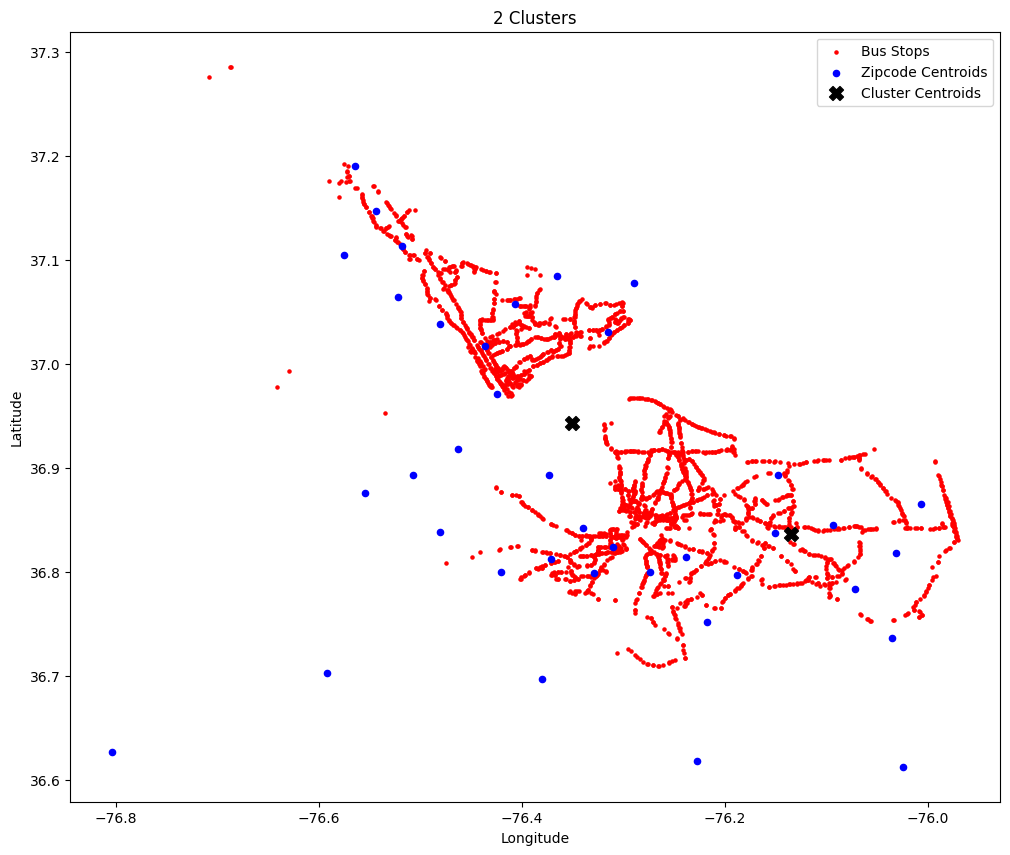

Inertia for k=3: 8459.084639632834


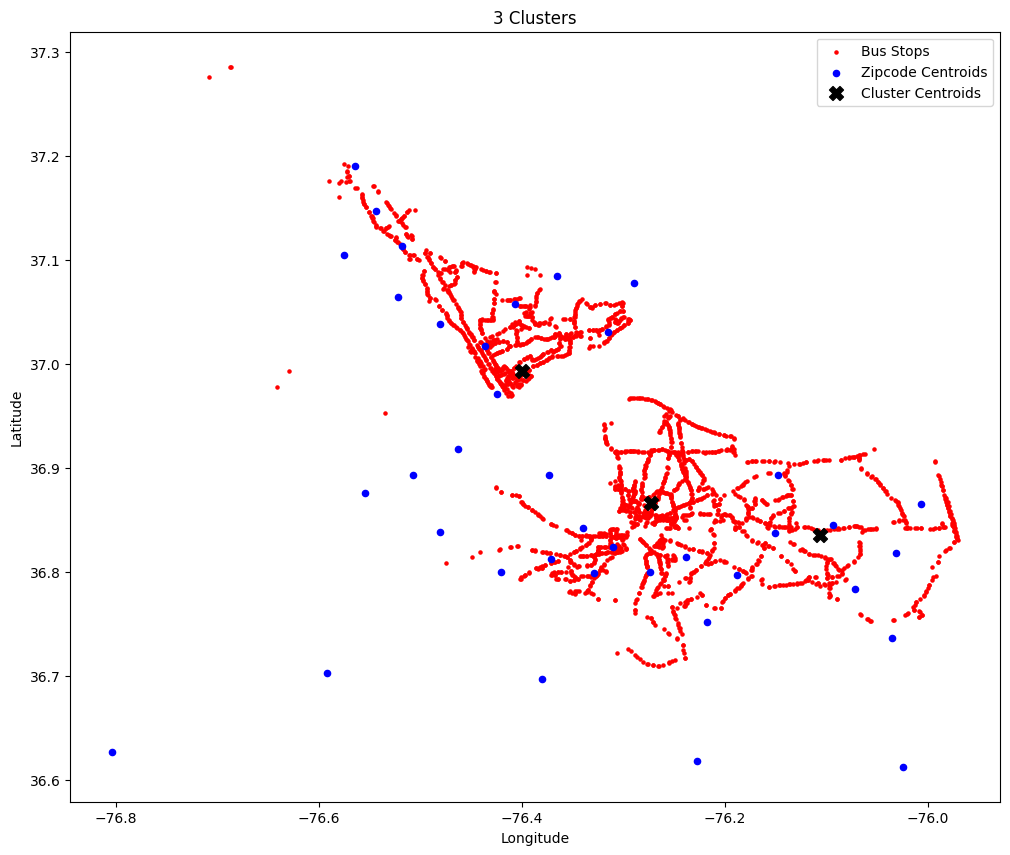

Inertia for k=4: 6160.744408194016


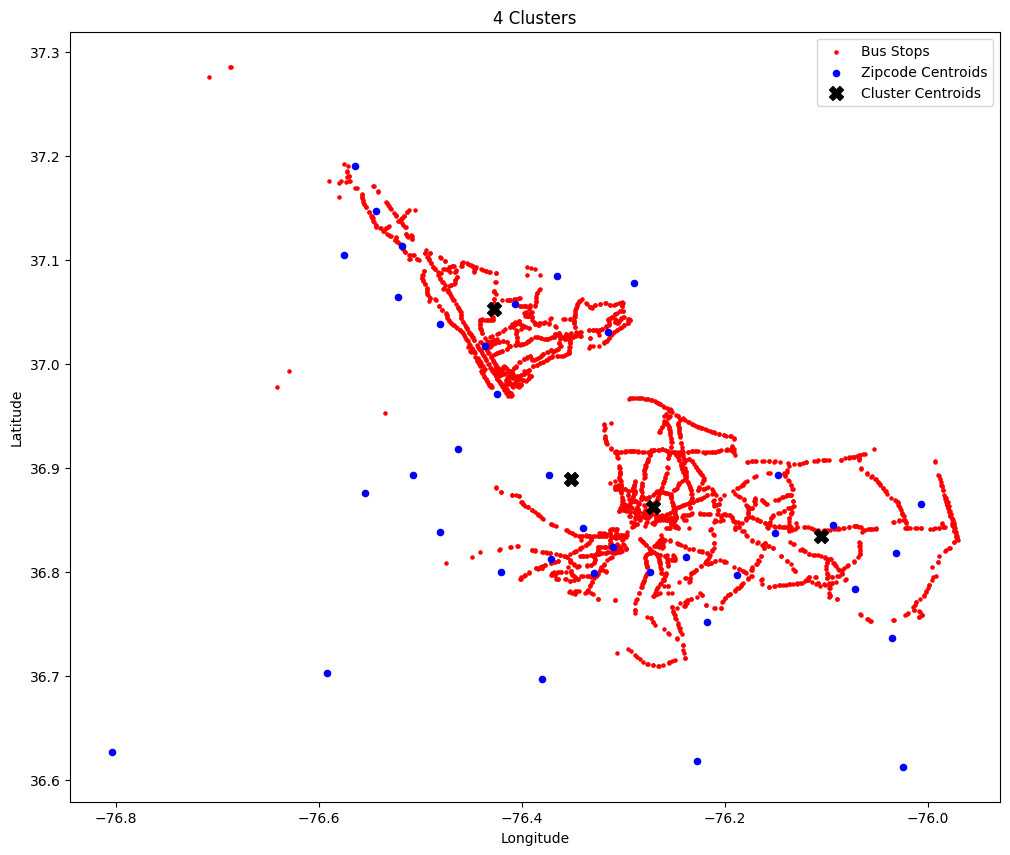

Inertia for k=5: 5385.875753091886


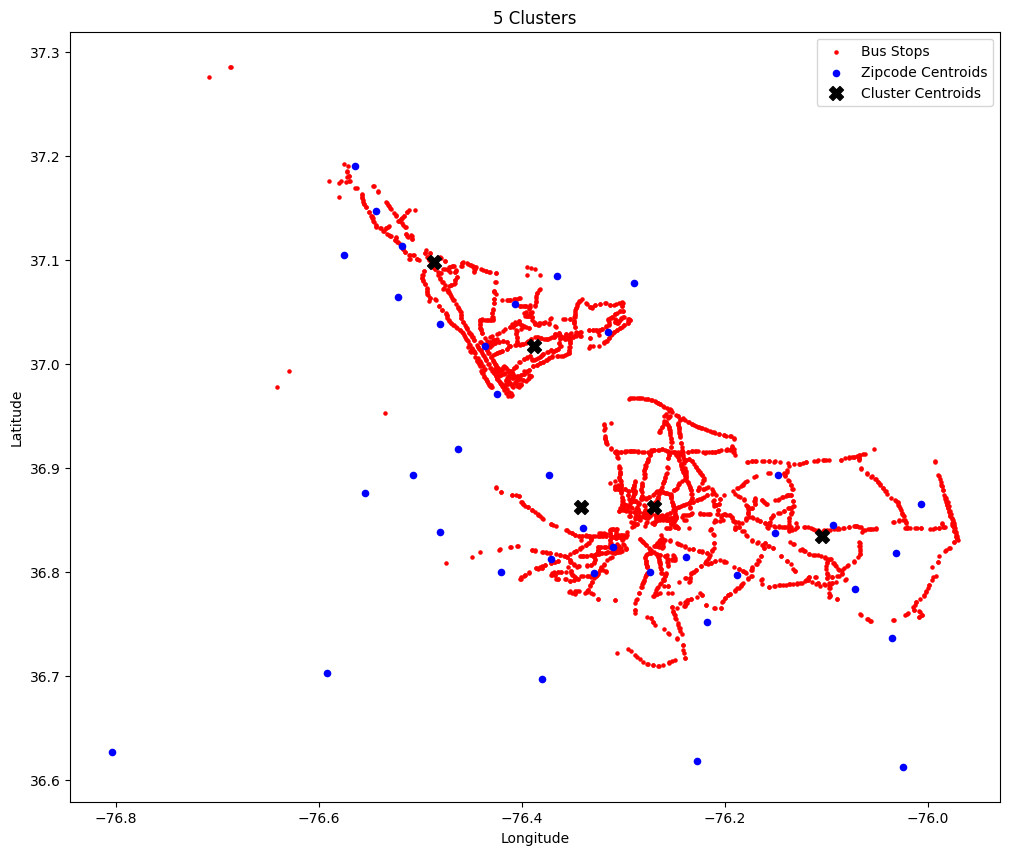

Inertia for k=6: 4644.83223161141


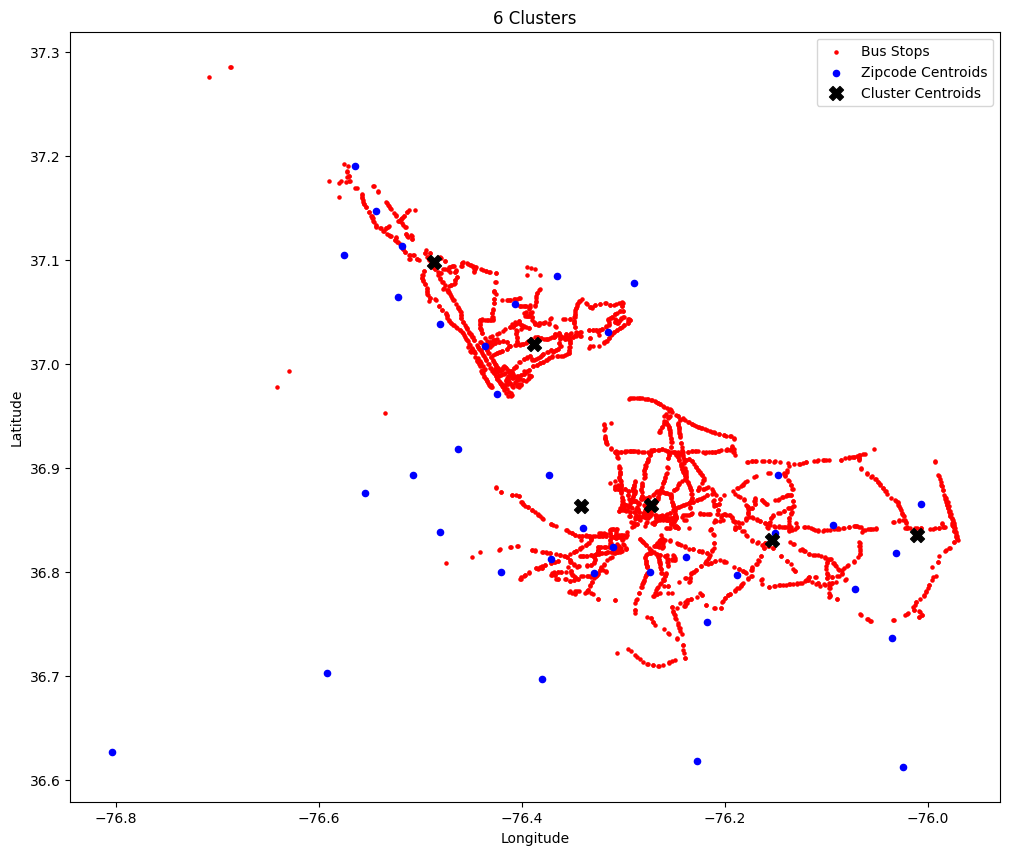

Inertia for k=7: 4023.9070274743117


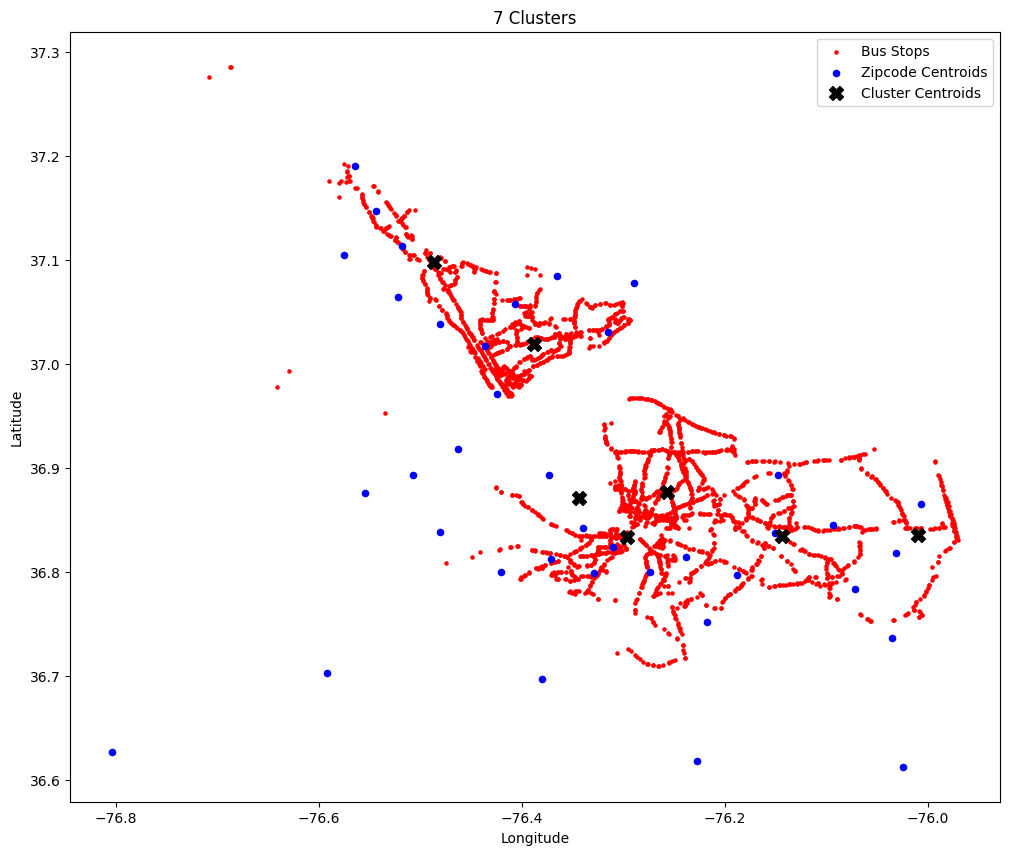

Inertia for k=8: 3638.5742806458225


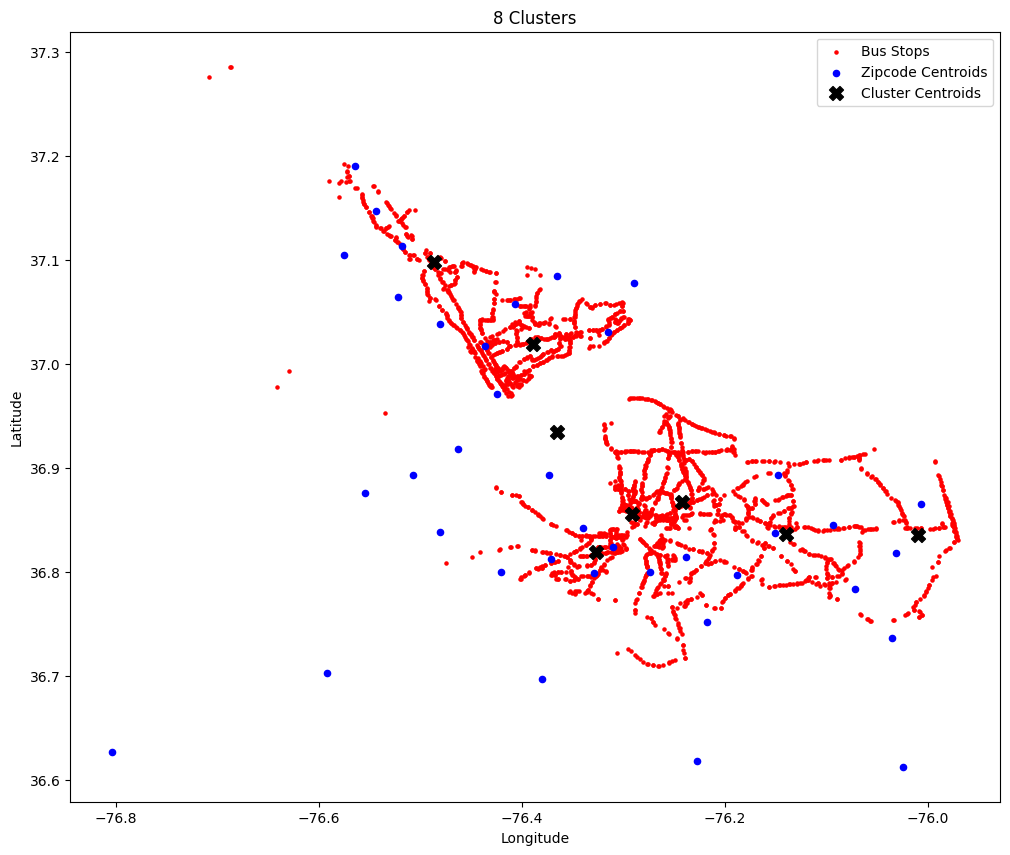

Inertia for k=9: 3287.9862414933655


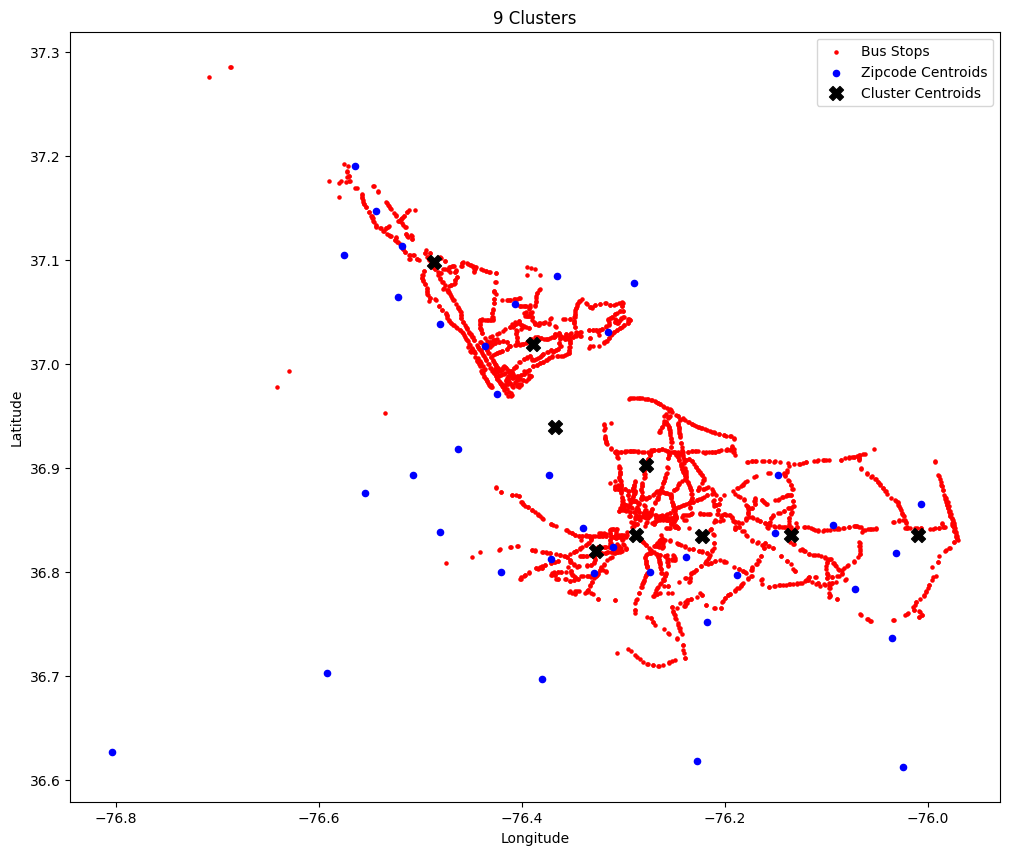

Inertia for k=10: 3070.91163126252


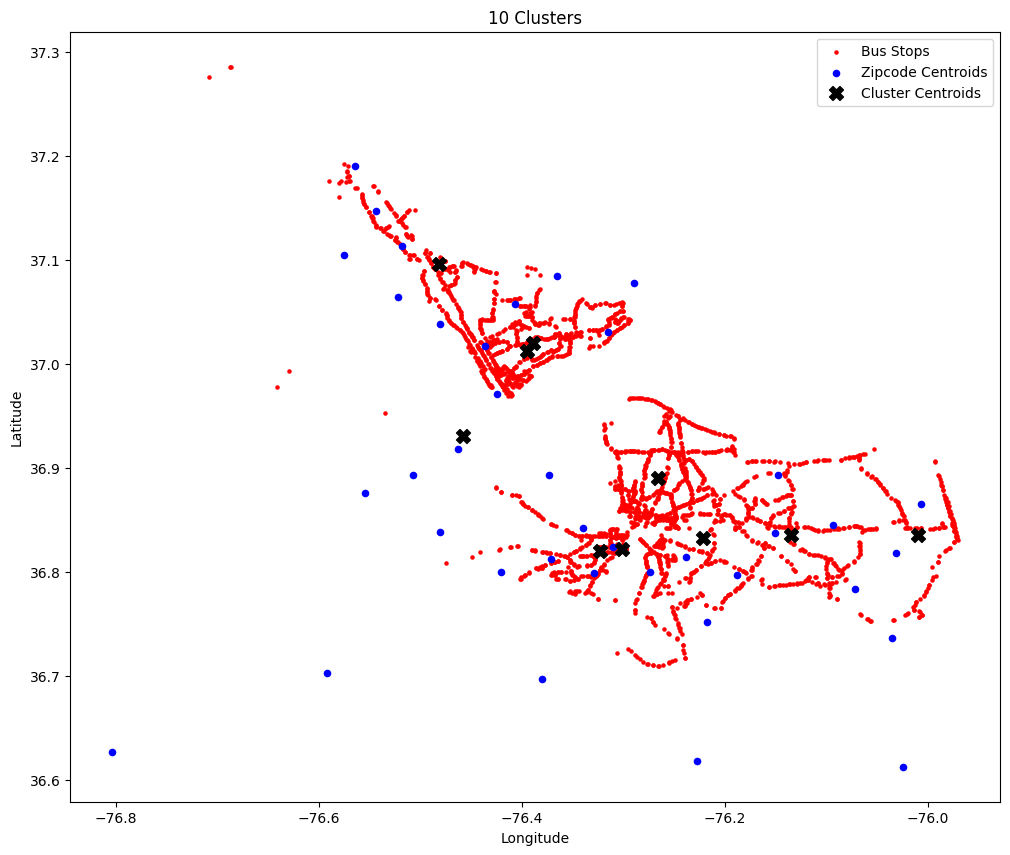

Inertia for k=11: 2781.347053205732


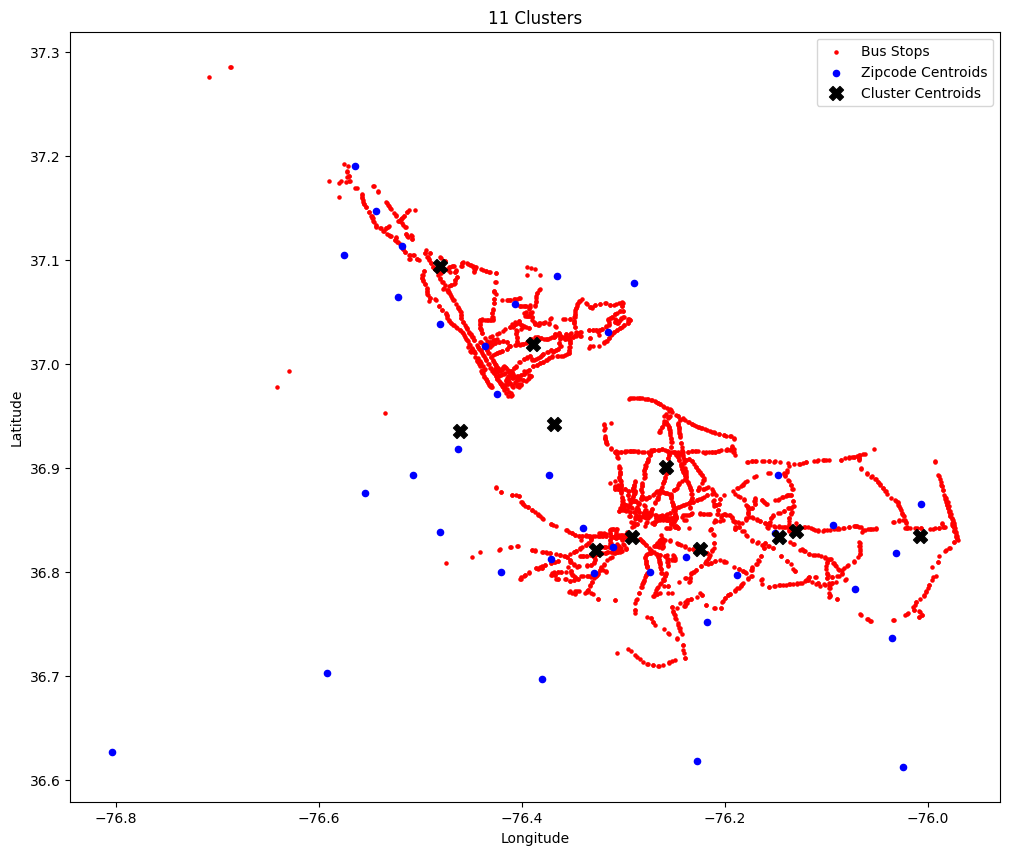

Inertia for k=12: 2589.1269821976853


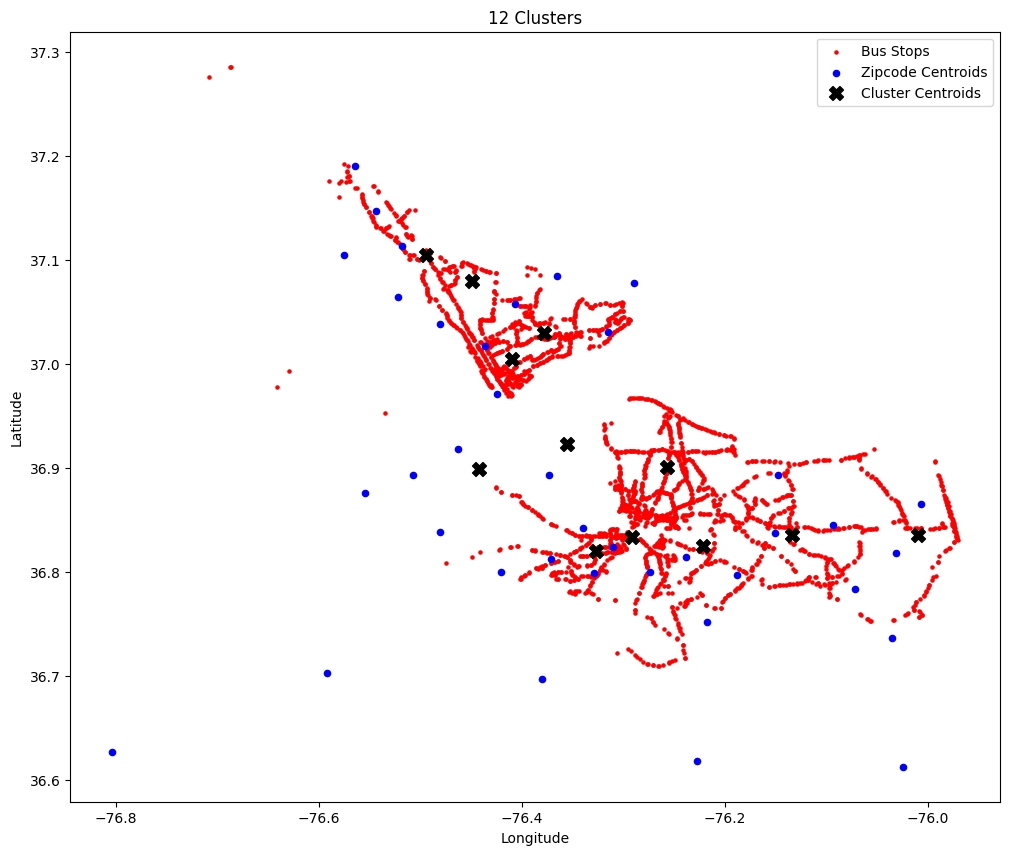

Inertia for k=13: 2403.370918175739


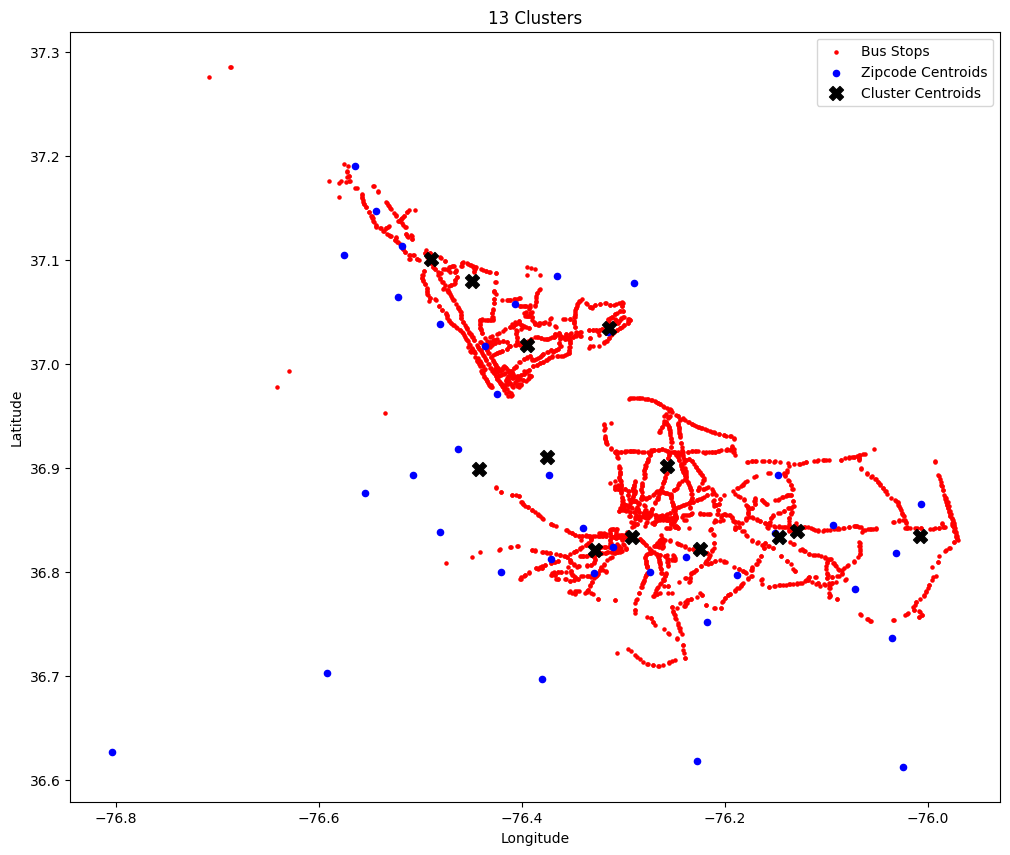

Inertia for k=14: 2226.520633474483


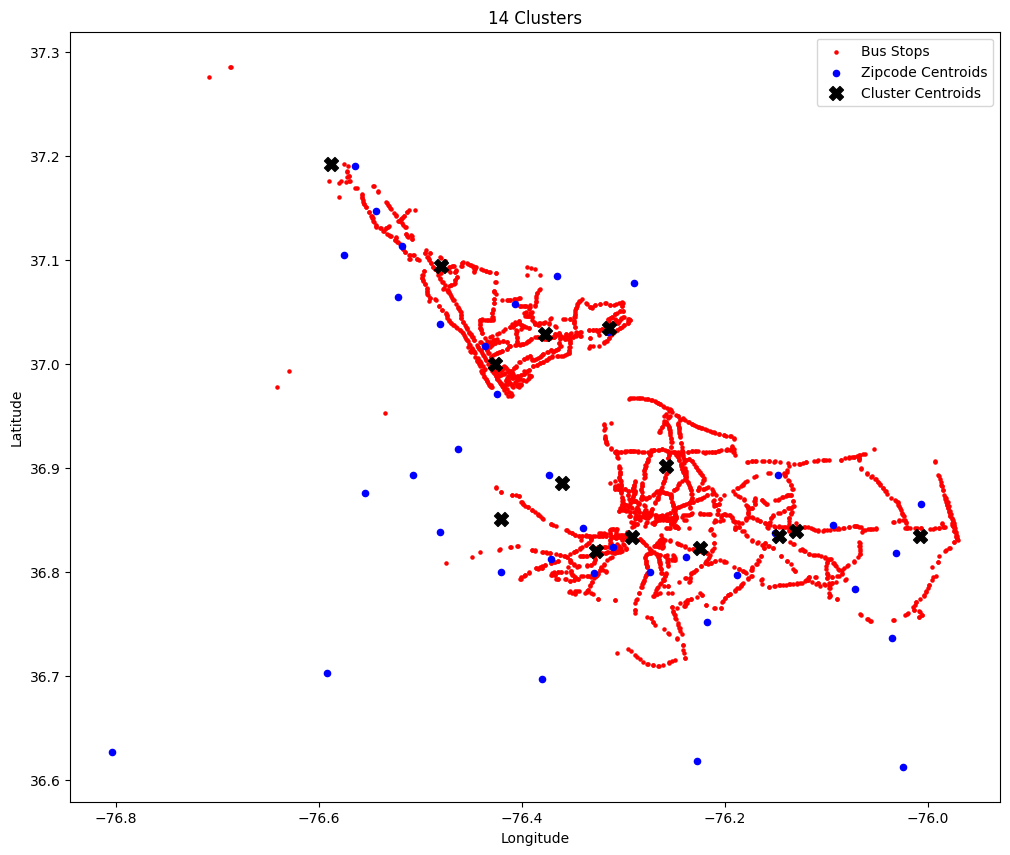

Inertia for k=15: 2113.3928751993376


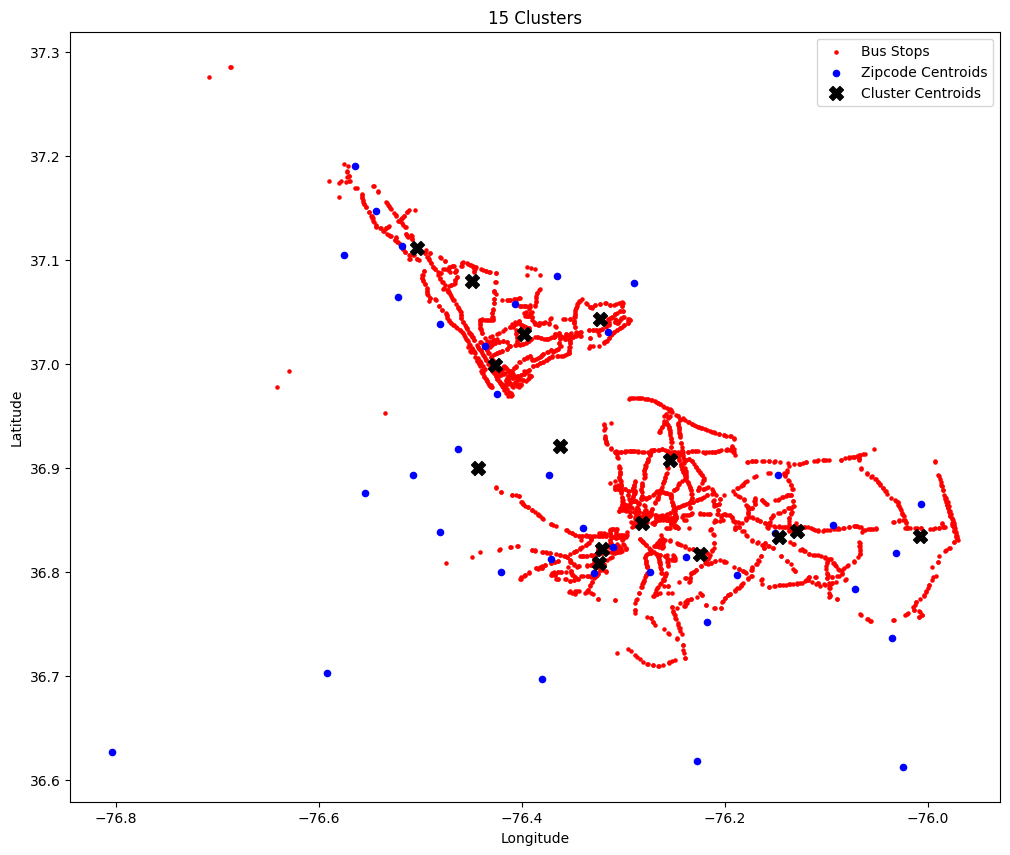

Inertia for k=16: 1953.735611930743


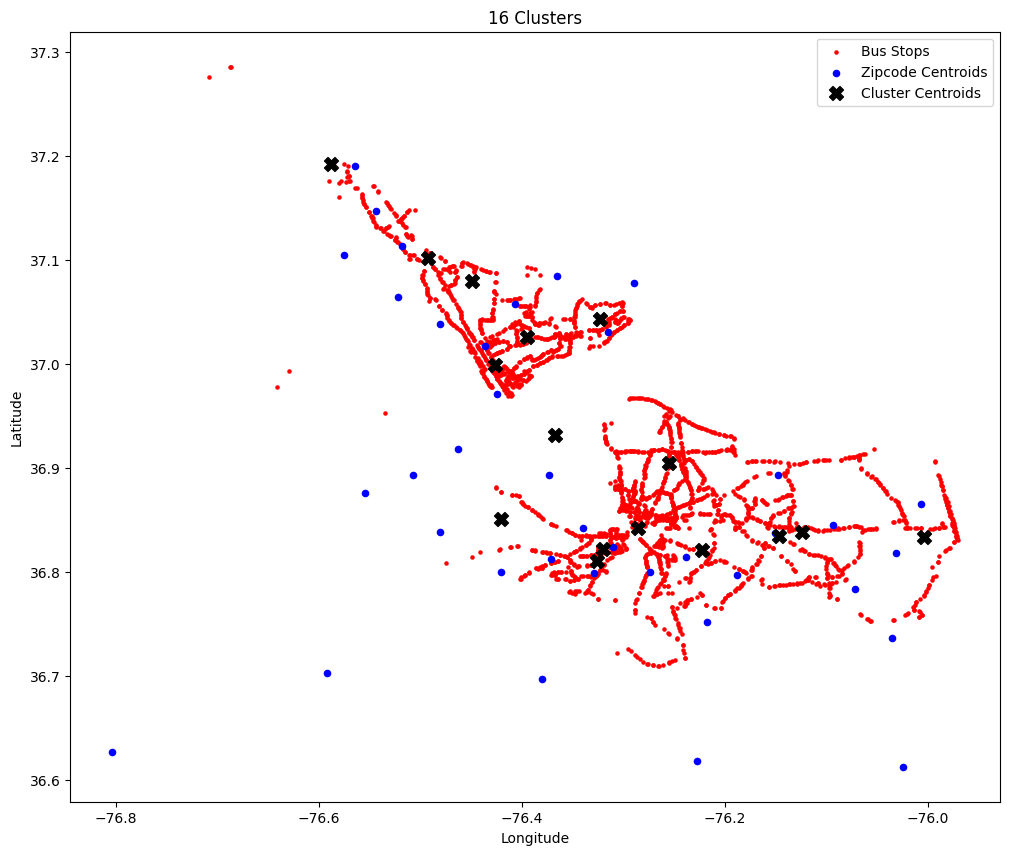

Inertia for k=17: 1845.9843274214682


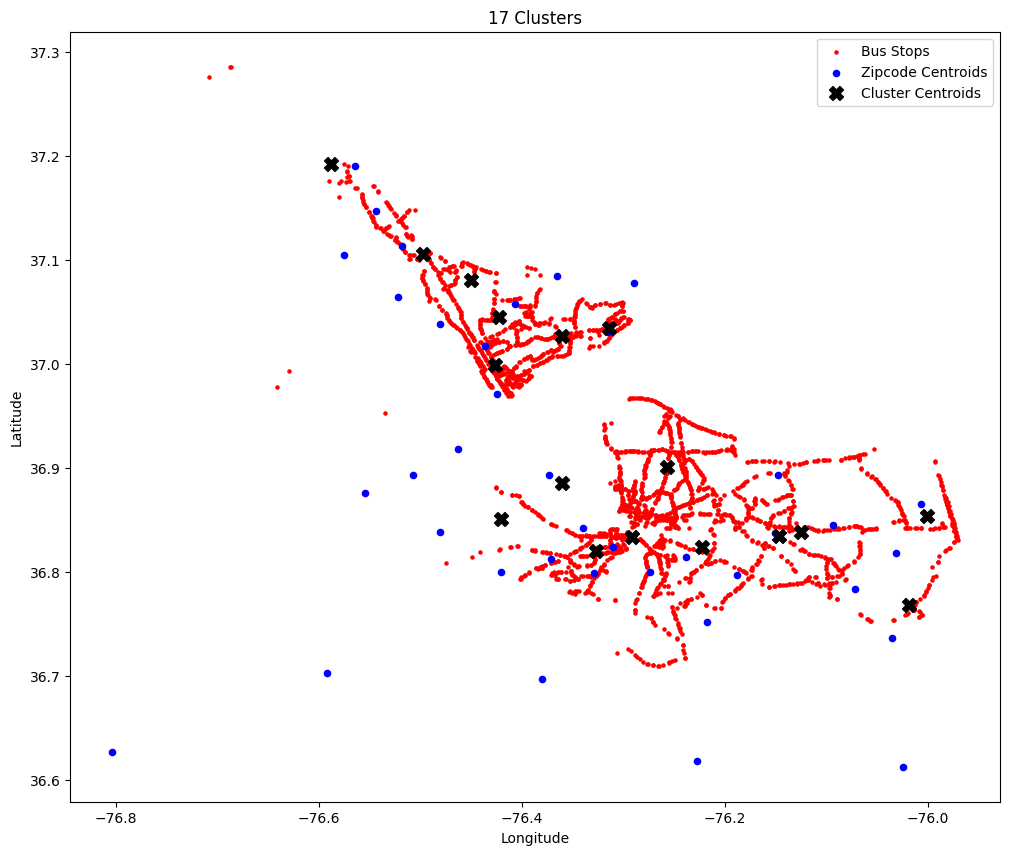

Inertia for k=18: 1740.5645083668949


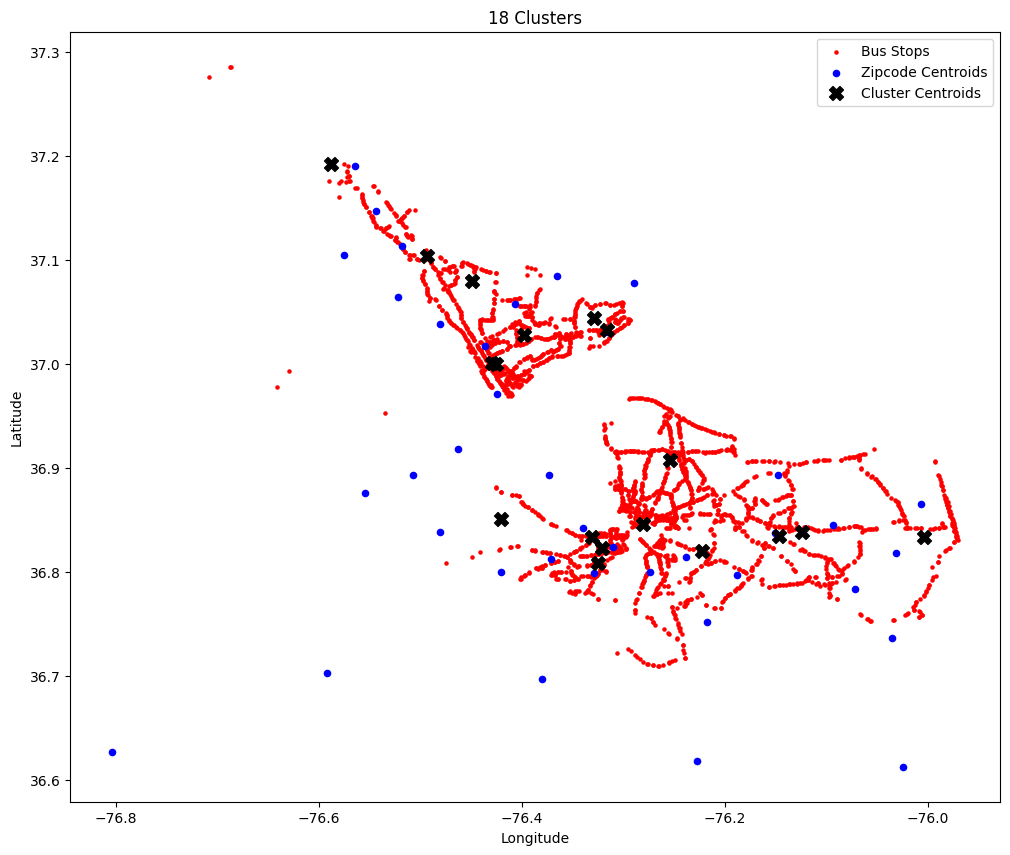

Inertia for k=19: 1646.5763751869051


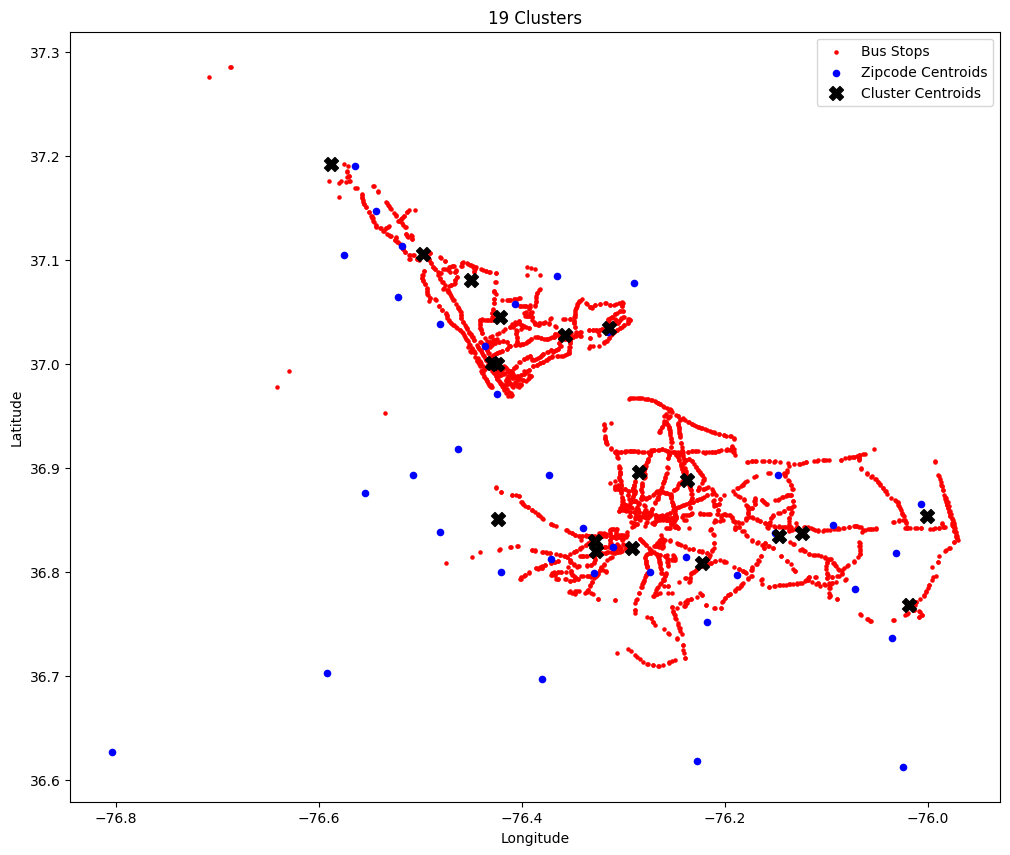

Inertia for k=20: 1551.1455033777986


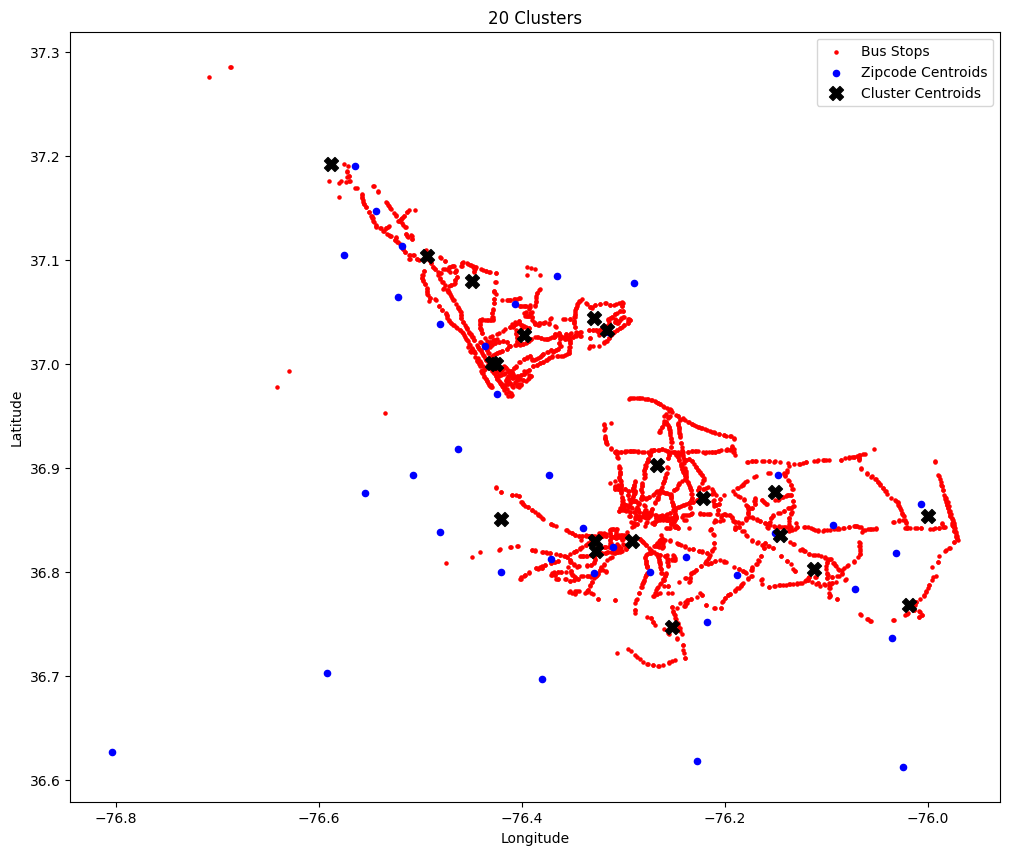

Inertia for k=21: 1485.0969806362868


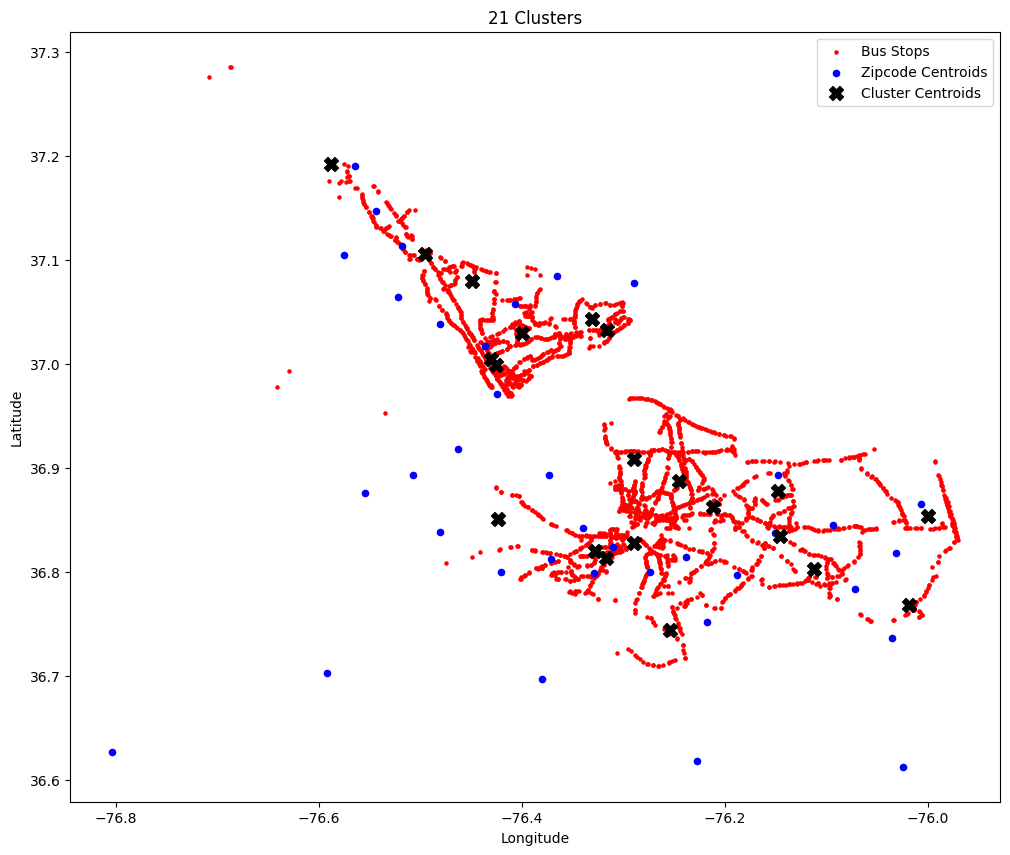

Inertia for k=22: 1406.1933792840562


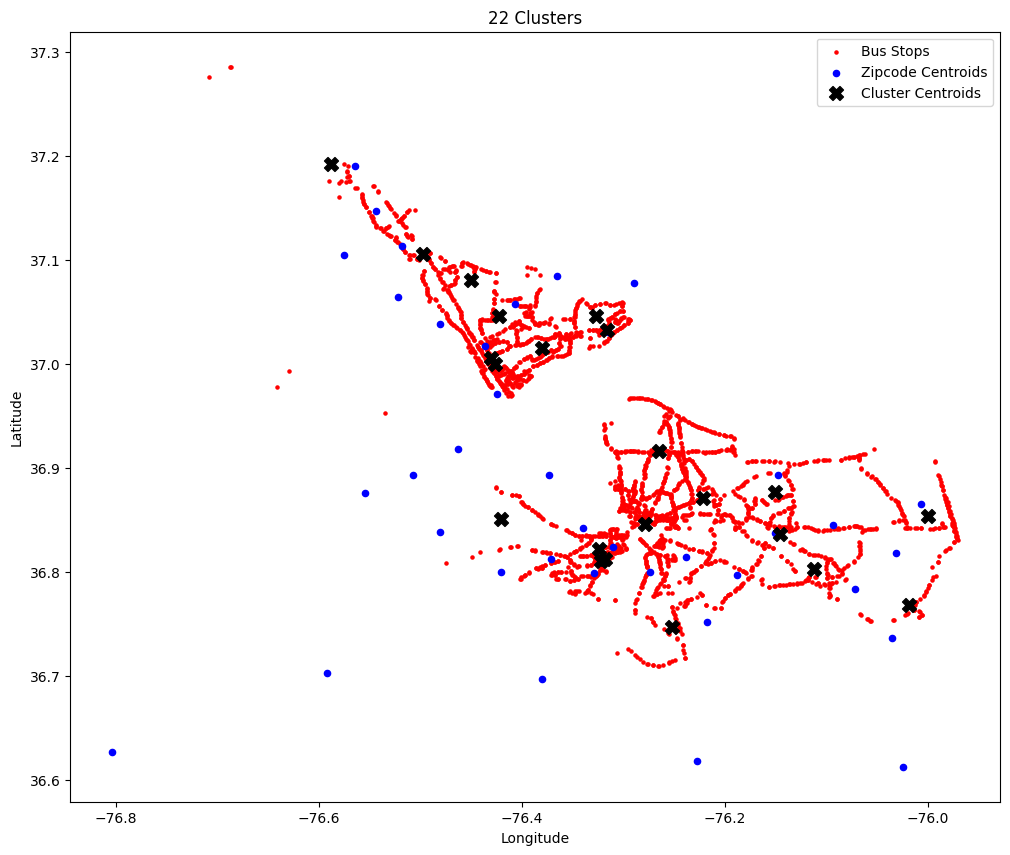

Inertia for k=23: 1353.711441924134


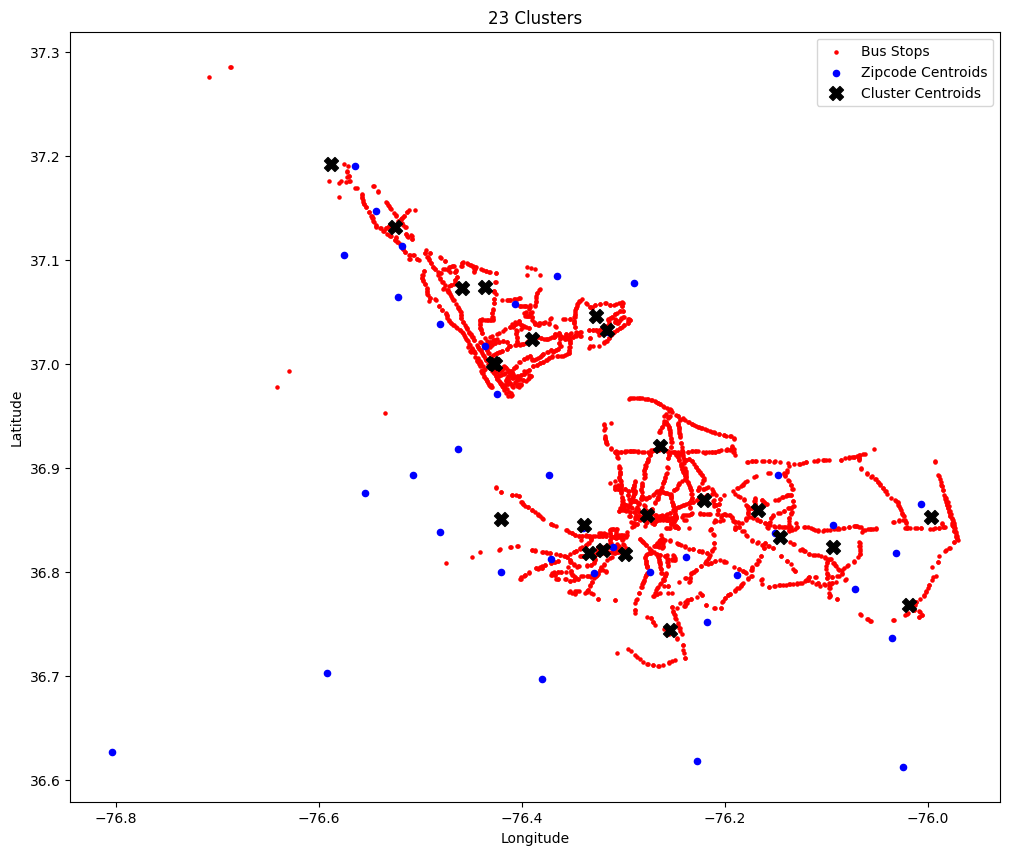

Inertia for k=24: 1297.7476733784229


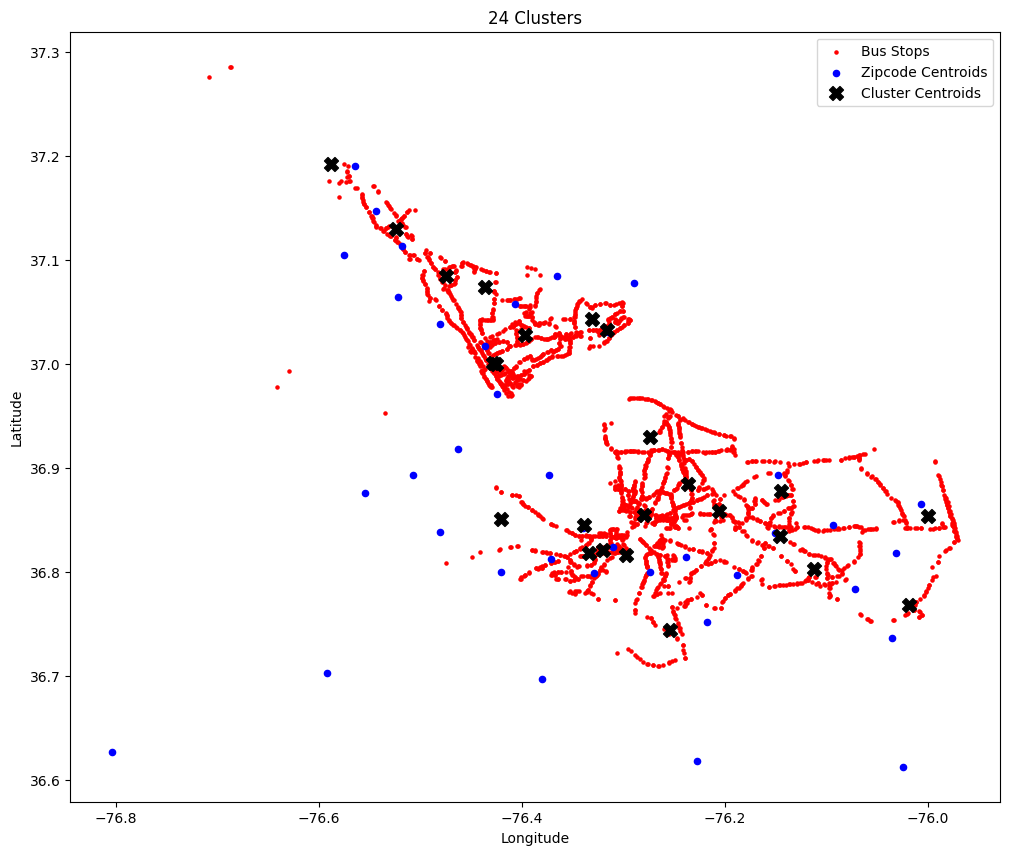

Inertia for k=25: 1234.5781876432259


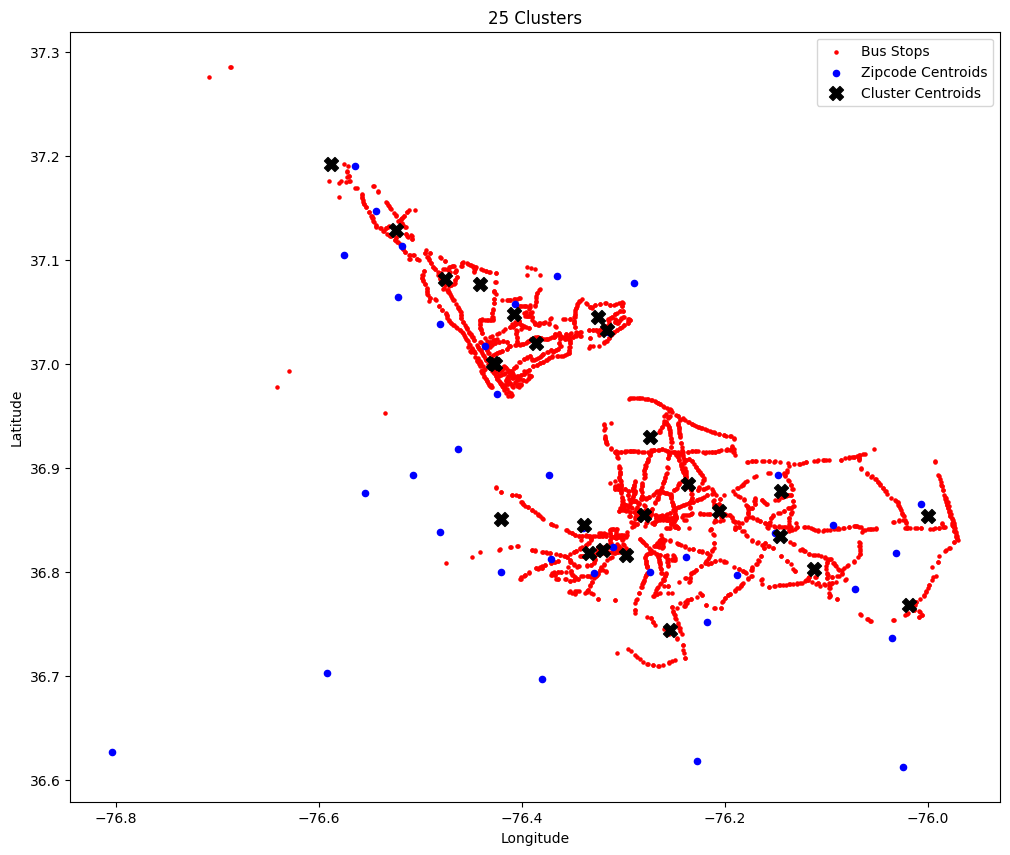

Inertia for k=26: 1191.3323997771276


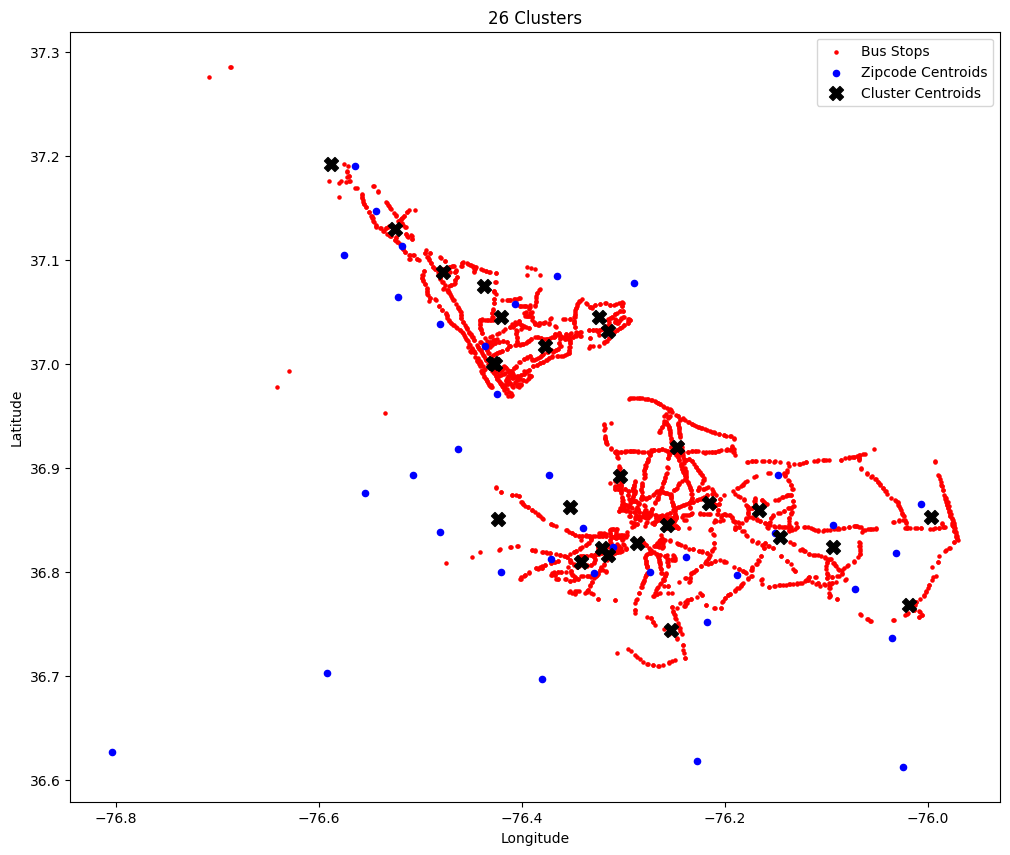

Inertia for k=27: 1145.930991784544


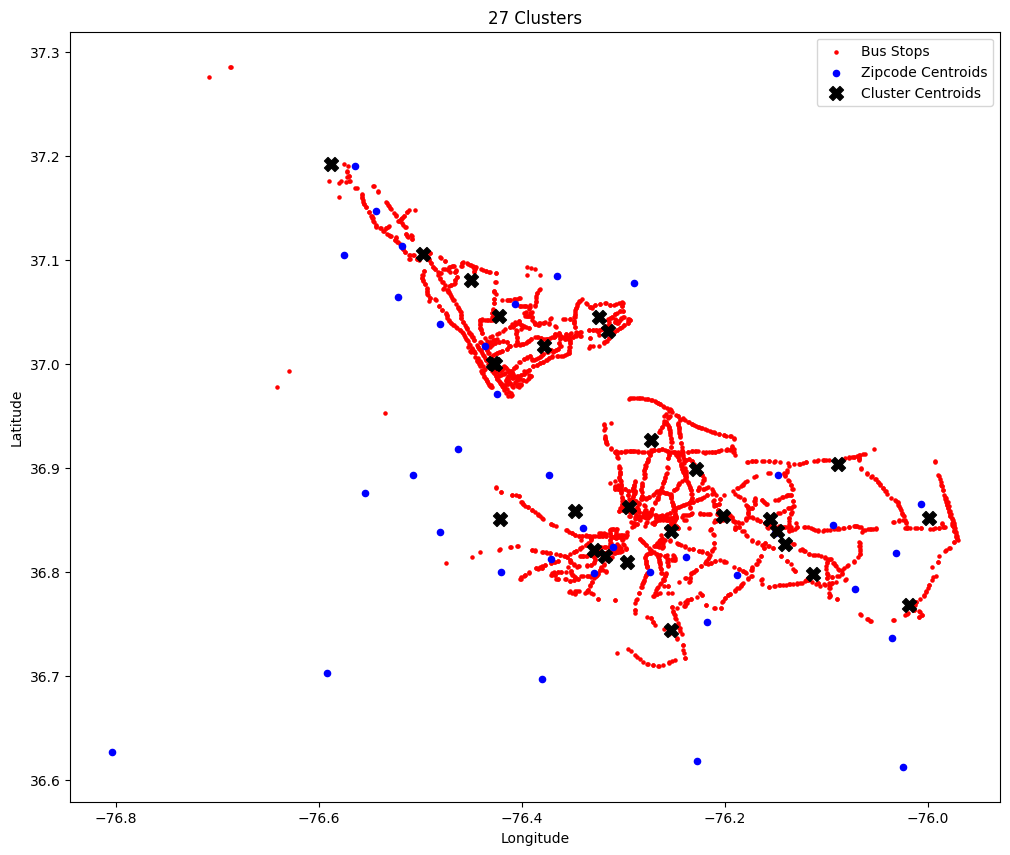

Inertia for k=28: 1091.479460461556


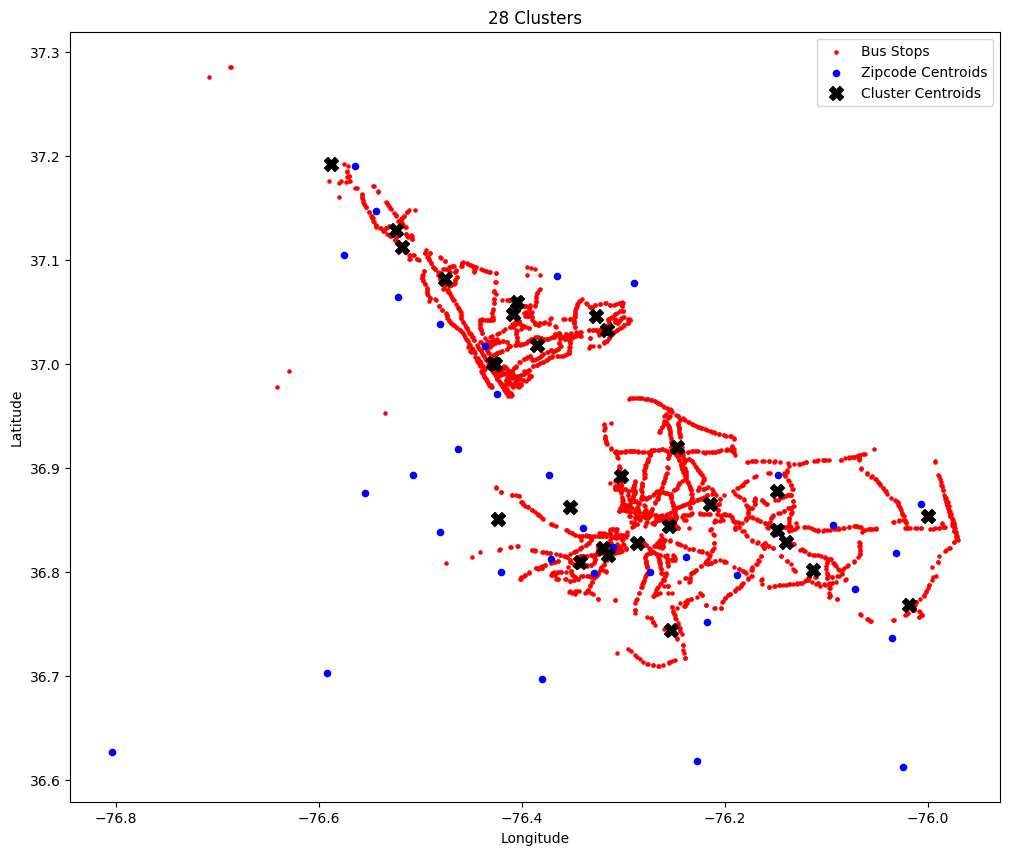

Inertia for k=29: 1057.3063252900556


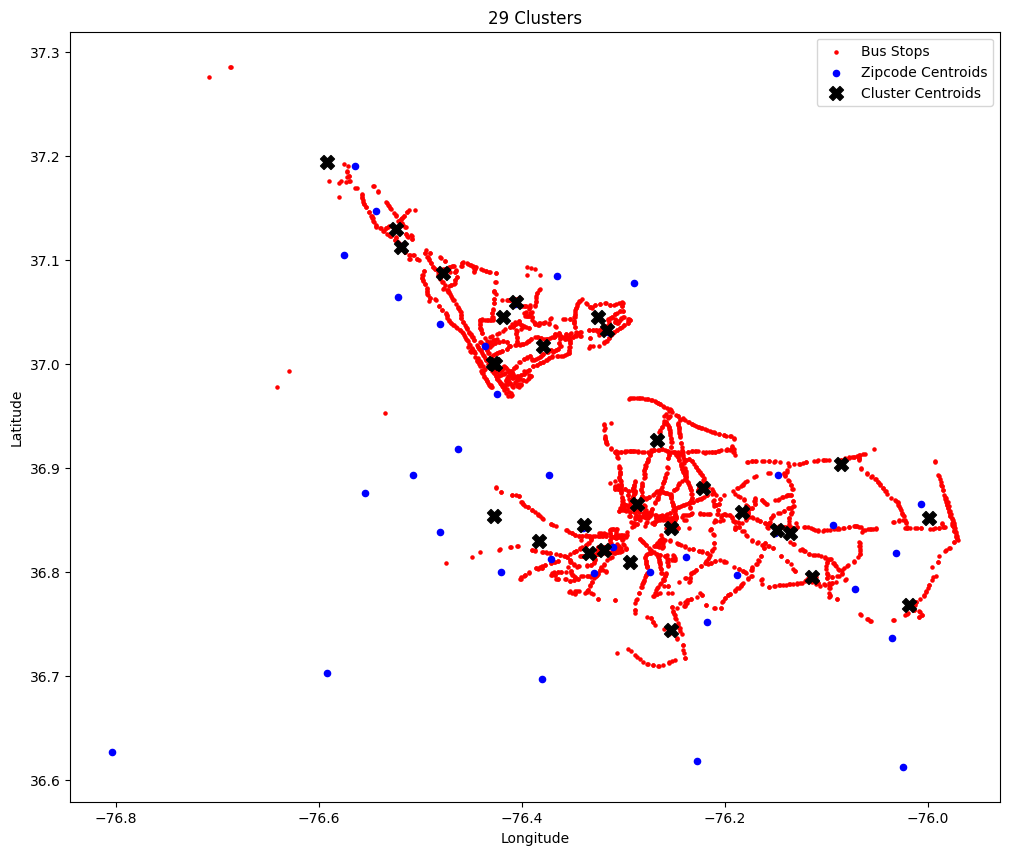

Inertia for k=30: 1013.3475705870296


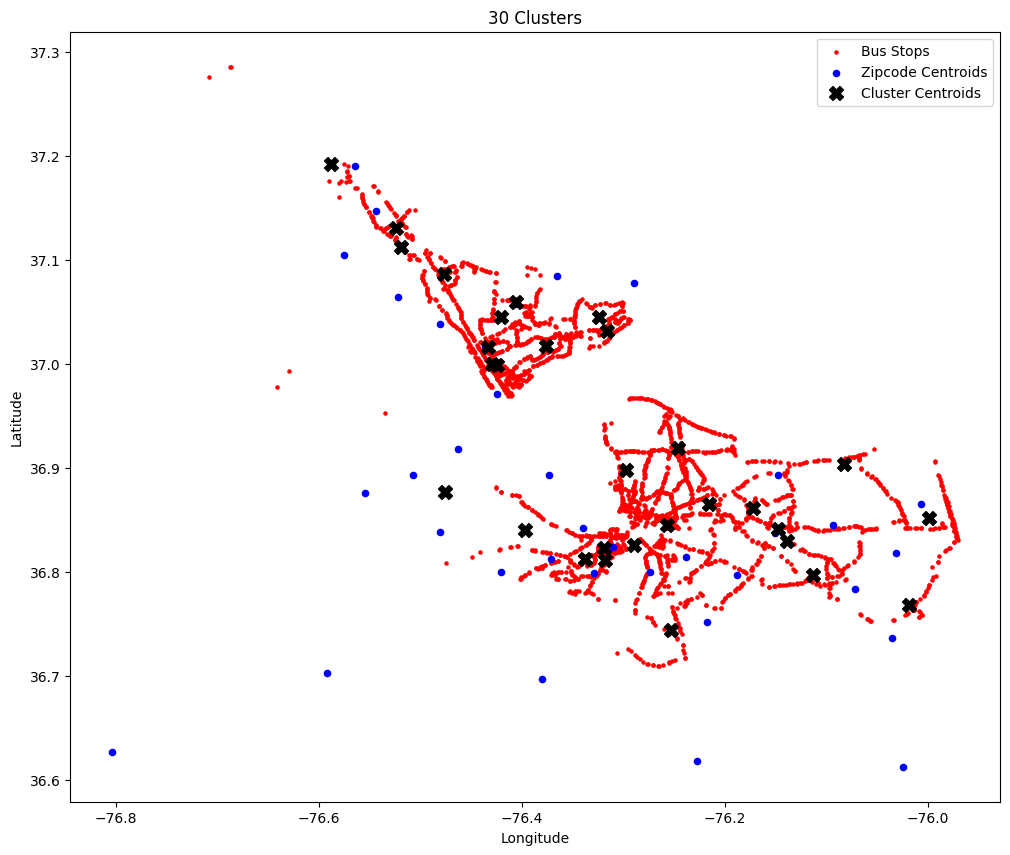

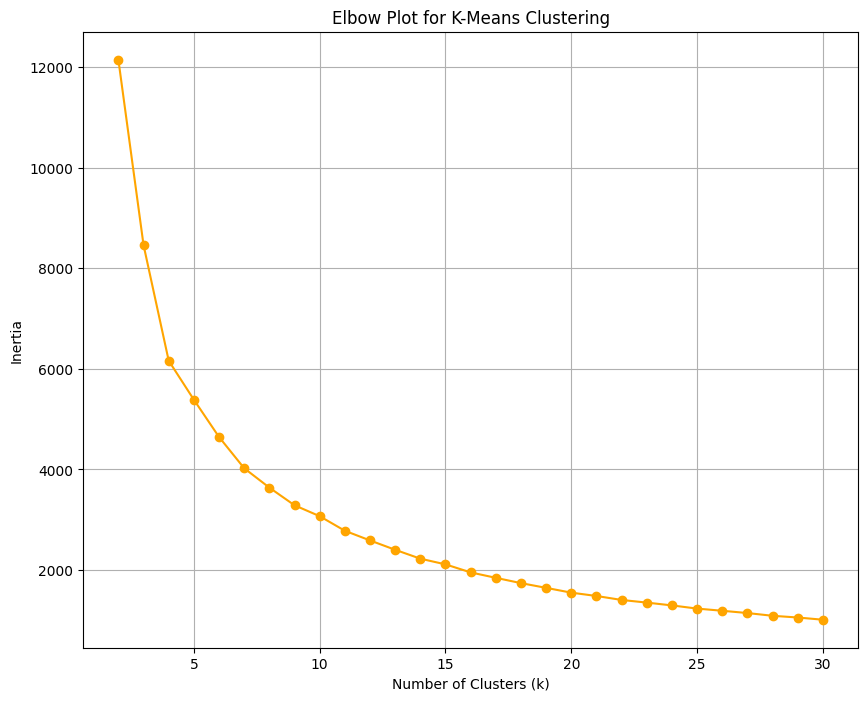

In [ ]:
X = np.array(data)
scaler = StandardScaler()

scaled_data = scaler.fit_transform(X)
show_data = np.array(data)

k_values = [i for i in range(2, 31)]
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)

    inertia_values.append(kmeans.inertia_)
    print(f"Inertia for k={k}: {kmeans.inertia_}")

    plt.figure(figsize=(12, 10))

    unscaled_centroids = np.array(scaler.inverse_transform(kmeans.cluster_centers_))
    plt.scatter(show_data[:, 1], show_data[:, 0], s=5, c='red', label="Bus Stops")
    plt.scatter(np.array(list(zipcode_data.values()))[:, -1], np.array(list(zipcode_data.values()))[:, -2], s=20, c='blue', label="Zipcode Centroids")
    plt.scatter(unscaled_centroids[:, 1], unscaled_centroids[:, 0], s=100, c='black', marker='X', label="Cluster Centroids")

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f"{k} Clusters")
    plt.legend()
    plt.show()


plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.grid(True)
plt.show()

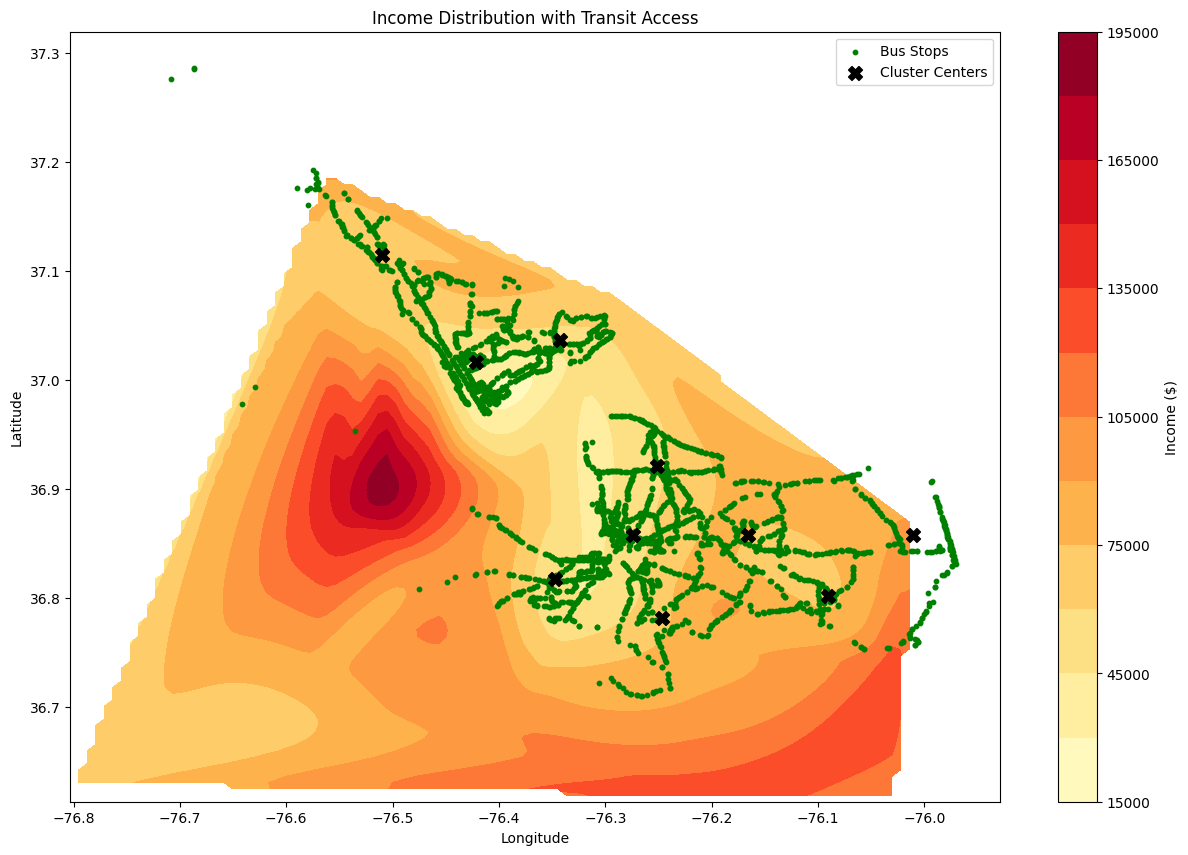

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import folium
from folium.plugins import HeatMap
from scipy.interpolate import griddata

def create_income_heatmap(bus_stops, zipcode_data, cluster_centers=None):

    sample_value = next(iter(zipcode_data.values()))
    num_columns = len(sample_value)
    columns = [f'feature_{i}' for i in range(num_columns-2)]
    columns.extend(['lat', 'lon'])  # added lat/lon as the last two columns

    zip_df = pd.DataFrame(zipcode_data.values(),
                         index=zipcode_data.keys(),
                         columns=columns)

    center_lat = np.mean(bus_stops['LATITUDE'])
    center_lon = np.mean(bus_stops['LONGITUDE'])
    m = folium.Map(location=[center_lat, center_lon],
                  zoom_start=11,
                  tiles='cartodbpositron')

    locations = zip_df[['lat', 'lon']].values.tolist()
    weights = zip_df['feature_0'].values.tolist()  # using first feature as weight
    HeatMap(locations, weights,
            min_opacity=0.4,
            radius=25,
            blur=15,
            max_zoom=1).add_to(m)

    for idx, row in bus_stops.iterrows():
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=3,
            color='red',
            fill=True,
            popup=f"Stop {idx}",  # using index as identifier
            weight=2
        ).add_to(m)

    if cluster_centers is not None:
        for idx, center in enumerate(cluster_centers):
            folium.CircleMarker(
                location=[center[0], center[1]],
                radius=8,
                color='black',
                fill=True,
                popup=f'Cluster {idx+1}',
                weight=2
            ).add_to(m)

    plt.figure(figsize=(15, 10))
    xi = np.linspace(min(zip_df['lon']), max(zip_df['lon']), 100)
    yi = np.linspace(min(zip_df['lat']), max(zip_df['lat']), 100)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata((zip_df['lon'], zip_df['lat']),
                 zip_df['feature_0'],  # using first feature for interpolation
                 (xi, yi),
                 method='cubic')

    # heatmap plot
    plt.contourf(xi, yi, zi, levels=15, cmap='YlOrRd')
    plt.colorbar(label='Income ($)')
    plt.scatter(bus_stops['LONGITUDE'], bus_stops['LATITUDE'],
               c='green', s=10, label='Bus Stops')

    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0],
                   c='black', s=100, marker='X', label='Cluster Centers')

    plt.title('Income Distribution with Transit Access')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    return m, plt

def analyze_income_distribution(bus_stops_df, zipcode_data, n_clusters=10):
    """
    Performs clustering and creates visualizations
    """
    X = np.array([[lat, lon] for lat, lon in
                 zip(bus_stops_df['LATITUDE'], bus_stops_df['LONGITUDE'])])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    interactive_map, static_plot = create_income_heatmap(
        bus_stops_df,
        zipcode_data,
        kmeans.cluster_centers_
    )
    return interactive_map, static_plot, kmeans

interactive_map, static_plot, kmeans = analyze_income_distribution(
    bus_stops,
    zipcode_data,
    n_clusters=10
)
interactive_map
plt.show()

<ipython-input-9-396480a693b6>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_stats = results_df.groupby('income_quintile').agg({



Correlation between income and transit access:
Spearman correlation: -0.549
p-value: 0.000

Gini coefficient for transit access: 0.778

Mean stops within walking distance by income quintile:
income_quintile
Q1    10.500000
Q2     3.285714
Q3     0.625000
Q4     1.285714
Q5     0.000000
Name: mean, dtype: float64


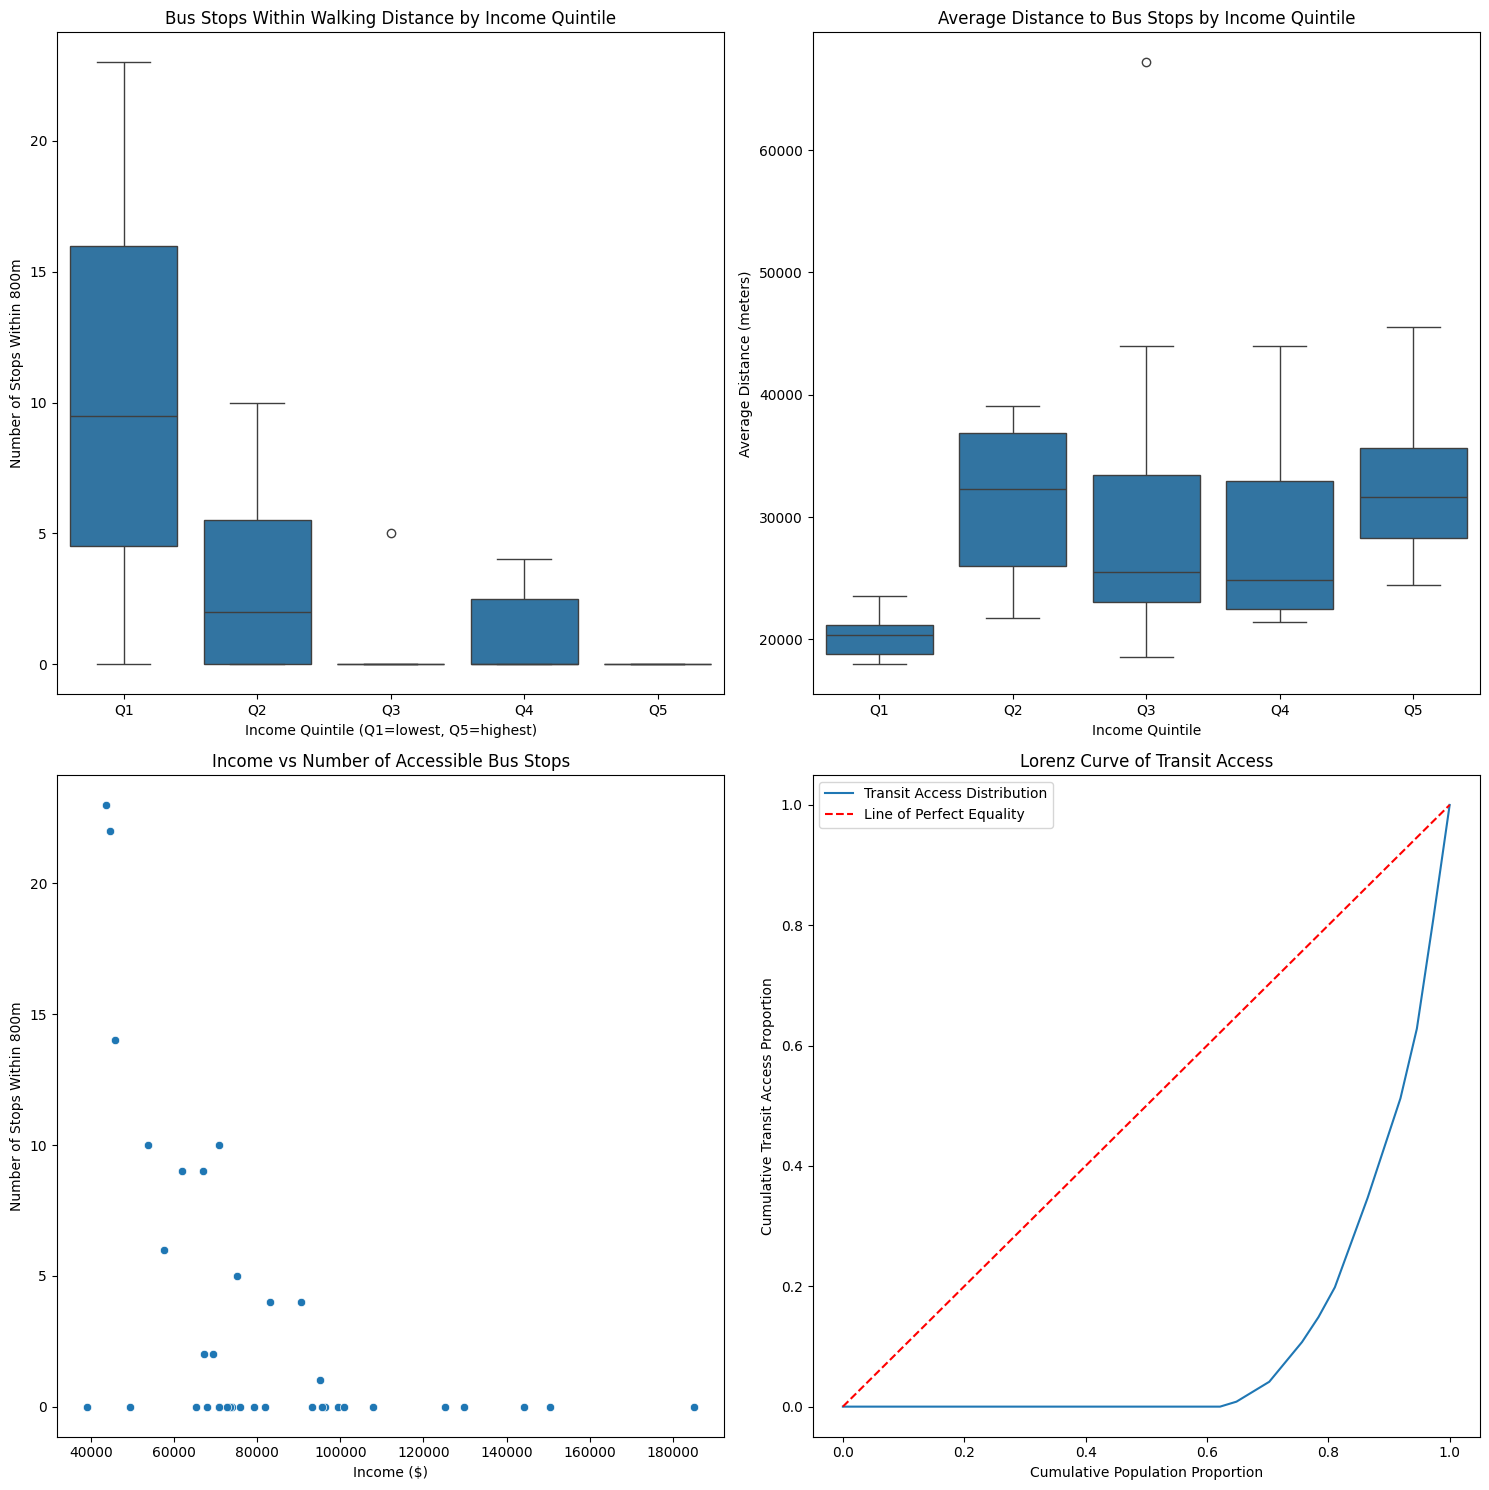

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def analyze_transit_inequality(bus_stops, zipcode_data, max_walking_dist=800):
    sample_value = next(iter(zipcode_data.values()))
    num_columns = len(sample_value)
    columns = [f'feature_{i}' for i in range(num_columns-2)]
    columns.extend(['lat', 'lon'])
    zip_df = pd.DataFrame(zipcode_data.values(),
                         index=zipcode_data.keys(),
                         columns=columns)

    results = []
    for idx, zip_row in zip_df.iterrows():
        zip_coord = np.array([[zip_row['lat'], zip_row['lon']]])
        bus_coords = bus_stops[['LATITUDE', 'LONGITUDE']].values

        distances = cdist(zip_coord, bus_coords, metric='euclidean') * 111000  # converted to meters
        stops_within_walking = np.sum(distances[0] <= max_walking_dist)
        avg_distance = np.mean(distances[0])
        nearest_stop = np.min(distances[0])

        results.append({
            'zipcode': idx,
            'income': zip_row['feature_0'],
            'stops_within_walking': stops_within_walking,
            'avg_distance_to_stops': avg_distance,
            'distance_to_nearest_stop': nearest_stop
        })

    results_df = pd.DataFrame(results)
    analysis = {}

    results_df['income_quintile'] = pd.qcut(results_df['income'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    quintile_stats = results_df.groupby('income_quintile').agg({
        'stops_within_walking': ['mean', 'median'],
        'avg_distance_to_stops': ['mean', 'median'],
        'distance_to_nearest_stop': ['mean', 'median']
    })
    analysis['quintile_stats'] = quintile_stats

    correlations = {
        'income_vs_stops': stats.spearmanr(results_df['income'], results_df['stops_within_walking']),
        'income_vs_avg_distance': stats.spearmanr(results_df['income'], results_df['avg_distance_to_stops']),
        'income_vs_nearest': stats.spearmanr(results_df['income'], results_df['distance_to_nearest_stop'])
    }
    analysis['correlations'] = correlations
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # stops within walking distance by income quintile
    sns.boxplot(data=results_df, x='income_quintile', y='stops_within_walking', ax=axes[0,0])
    axes[0,0].set_title('Bus Stops Within Walking Distance by Income Quintile')
    axes[0,0].set_xlabel('Income Quintile (Q1=lowest, Q5=highest)')
    axes[0,0].set_ylabel('Number of Stops Within 800m')

    # average distance to stops by income quintile
    sns.boxplot(data=results_df, x='income_quintile', y='avg_distance_to_stops', ax=axes[0,1])
    axes[0,1].set_title('Average Distance to Bus Stops by Income Quintile')
    axes[0,1].set_xlabel('Income Quintile')
    axes[0,1].set_ylabel('Average Distance (meters)')

    # income vs stops scatter plot
    sns.scatterplot(data=results_df, x='income', y='stops_within_walking', ax=axes[1,0])
    axes[1,0].set_title('Income vs Number of Accessible Bus Stops')
    axes[1,0].set_xlabel('Income ($)')
    axes[1,0].set_ylabel('Number of Stops Within 800m')

    # Lorenz curve (for transit access)
    results_df_sorted = results_df.sort_values('stops_within_walking')
    cum_stops = np.cumsum(results_df_sorted['stops_within_walking'])
    cum_stops_pct = cum_stops / cum_stops.max()
    population_pct = np.linspace(0, 1, len(cum_stops))

    axes[1,1].plot(population_pct, cum_stops_pct, label='Transit Access Distribution')
    axes[1,1].plot([0, 1], [0, 1], 'r--', label='Line of Perfect Equality')
    axes[1,1].set_title('Lorenz Curve of Transit Access')
    axes[1,1].set_xlabel('Cumulative Population Proportion')
    axes[1,1].set_ylabel('Cumulative Transit Access Proportion')
    axes[1,1].legend()

    plt.tight_layout()
    analysis['gini_coefficient'] = 1 - np.trapz(cum_stops_pct, population_pct) * 2
    return results_df, analysis, plt

results, analysis, plots = analyze_transit_inequality(bus_stops, zipcode_data)
print("\nCorrelation between income and transit access:")
print(f"Spearman correlation: {analysis['correlations']['income_vs_stops'][0]:.3f}")
print(f"p-value: {analysis['correlations']['income_vs_stops'][1]:.3f}")
print(f"\nGini coefficient for transit access: {analysis['gini_coefficient']:.3f}")
print("\nMean stops within walking distance by income quintile:")
print(analysis['quintile_stats']['stops_within_walking']['mean'])
plots.show()

Notes:

The first 3 graphs basically show that there are less stops w higher income areas.

The Lorenz curve's shape (blue line) indicates that a only small portion of the population has access to most of the bus stops. The evident large gap from the line of perfect equality suggests high transit inequality.

NOTE:  EVERYTHING BELOW IS LEGACY CODE

We kept it since it had lots of useful graphs that had some helpful visualizations that we didn't have time to recreate with the above work but it is an outdated version of our current code.

In [ ]:
# @title Default title text
import re
#zip codes
ztca = ["ZCTA5 23320!!Households!!Estimate","ZCTA5 23320!!Households!!Margin of Error","ZCTA5 23320!!Families!!Estimate","ZCTA5 23320!!Families!!Margin of Error","ZCTA5 23320!!Married-couple families!!Estimate","ZCTA5 23320!!Married-couple families!!Margin of Error","ZCTA5 23320!!Nonfamily households!!Estimate","ZCTA5 23320!!Nonfamily households!!Margin of Error","ZCTA5 23321!!Households!!Estimate","ZCTA5 23321!!Households!!Margin of Error","ZCTA5 23321!!Families!!Estimate","ZCTA5 23321!!Families!!Margin of Error","ZCTA5 23321!!Married-couple families!!Estimate","ZCTA5 23321!!Married-couple families!!Margin of Error","ZCTA5 23321!!Nonfamily households!!Estimate","ZCTA5 23321!!Nonfamily households!!Margin of Error","ZCTA5 23322!!Households!!Estimate","ZCTA5 23322!!Households!!Margin of Error","ZCTA5 23322!!Families!!Estimate","ZCTA5 23322!!Families!!Margin of Error","ZCTA5 23322!!Married-couple families!!Estimate","ZCTA5 23322!!Married-couple families!!Margin of Error","ZCTA5 23322!!Nonfamily households!!Estimate","ZCTA5 23322!!Nonfamily households!!Margin of Error","ZCTA5 23323!!Households!!Estimate","ZCTA5 23323!!Households!!Margin of Error","ZCTA5 23323!!Families!!Estimate","ZCTA5 23323!!Families!!Margin of Error","ZCTA5 23323!!Married-couple families!!Estimate","ZCTA5 23323!!Married-couple families!!Margin of Error","ZCTA5 23323!!Nonfamily households!!Estimate","ZCTA5 23323!!Nonfamily households!!Margin of Error","ZCTA5 23324!!Households!!Estimate","ZCTA5 23324!!Households!!Margin of Error","ZCTA5 23324!!Families!!Estimate","ZCTA5 23324!!Families!!Margin of Error","ZCTA5 23324!!Married-couple families!!Estimate","ZCTA5 23324!!Married-couple families!!Margin of Error","ZCTA5 23324!!Nonfamily households!!Estimate","ZCTA5 23324!!Nonfamily households!!Margin of Error","ZCTA5 23325!!Households!!Estimate","ZCTA5 23325!!Households!!Margin of Error","ZCTA5 23325!!Families!!Estimate","ZCTA5 23325!!Families!!Margin of Error","ZCTA5 23325!!Married-couple families!!Estimate","ZCTA5 23325!!Married-couple families!!Margin of Error","ZCTA5 23325!!Nonfamily households!!Estimate","ZCTA5 23325!!Nonfamily households!!Margin of Error","ZCTA5 23432!!Households!!Estimate","ZCTA5 23432!!Households!!Margin of Error","ZCTA5 23432!!Families!!Estimate","ZCTA5 23432!!Families!!Margin of Error","ZCTA5 23432!!Married-couple families!!Estimate","ZCTA5 23432!!Married-couple families!!Margin of Error","ZCTA5 23432!!Nonfamily households!!Estimate","ZCTA5 23432!!Nonfamily households!!Margin of Error","ZCTA5 23433!!Households!!Estimate","ZCTA5 23433!!Households!!Margin of Error","ZCTA5 23433!!Families!!Estimate","ZCTA5 23433!!Families!!Margin of Error","ZCTA5 23433!!Married-couple families!!Estimate","ZCTA5 23433!!Married-couple families!!Margin of Error","ZCTA5 23433!!Nonfamily households!!Estimate","ZCTA5 23433!!Nonfamily households!!Margin of Error","ZCTA5 23434!!Households!!Estimate","ZCTA5 23434!!Households!!Margin of Error","ZCTA5 23434!!Families!!Estimate","ZCTA5 23434!!Families!!Margin of Error","ZCTA5 23434!!Married-couple families!!Estimate","ZCTA5 23434!!Married-couple families!!Margin of Error","ZCTA5 23434!!Nonfamily households!!Estimate","ZCTA5 23434!!Nonfamily households!!Margin of Error","ZCTA5 23435!!Households!!Estimate","ZCTA5 23435!!Households!!Margin of Error","ZCTA5 23435!!Families!!Estimate","ZCTA5 23435!!Families!!Margin of Error","ZCTA5 23435!!Married-couple families!!Estimate","ZCTA5 23435!!Married-couple families!!Margin of Error","ZCTA5 23435!!Nonfamily households!!Estimate","ZCTA5 23435!!Nonfamily households!!Margin of Error","ZCTA5 23436!!Households!!Estimate","ZCTA5 23436!!Households!!Margin of Error","ZCTA5 23436!!Families!!Estimate","ZCTA5 23436!!Families!!Margin of Error","ZCTA5 23436!!Married-couple families!!Estimate","ZCTA5 23436!!Married-couple families!!Margin of Error","ZCTA5 23436!!Nonfamily households!!Estimate","ZCTA5 23436!!Nonfamily households!!Margin of Error","ZCTA5 23437!!Households!!Estimate","ZCTA5 23437!!Households!!Margin of Error","ZCTA5 23437!!Families!!Estimate","ZCTA5 23437!!Families!!Margin of Error","ZCTA5 23437!!Married-couple families!!Estimate","ZCTA5 23437!!Married-couple families!!Margin of Error","ZCTA5 23437!!Nonfamily households!!Estimate","ZCTA5 23437!!Nonfamily households!!Margin of Error","ZCTA5 23451!!Households!!Estimate","ZCTA5 23451!!Households!!Margin of Error","ZCTA5 23451!!Families!!Estimate","ZCTA5 23451!!Families!!Margin of Error","ZCTA5 23451!!Married-couple families!!Estimate","ZCTA5 23451!!Married-couple families!!Margin of Error","ZCTA5 23451!!Nonfamily households!!Estimate","ZCTA5 23451!!Nonfamily households!!Margin of Error","ZCTA5 23452!!Households!!Estimate","ZCTA5 23452!!Households!!Margin of Error","ZCTA5 23452!!Families!!Estimate","ZCTA5 23452!!Families!!Margin of Error","ZCTA5 23452!!Married-couple families!!Estimate","ZCTA5 23452!!Married-couple families!!Margin of Error","ZCTA5 23452!!Nonfamily households!!Estimate","ZCTA5 23452!!Nonfamily households!!Margin of Error","ZCTA5 23453!!Households!!Estimate","ZCTA5 23453!!Households!!Margin of Error","ZCTA5 23453!!Families!!Estimate","ZCTA5 23453!!Families!!Margin of Error","ZCTA5 23453!!Married-couple families!!Estimate","ZCTA5 23453!!Married-couple families!!Margin of Error","ZCTA5 23453!!Nonfamily households!!Estimate","ZCTA5 23453!!Nonfamily households!!Margin of Error","ZCTA5 23454!!Households!!Estimate","ZCTA5 23454!!Households!!Margin of Error","ZCTA5 23454!!Families!!Estimate","ZCTA5 23454!!Families!!Margin of Error","ZCTA5 23454!!Married-couple families!!Estimate","ZCTA5 23454!!Married-couple families!!Margin of Error","ZCTA5 23454!!Nonfamily households!!Estimate","ZCTA5 23454!!Nonfamily households!!Margin of Error","ZCTA5 23455!!Households!!Estimate","ZCTA5 23455!!Households!!Margin of Error","ZCTA5 23455!!Families!!Estimate","ZCTA5 23455!!Families!!Margin of Error","ZCTA5 23455!!Married-couple families!!Estimate","ZCTA5 23455!!Married-couple families!!Margin of Error","ZCTA5 23455!!Nonfamily households!!Estimate","ZCTA5 23455!!Nonfamily households!!Margin of Error","ZCTA5 23456!!Households!!Estimate","ZCTA5 23456!!Households!!Margin of Error","ZCTA5 23456!!Families!!Estimate","ZCTA5 23456!!Families!!Margin of Error","ZCTA5 23456!!Married-couple families!!Estimate","ZCTA5 23456!!Married-couple families!!Margin of Error","ZCTA5 23456!!Nonfamily households!!Estimate","ZCTA5 23456!!Nonfamily households!!Margin of Error","ZCTA5 23457!!Households!!Estimate","ZCTA5 23457!!Households!!Margin of Error","ZCTA5 23457!!Families!!Estimate","ZCTA5 23457!!Families!!Margin of Error","ZCTA5 23457!!Married-couple families!!Estimate","ZCTA5 23457!!Married-couple families!!Margin of Error","ZCTA5 23457!!Nonfamily households!!Estimate","ZCTA5 23457!!Nonfamily households!!Margin of Error","ZCTA5 23459!!Households!!Estimate","ZCTA5 23459!!Households!!Margin of Error","ZCTA5 23459!!Families!!Estimate","ZCTA5 23459!!Families!!Margin of Error","ZCTA5 23459!!Married-couple families!!Estimate","ZCTA5 23459!!Married-couple families!!Margin of Error","ZCTA5 23459!!Nonfamily households!!Estimate","ZCTA5 23459!!Nonfamily households!!Margin of Error","ZCTA5 23460!!Households!!Estimate","ZCTA5 23460!!Households!!Margin of Error","ZCTA5 23460!!Families!!Estimate","ZCTA5 23460!!Families!!Margin of Error","ZCTA5 23460!!Married-couple families!!Estimate","ZCTA5 23460!!Married-couple families!!Margin of Error","ZCTA5 23460!!Nonfamily households!!Estimate","ZCTA5 23460!!Nonfamily households!!Margin of Error","ZCTA5 23461!!Households!!Estimate","ZCTA5 23461!!Households!!Margin of Error","ZCTA5 23461!!Families!!Estimate","ZCTA5 23461!!Families!!Margin of Error","ZCTA5 23461!!Married-couple families!!Estimate","ZCTA5 23461!!Married-couple families!!Margin of Error","ZCTA5 23461!!Nonfamily households!!Estimate","ZCTA5 23461!!Nonfamily households!!Margin of Error","ZCTA5 23462!!Households!!Estimate","ZCTA5 23462!!Households!!Margin of Error","ZCTA5 23462!!Families!!Estimate","ZCTA5 23462!!Families!!Margin of Error","ZCTA5 23462!!Married-couple families!!Estimate","ZCTA5 23462!!Married-couple families!!Margin of Error","ZCTA5 23462!!Nonfamily households!!Estimate","ZCTA5 23462!!Nonfamily households!!Margin of Error","ZCTA5 23464!!Households!!Estimate","ZCTA5 23464!!Households!!Margin of Error","ZCTA5 23464!!Families!!Estimate","ZCTA5 23464!!Families!!Margin of Error","ZCTA5 23464!!Married-couple families!!Estimate","ZCTA5 23464!!Married-couple families!!Margin of Error","ZCTA5 23464!!Nonfamily households!!Estimate","ZCTA5 23464!!Nonfamily households!!Margin of Error","ZCTA5 23601!!Households!!Estimate","ZCTA5 23601!!Households!!Margin of Error","ZCTA5 23601!!Families!!Estimate","ZCTA5 23601!!Families!!Margin of Error","ZCTA5 23601!!Married-couple families!!Estimate","ZCTA5 23601!!Married-couple families!!Margin of Error","ZCTA5 23601!!Nonfamily households!!Estimate","ZCTA5 23601!!Nonfamily households!!Margin of Error","ZCTA5 23602!!Households!!Estimate","ZCTA5 23602!!Households!!Margin of Error","ZCTA5 23602!!Families!!Estimate","ZCTA5 23602!!Families!!Margin of Error","ZCTA5 23602!!Married-couple families!!Estimate","ZCTA5 23602!!Married-couple families!!Margin of Error","ZCTA5 23602!!Nonfamily households!!Estimate","ZCTA5 23602!!Nonfamily households!!Margin of Error","ZCTA5 23603!!Households!!Estimate","ZCTA5 23603!!Households!!Margin of Error","ZCTA5 23603!!Families!!Estimate","ZCTA5 23603!!Families!!Margin of Error","ZCTA5 23603!!Married-couple families!!Estimate","ZCTA5 23603!!Married-couple families!!Margin of Error","ZCTA5 23603!!Nonfamily households!!Estimate","ZCTA5 23603!!Nonfamily households!!Margin of Error","ZCTA5 23604!!Households!!Estimate","ZCTA5 23604!!Households!!Margin of Error","ZCTA5 23604!!Families!!Estimate","ZCTA5 23604!!Families!!Margin of Error","ZCTA5 23604!!Married-couple families!!Estimate","ZCTA5 23604!!Married-couple families!!Margin of Error","ZCTA5 23604!!Nonfamily households!!Estimate","ZCTA5 23604!!Nonfamily households!!Margin of Error","ZCTA5 23605!!Households!!Estimate","ZCTA5 23605!!Households!!Margin of Error","ZCTA5 23605!!Families!!Estimate","ZCTA5 23605!!Families!!Margin of Error","ZCTA5 23605!!Married-couple families!!Estimate","ZCTA5 23605!!Married-couple families!!Margin of Error","ZCTA5 23605!!Nonfamily households!!Estimate","ZCTA5 23605!!Nonfamily households!!Margin of Error","ZCTA5 23606!!Households!!Estimate","ZCTA5 23606!!Households!!Margin of Error","ZCTA5 23606!!Families!!Estimate","ZCTA5 23606!!Families!!Margin of Error","ZCTA5 23606!!Married-couple families!!Estimate","ZCTA5 23606!!Married-couple families!!Margin of Error","ZCTA5 23606!!Nonfamily households!!Estimate","ZCTA5 23606!!Nonfamily households!!Margin of Error","ZCTA5 23607!!Households!!Estimate","ZCTA5 23607!!Households!!Margin of Error","ZCTA5 23607!!Families!!Estimate","ZCTA5 23607!!Families!!Margin of Error","ZCTA5 23607!!Married-couple families!!Estimate","ZCTA5 23607!!Married-couple families!!Margin of Error","ZCTA5 23607!!Nonfamily households!!Estimate","ZCTA5 23607!!Nonfamily households!!Margin of Error","ZCTA5 23608!!Households!!Estimate","ZCTA5 23608!!Households!!Margin of Error","ZCTA5 23608!!Families!!Estimate","ZCTA5 23608!!Families!!Margin of Error","ZCTA5 23608!!Married-couple families!!Estimate","ZCTA5 23608!!Married-couple families!!Margin of Error","ZCTA5 23608!!Nonfamily households!!Estimate","ZCTA5 23608!!Nonfamily households!!Margin of Error","ZCTA5 23663!!Households!!Estimate","ZCTA5 23663!!Households!!Margin of Error","ZCTA5 23663!!Families!!Estimate","ZCTA5 23663!!Families!!Margin of Error","ZCTA5 23663!!Married-couple families!!Estimate","ZCTA5 23663!!Married-couple families!!Margin of Error","ZCTA5 23663!!Nonfamily households!!Estimate","ZCTA5 23663!!Nonfamily households!!Margin of Error","ZCTA5 23664!!Households!!Estimate","ZCTA5 23664!!Households!!Margin of Error","ZCTA5 23664!!Families!!Estimate","ZCTA5 23664!!Families!!Margin of Error","ZCTA5 23664!!Married-couple families!!Estimate","ZCTA5 23664!!Married-couple families!!Margin of Error","ZCTA5 23664!!Nonfamily households!!Estimate","ZCTA5 23664!!Nonfamily households!!Margin of Error","ZCTA5 23665!!Households!!Estimate","ZCTA5 23665!!Households!!Margin of Error","ZCTA5 23665!!Families!!Estimate","ZCTA5 23665!!Families!!Margin of Error","ZCTA5 23665!!Married-couple families!!Estimate","ZCTA5 23665!!Married-couple families!!Margin of Error","ZCTA5 23665!!Nonfamily households!!Estimate","ZCTA5 23665!!Nonfamily households!!Margin of Error","ZCTA5 23666!!Households!!Estimate","ZCTA5 23666!!Households!!Margin of Error","ZCTA5 23666!!Families!!Estimate","ZCTA5 23666!!Families!!Margin of Error","ZCTA5 23666!!Married-couple families!!Estimate","ZCTA5 23666!!Married-couple families!!Margin of Error","ZCTA5 23666!!Nonfamily households!!Estimate","ZCTA5 23666!!Nonfamily households!!Margin of Error","ZCTA5 23701!!Households!!Estimate","ZCTA5 23701!!Households!!Margin of Error","ZCTA5 23701!!Families!!Estimate","ZCTA5 23701!!Families!!Margin of Error","ZCTA5 23701!!Married-couple families!!Estimate","ZCTA5 23701!!Married-couple families!!Margin of Error","ZCTA5 23701!!Nonfamily households!!Estimate","ZCTA5 23701!!Nonfamily households!!Margin of Error","ZCTA5 23702!!Households!!Estimate","ZCTA5 23702!!Households!!Margin of Error","ZCTA5 23702!!Families!!Estimate","ZCTA5 23702!!Families!!Margin of Error","ZCTA5 23702!!Married-couple families!!Estimate","ZCTA5 23702!!Married-couple families!!Margin of Error","ZCTA5 23702!!Nonfamily households!!Estimate","ZCTA5 23702!!Nonfamily households!!Margin of Error","ZCTA5 23703!!Households!!Estimate","ZCTA5 23703!!Households!!Margin of Error","ZCTA5 23703!!Families!!Estimate","ZCTA5 23703!!Families!!Margin of Error","ZCTA5 23703!!Married-couple families!!Estimate","ZCTA5 23703!!Married-couple families!!Margin of Error","ZCTA5 23703!!Nonfamily households!!Estimate","ZCTA5 23703!!Nonfamily households!!Margin of Error","ZCTA5 23704!!Households!!Estimate","ZCTA5 23704!!Households!!Margin of Error","ZCTA5 23704!!Families!!Estimate","ZCTA5 23704!!Families!!Margin of Error","ZCTA5 23704!!Married-couple families!!Estimate","ZCTA5 23704!!Married-couple families!!Margin of Error","ZCTA5 23704!!Nonfamily households!!Estimate","ZCTA5 23704!!Nonfamily households!!Margin of Error","ZCTA5 23707!!Households!!Estimate","ZCTA5 23707!!Households!!Margin of Error","ZCTA5 23707!!Families!!Estimate","ZCTA5 23707!!Families!!Margin of Error","ZCTA5 23707!!Married-couple families!!Estimate","ZCTA5 23707!!Married-couple families!!Margin of Error","ZCTA5 23707!!Nonfamily households!!Estimate","ZCTA5 23707!!Nonfamily households!!Margin of Error"
]

#mean incomes
incomes = ["100,660","±4,701","117,938","±6,837","N","N","65,200","±3,802","121,351","±6,932","136,009","±9,095","N","N","68,120","±7,729","148,349","±6,126","162,767","±6,471","N","N","72,971","±6,732","117,709","±8,474","131,353","±10,073","N","N","65,948","±9,320","76,508","±6,510","90,456","±9,297","N","N","40,171","±4,660","87,323","±7,031","98,440","±9,399","N","N","60,178","±5,131","167,850","±50,163","197,941","±58,490","N","N","58,088","±42,371","238,974","±62,246","261,630","±77,075","N","N","131,456","±72,693","93,623","±4,501","106,638","±5,783","N","N","57,744","±7,217","134,338","±9,602","148,871","±8,171","N","N","96,269","±26,497","231,820","±76,447","291,292","±86,941","N","N","55,264","±19,252","87,265","±7,719","101,256","±10,242","N","N","55,685","±10,553","136,673","±5,987","173,037","±10,067","N","N","92,746","±7,139","110,980","±8,530","131,195","±11,682","N","N","67,205","±7,619","95,447","±5,167","105,400","±6,079","123,157","±7,878","64,458","±7,657","119,364","±6,452","140,052","±9,923","N","N","74,616","±4,701","108,310","±4,630","124,864","±6,433","N","N","74,708","±6,528","150,363","±7,031","159,691","±7,859","N","N","81,677","±9,538","117,598","±21,070","132,418","±24,730","N","N","53,384","±12,349","-","**","-","**","-","**","-","**","-","**","-","**","-","**","-","**","-","**","-","**","-","**","-","**","82,642","±3,672","88,576","±4,600","106,186","±5,902","67,526","±5,414","108,999","±3,154","121,010","±3,750","N","N","70,139","±5,227","86,512","±7,719","104,081","±12,978","N","N","61,459","±7,379","105,834","±18,289","102,175","±5,770","N","N","107,342","±46,001","100,070","±14,786","117,840","±19,923","N","N","61,083","±15,668","79,712","±8,580","77,901","±8,642","N","N","55,806","±30,177","55,739","±4,002","69,493","±6,638","N","N","39,371","±4,033","91,138","±4,419","115,057","±8,303","N","N","61,978","±4,747","49,308","±3,929","57,059","±5,257","N","N","35,306","±4,350","79,210","±3,666","90,820","±5,123","N","N","55,438","±5,434","70,287","±5,532","78,614","±7,829","N","N","55,290","±6,603","98,958","±17,493","115,944","±25,669","N","N","62,715","±8,965","83,567","±7,717","83,193","±7,796","N","N","94,360","±48,777","82,851","±4,011","98,876","±5,734","N","N","54,329","±3,402","77,065","±5,074","79,959","±5,902","N","N","65,944","±9,655","54,555","±4,318","58,159","±5,432","N","N","45,542","±8,081","96,012","±9,598","108,292","±14,204","N","N","65,512","±10,702","61,325","±4,851","74,657","±9,696","N","N","45,055","±6,476","68,842","±7,325","84,558","±12,457","N","N","46,430","±6,164"]


income_data = []


for i in range(0, len(ztca), 8):
  zipcode = int(re.search(r'\b\d{5}\b', ztca[i]).group())
  income = incomes[i]
  if income != "-":
    cleaned_number = income.replace(',', '')
    income = int(cleaned_number)
    income_data.append((zipcode, income))
  else:
    continue;

zip_df = pd.read_csv("zipcode_coords.csv")

zip_dict = dict(zip(zip_df['ZIP'], zip_df[['LAT', 'LNG']].values))

updated_income_data = []

for zipcode, income in income_data:
    if zipcode in zip_dict:
        lat, lng = zip_dict[zipcode]
        updated_income_data.append((zipcode, income, lat, lng))

 cx
 wrgw


In [ ]:
updated_income_df = pd.DataFrame(updated_income_data, columns=['zipcode', 'income', 'latitude', 'longitude'])
income_gdf = gpd.GeoDataFrame(updated_income_df, geometry=gpd.GeoSeries.from_xy(updated_income_df['longitude'], updated_income_df['latitude']))
income_gdf = income_gdf.set_crs('EPSG:4326')
bus_stops_gdf = bus_stops_gdf.set_crs('EPSG:4326')


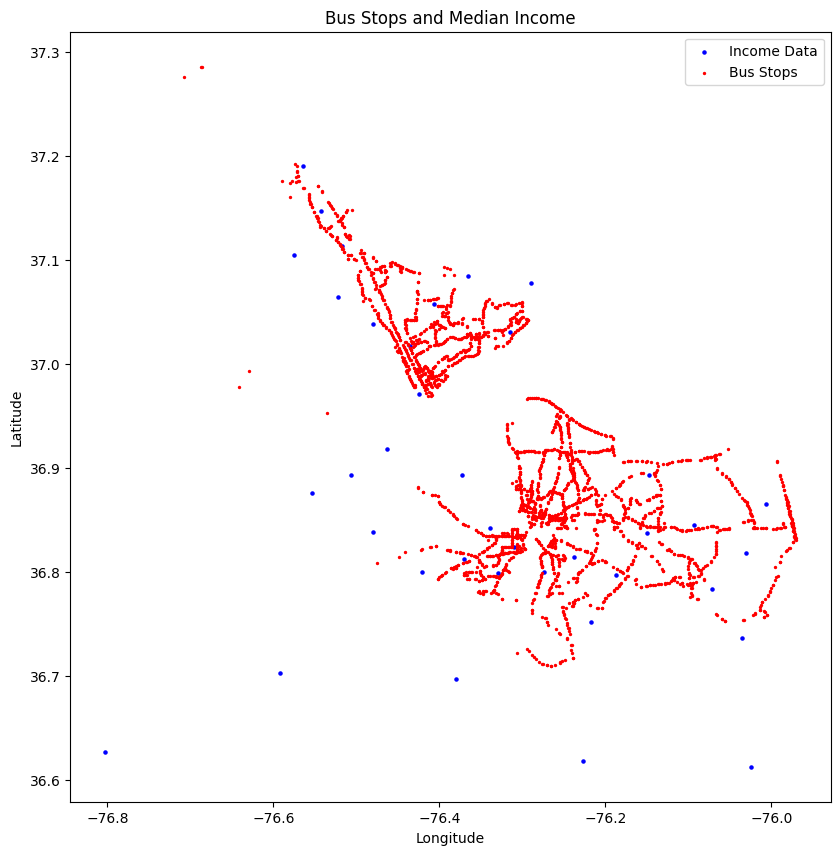

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
income_gdf.plot(ax=ax, color='blue', markersize=5, label='Income Data')
bus_stops_gdf.plot(ax=ax, color='red', markersize=2, label='Bus Stops')
ax.set_title("Bus Stops and Median Income")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [ ]:
def calculate_nearest_distances(income_gdf, bus_stops_gdf):

    projected_income_gdf = income_gdf.to_crs(epsg=3857)
    projected_bus_stops_gdf = bus_stops_gdf.to_crs(epsg=3857)

    distances = []
    for _, income_point in projected_income_gdf.iterrows():
        bus_stop_distances = projected_bus_stops_gdf.distance(income_point.geometry)
        min_distance = bus_stop_distances.min()
        distances.append(min_distance)
    return distances

income_gdf['nearest_bus_stop_dist'] = calculate_nearest_distances(income_gdf, bus_stops_gdf)

income_gdf


zipcode  income   latitude  longitude                    geometry  \
0     23320  100660  36.751734 -76.217637  POINT (-76.21764 36.75173)   
1     23321  121351  36.800209 -76.420759  POINT (-76.42076 36.80021)   
2     23322  148349  36.618712 -76.227046  POINT (-76.22705 36.61871)   
3     23323  117709  36.696963 -76.379928  POINT (-76.37993 36.69696)   
4     23324   76508  36.799721 -76.273447  POINT (-76.27345 36.79972)   
5     23325   87323  36.814548 -76.238429  POINT (-76.23843 36.81455)   
6     23432  167850  36.876452 -76.553978  POINT (-76.55398 36.87645)   
7     23433  238974  36.918069 -76.462863  POINT (-76.46286 36.91807)   
8     23434   93623  36.703003 -76.592105     POINT (-76.5921 36.703)   
9     23435  134338  36.838420 -76.480264  POINT (-76.48026 36.83842)   
10    23436  231820  36.893751 -76.506926  POINT (-76.50693 36.89375)   
11    23437   87265  36.627115 -76.803197   POINT (-76.8032 36.62712)   
12    23451  136673  36.865027 -76.006188  POINT (-76.00619 36.86503)   
13    23452  110980  36.845756 -76.092807  POINT (-76.09281 36.84576)   
14    23453   95447  36.783649 -76.071784  POINT (-76.07178 36.78365)   
15    23454  119364  36.818062 -76.030835  POINT (-76.03084 36.81806)   
16    23455  108310  36.892997 -76.147108    POINT (-76.14711 36.893)   
17    23456  150363  36.736543 -76.035469  POINT (-76.03547 36.73654)   
18    23457  117598  36.612747 -76.024139  POINT (-76.02414 36.61275)   
19    23462   82642  36.837313 -76.150514  POINT (-76.15051 36.83731)   
20    23464  108999  36.797023 -76.187680  POINT (-76.18768 36.79702)   
21    23601   86512  37.038265 -76.480498   POINT (-76.4805 37.03826)   
22    23602  105834  37.113416 -76.517947  POINT (-76.51795 37.11342)   
23    23603  100070  37.191057 -76.564535  POINT (-76.56454 37.19106)   
24    23604   79712  37.105026 -76.574793  POINT (-76.57479 37.10503)   
25    23605   55739  37.017949 -76.435781  POINT (-76.43578 37.01795)   
26    23606   91138  37.064408 -76.521638  POINT (-76.52164 37.06441)   
27    23607   49308  36.971747 -76.424372  POINT (-76.42437 36.97175)   
28    23608   79210  37.147813 -76.543036  POINT (-76.54304 37.14781)   
29    23663   70287  37.031007 -76.315244  POINT (-76.31524 37.03101)   
30    23664   98958  37.078374 -76.289825  POINT (-76.28982 37.07837)   
31    23665   83567  37.084498 -76.365498    POINT (-76.3655 37.0845)   
32    23666   82851  37.058141 -76.406646  POINT (-76.40665 37.05814)   
33    23701   77065  36.812940 -76.371005    POINT (-76.371 36.81294)   
34    23702   54555  36.799047 -76.328977  POINT (-76.32898 36.79905)   
35    23703   96012  36.893339 -76.373292  POINT (-76.37329 36.89334)   
36    23704   61325  36.824187 -76.310161  POINT (-76.31016 36.82419)   
37    23707   68842  36.842301 -76.339628   POINT (-76.33963 36.8423)   

    nearest_bus_stop_dist  
0             2066.369308  
1             2320.052908  
2            13333.020282  
3             8930.532029  
4              365.981863  
5             1189.746038  
6            10863.986328  
7             6487.885461  
8            19633.990326  
9             4214.357808  
10            8821.548703  
11           44401.506741  
12            2373.974586  
13             609.974195  
14            1618.333590  
15            3555.424692  
16             680.270977  
17            2447.355617  
18           19642.226756  
19             872.573485  
20             811.601790  
21            1100.947859  
22             108.545044  
23             786.497549  
24            5152.136305  
25             211.512287  
26            3241.067564  
27             912.884141  
28             865.392303  
29             537.817930  
30            2914.165386  
31            1860.061902  
32             586.803500  
33             575.418040  
34             413.416159  
35            4286.405664  
36             319.441721  
37            1019.835176

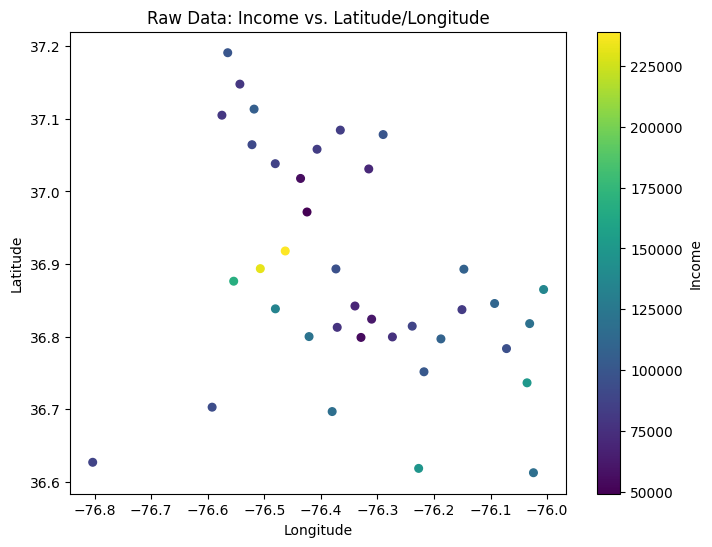

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(income_gdf['longitude'], income_gdf['latitude'], c=income_gdf['income'], cmap='viridis', s=30)
plt.title("Raw Data: Income vs. Latitude/Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Income")
plt.show()

SSE for k=2: 16.24801591104255


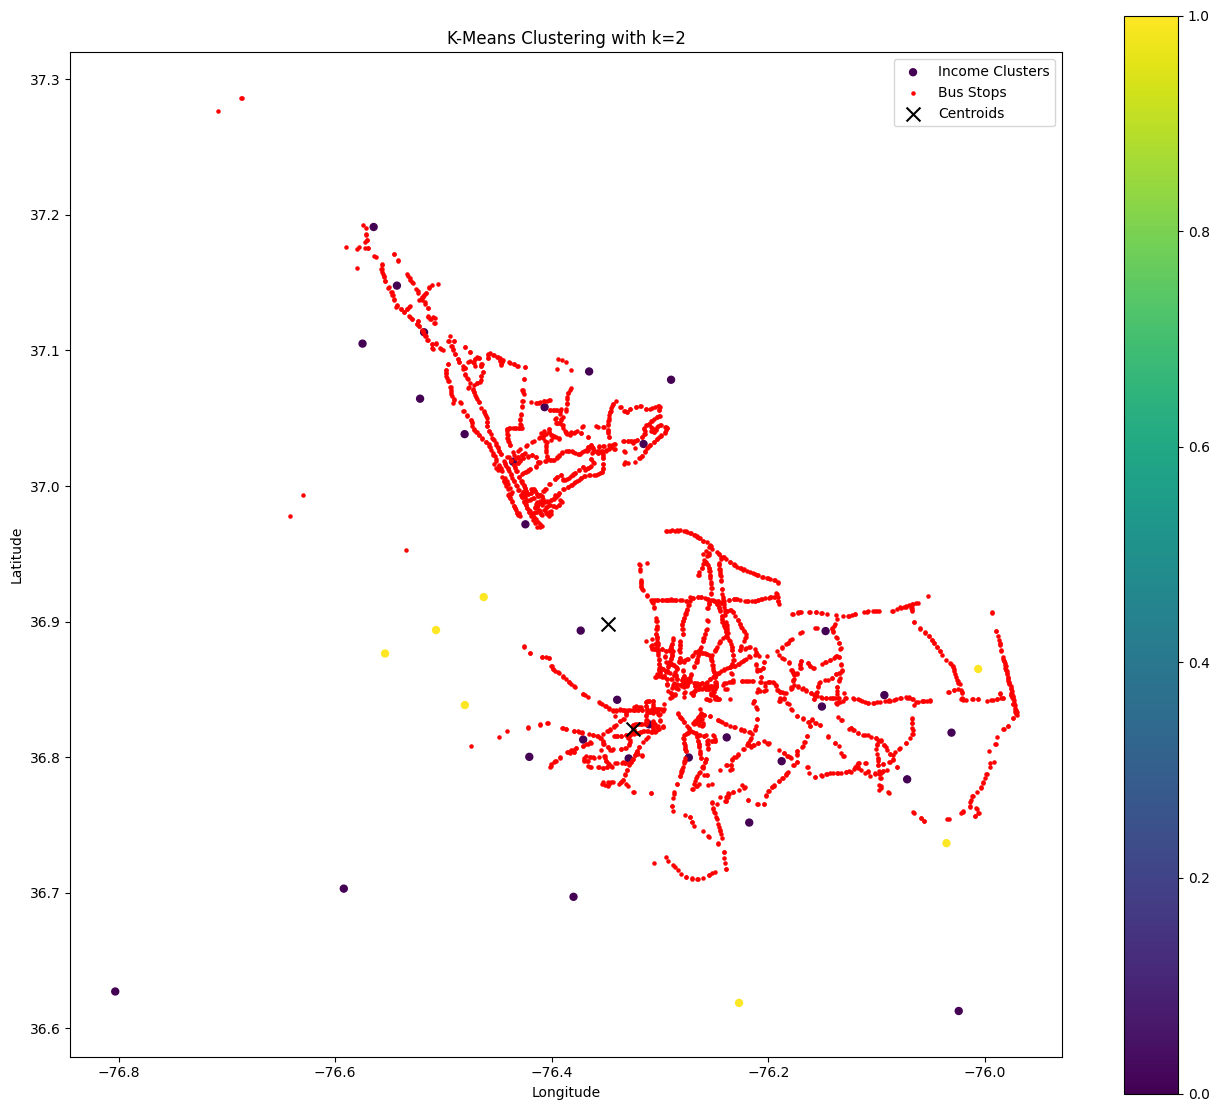

SSE for k=3: 7.450019884228299


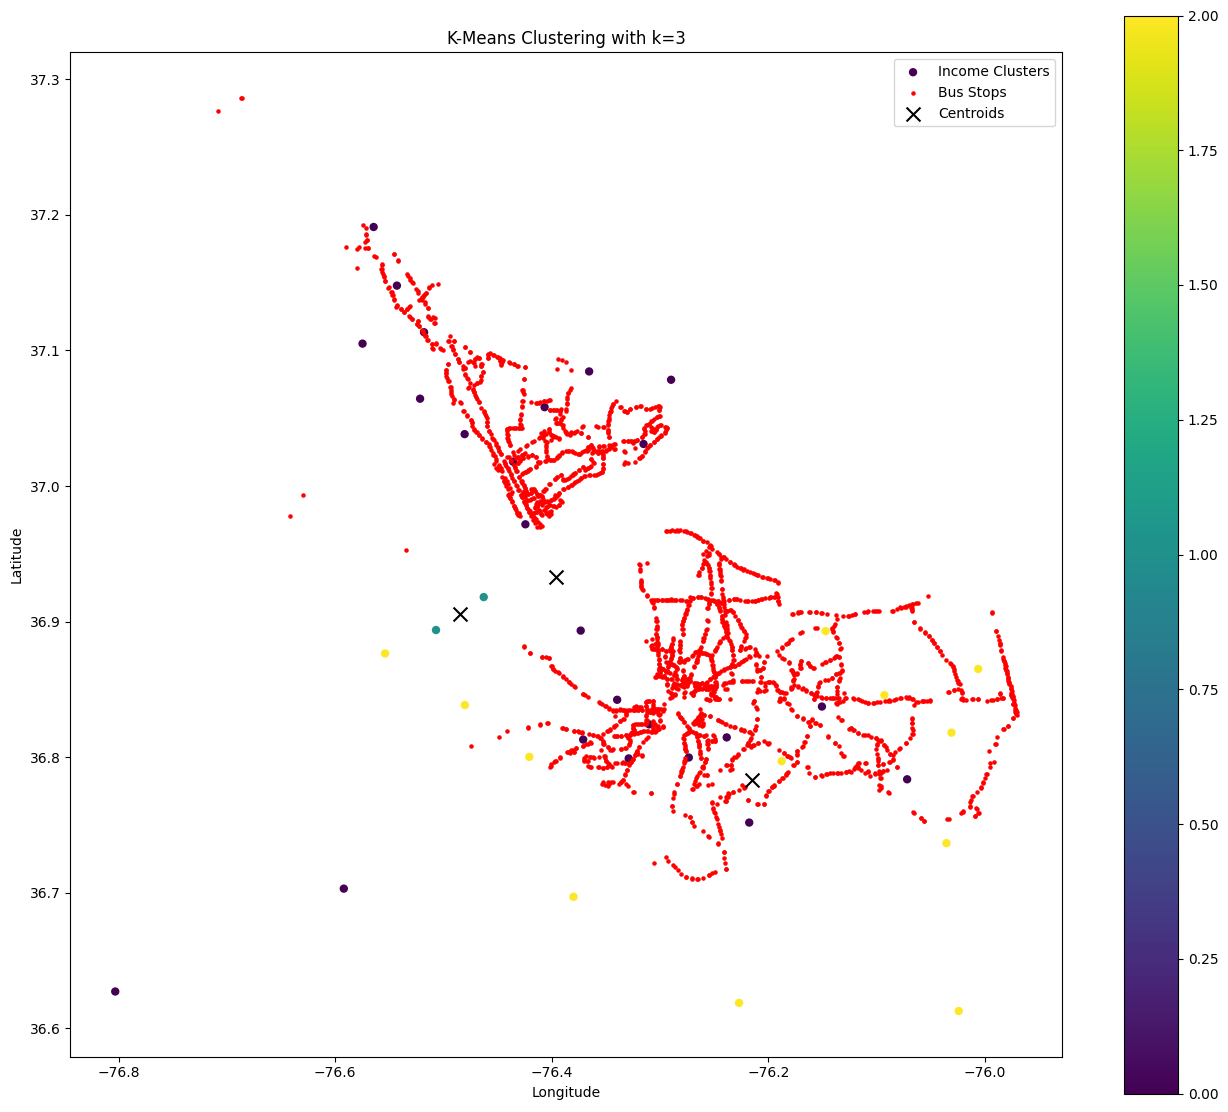

SSE for k=4: 4.63921792949168


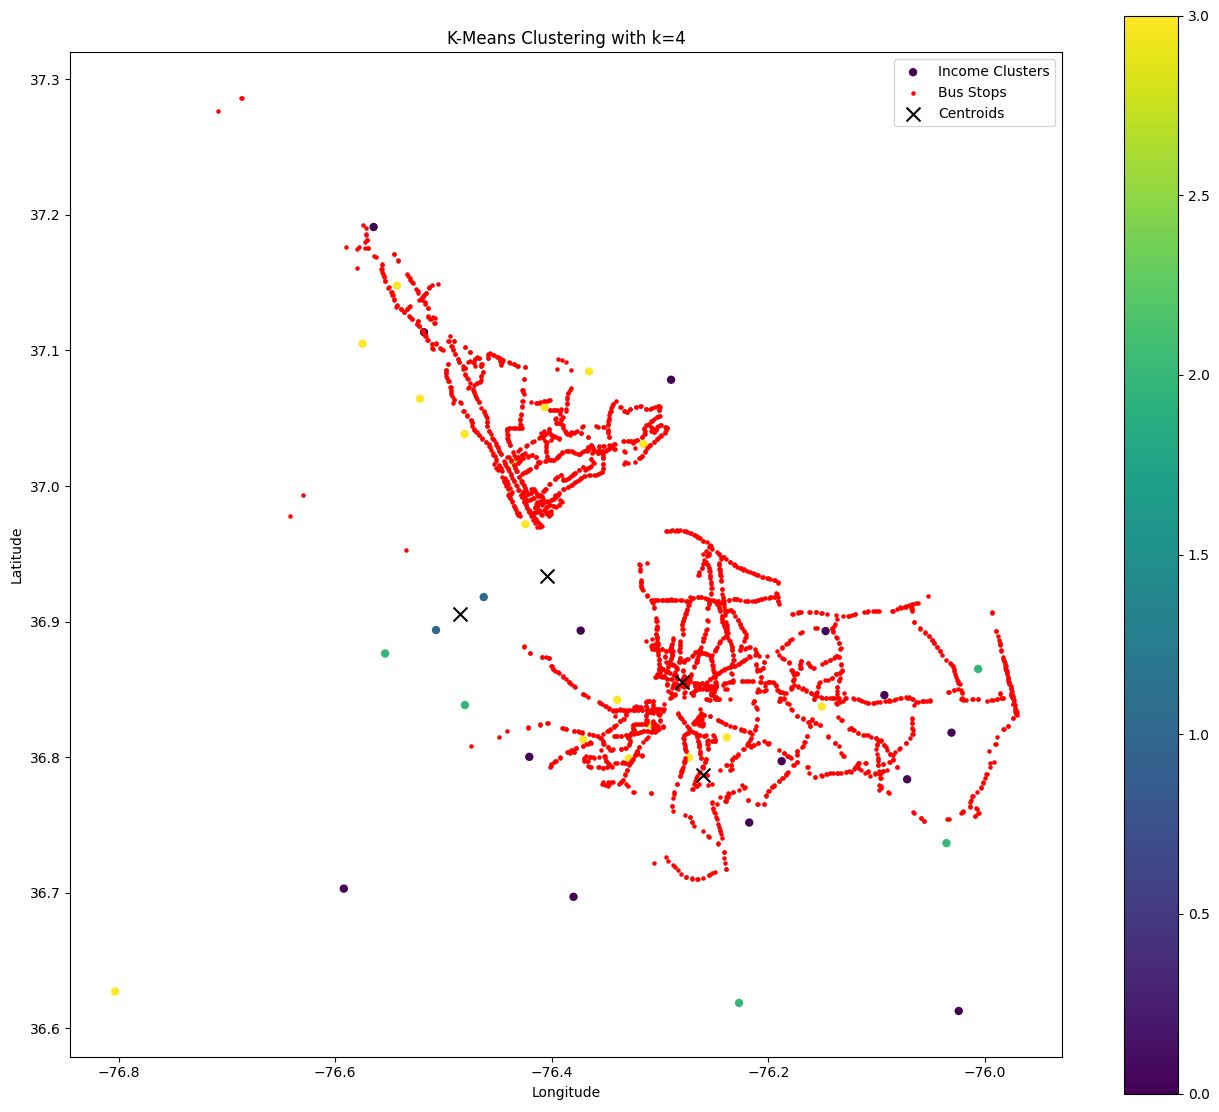

SSE for k=5: 3.1817110884294237


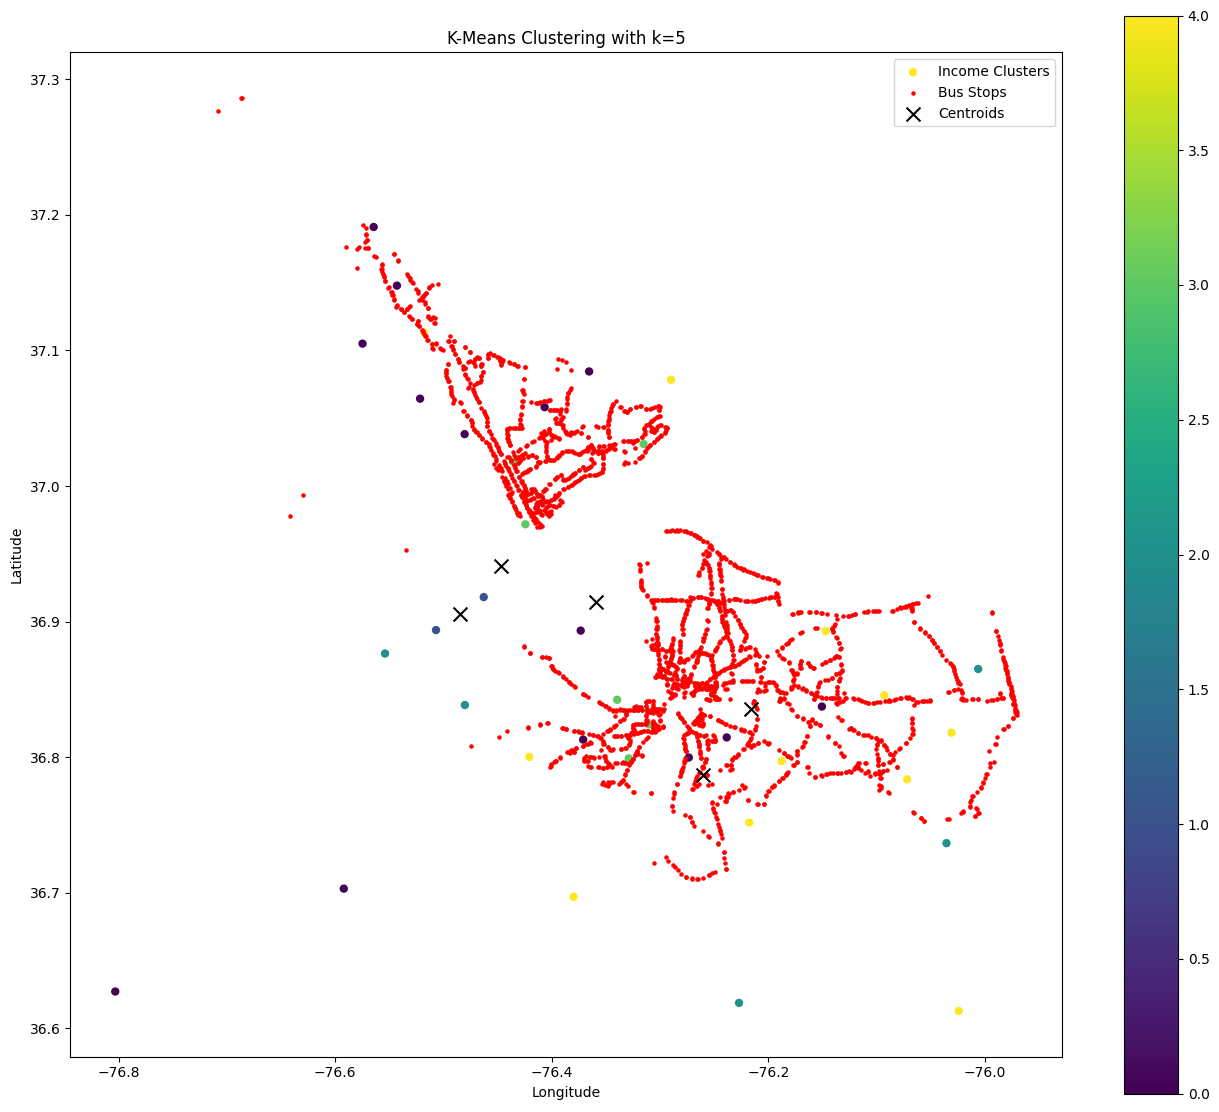

SSE for k=6: 2.588845805505343


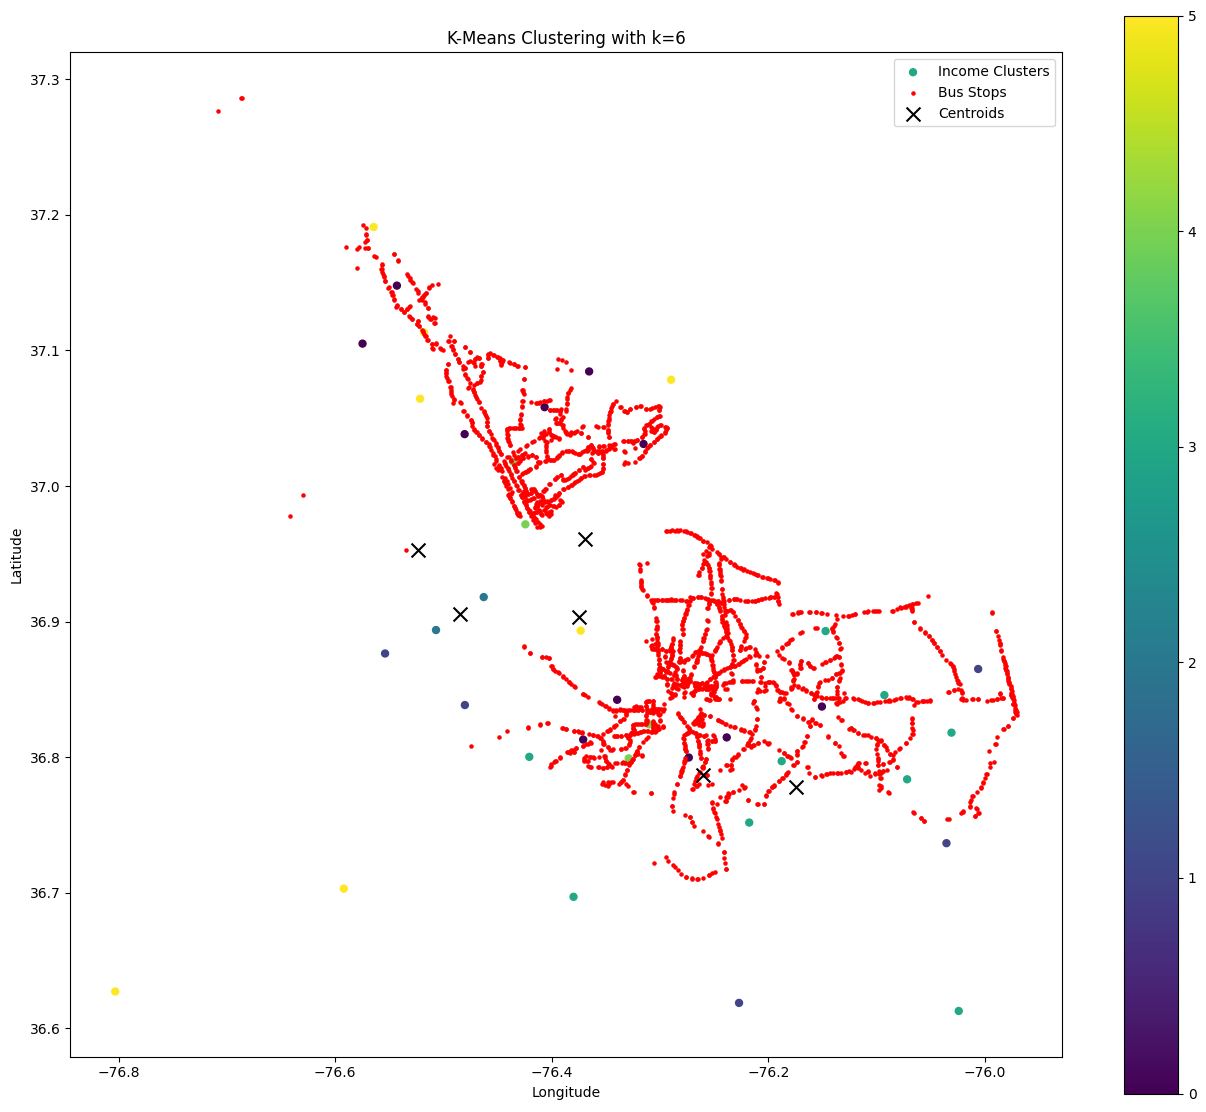

SSE for k=7: 2.2133867201366297


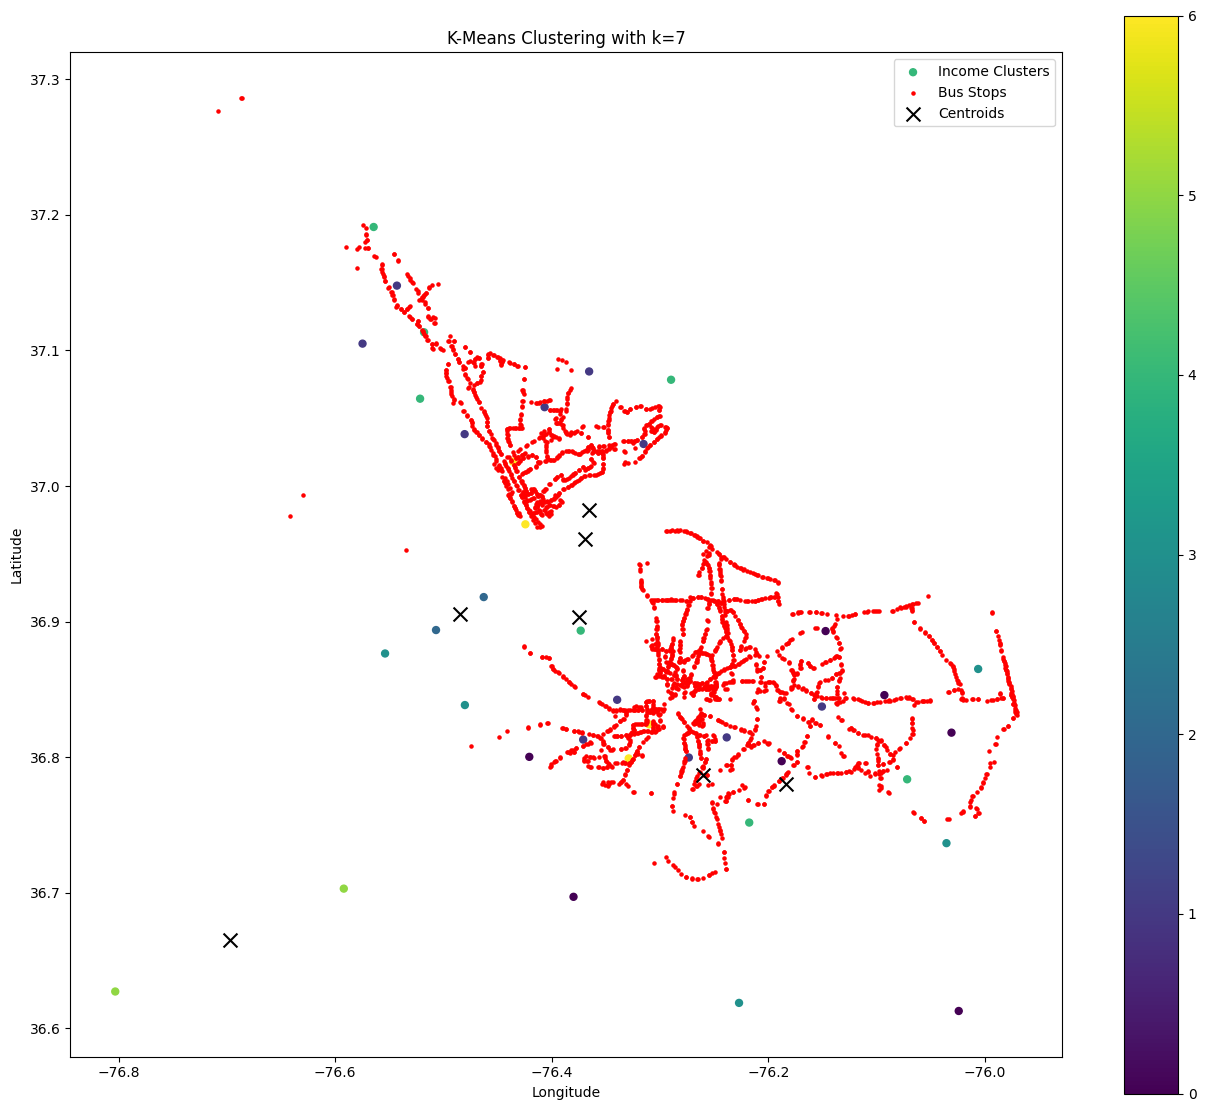

SSE for k=8: 1.8322334970643122


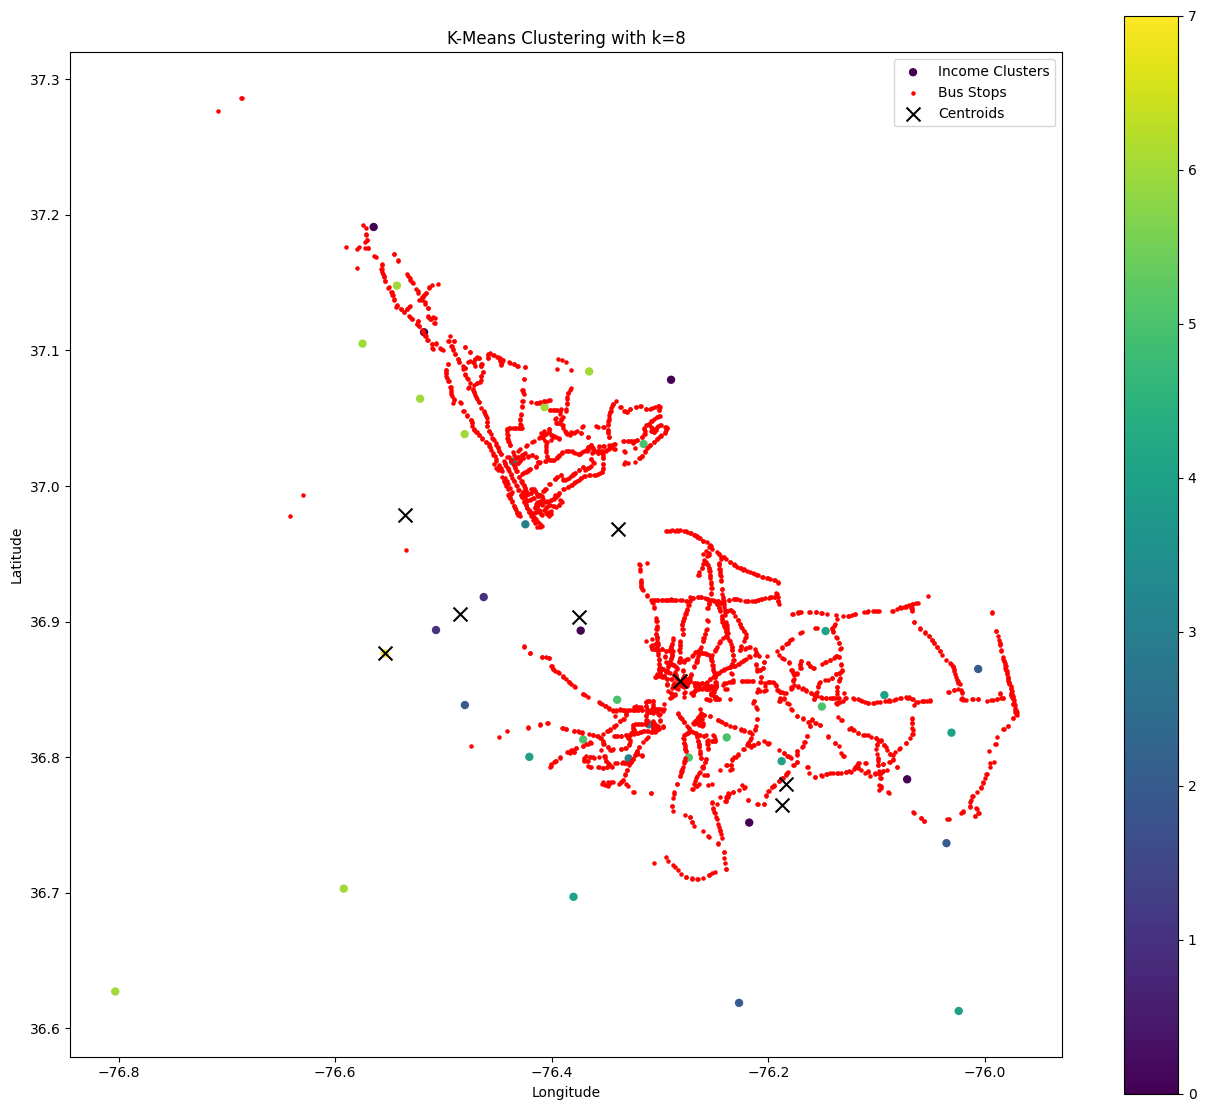

SSE for k=9: 1.4608959498431793


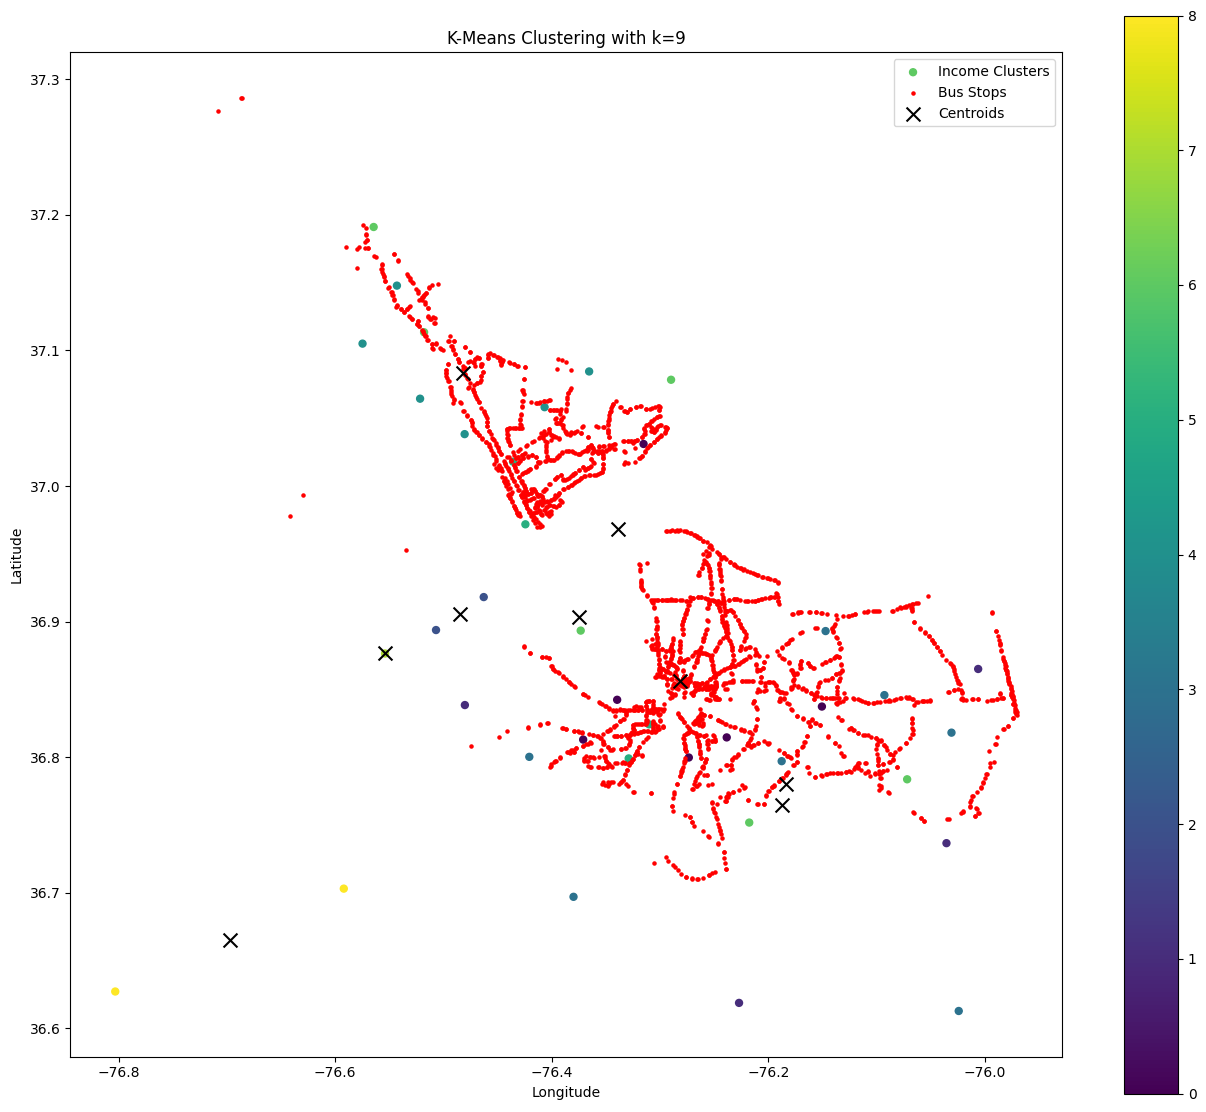

SSE for k=10: 1.1730865149331864


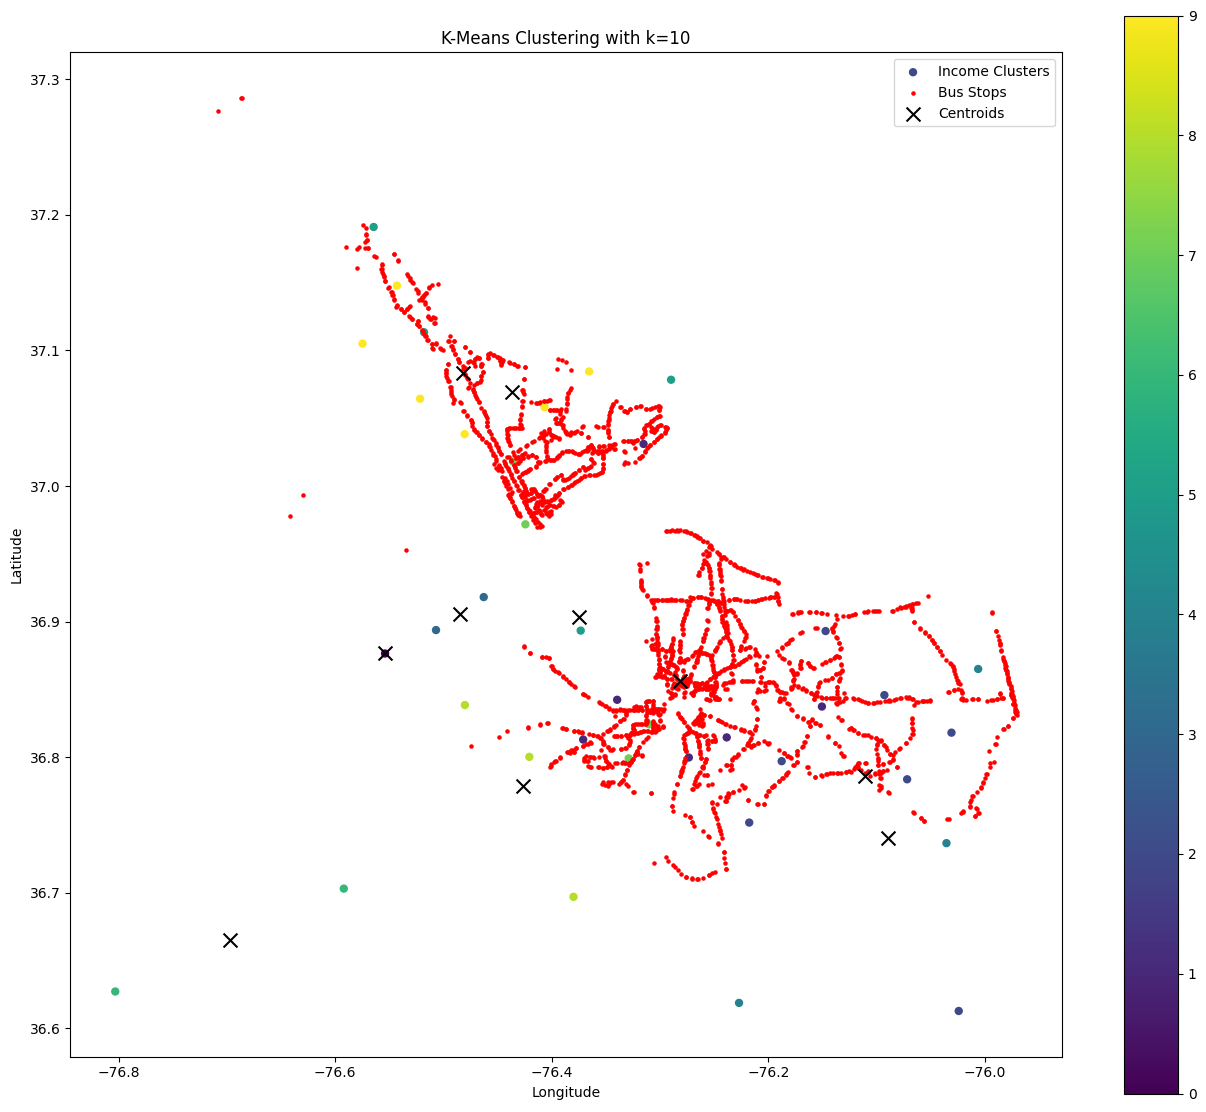

SSE for k=11: 0.9361668398182635


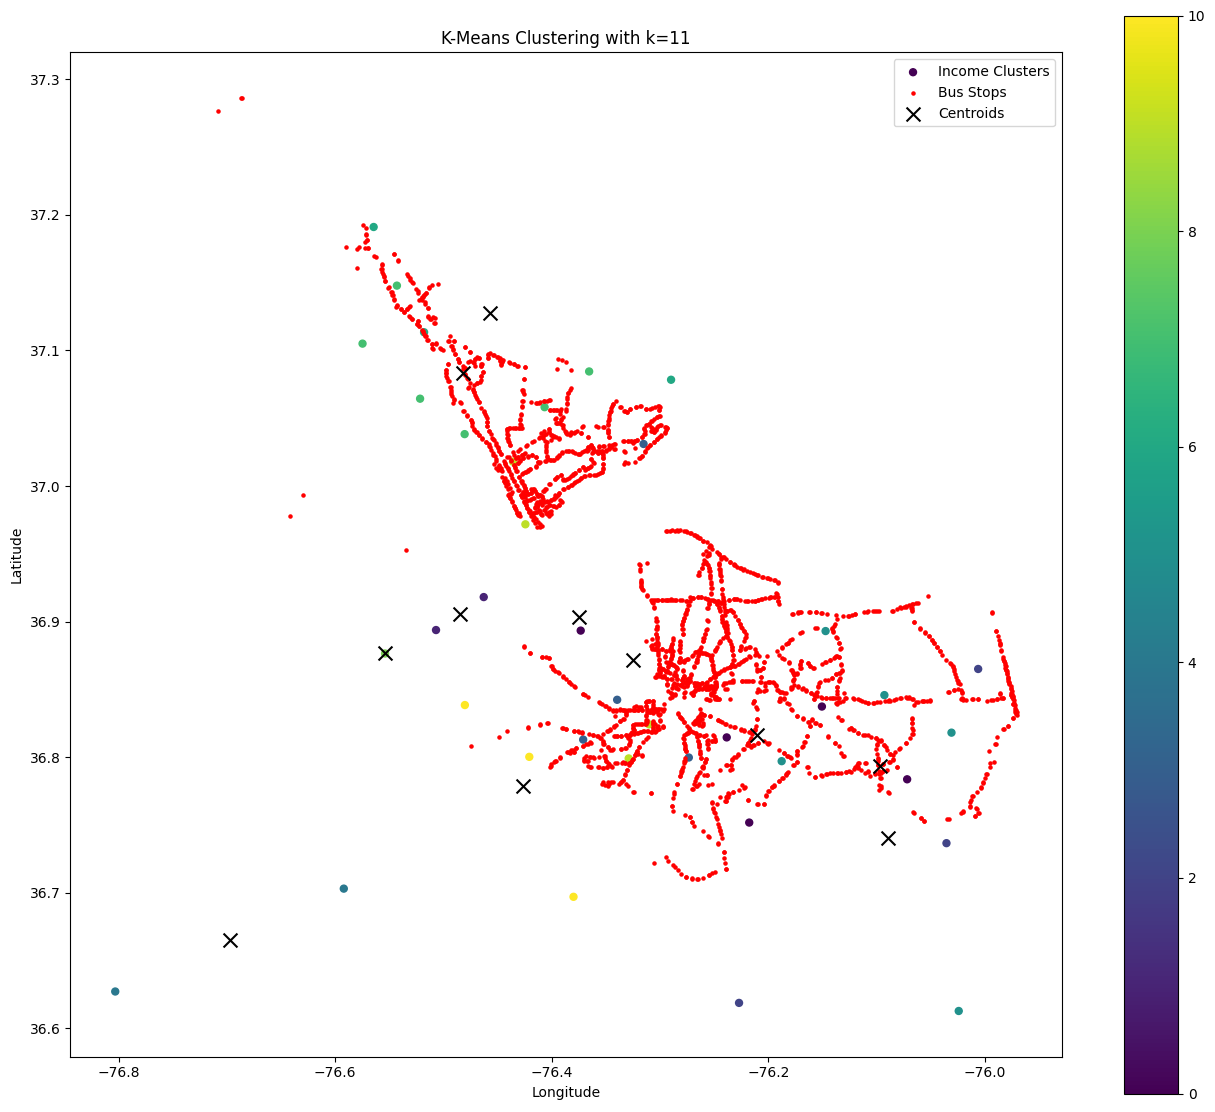

SSE for k=12: 0.8290816573536263


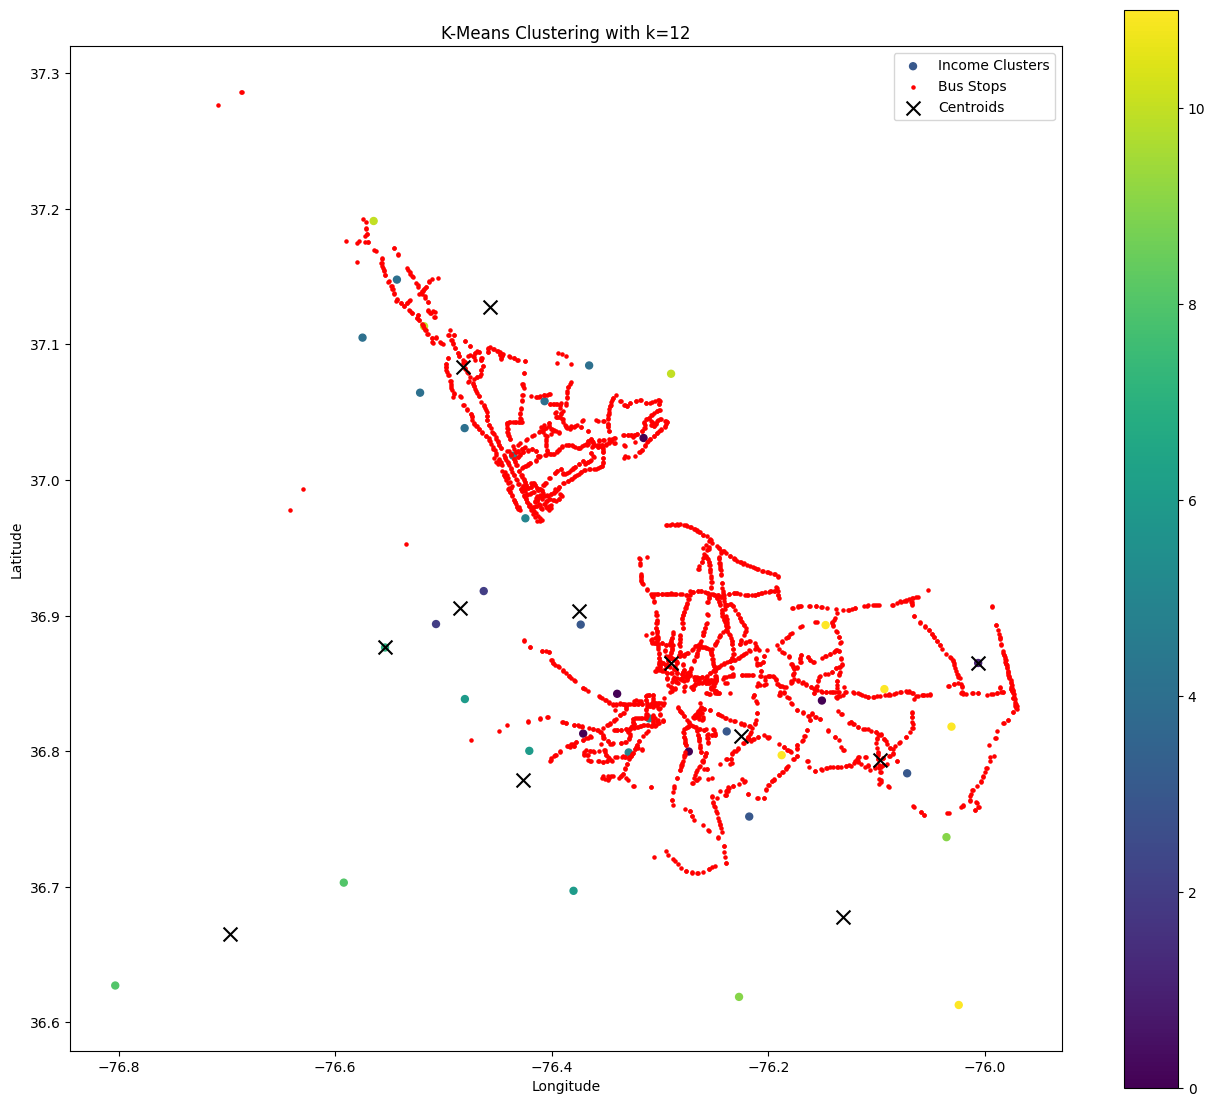

SSE for k=13: 0.7254100328171901


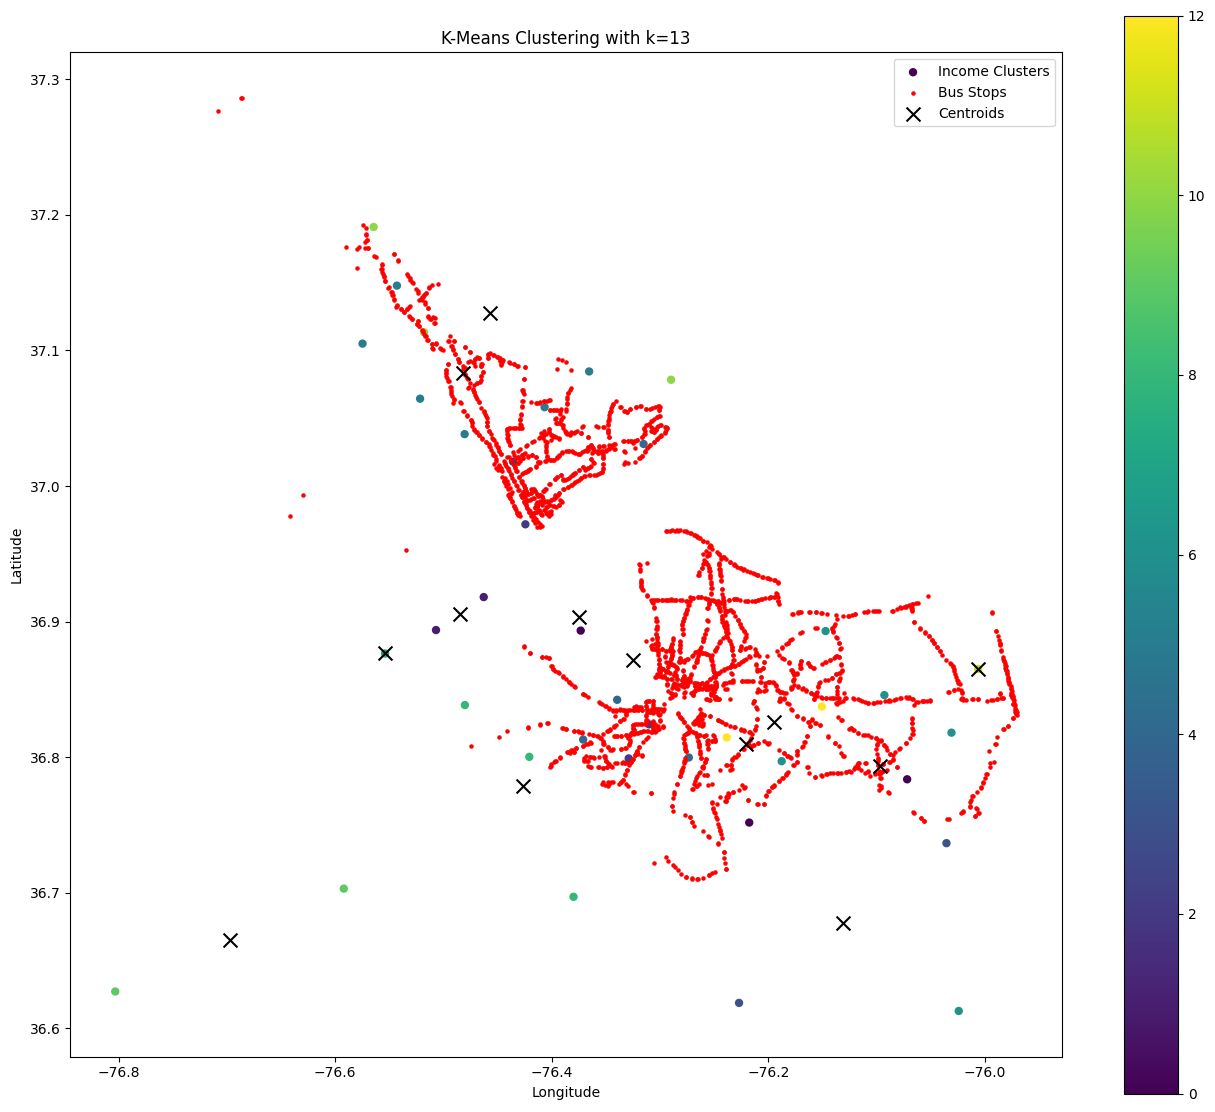

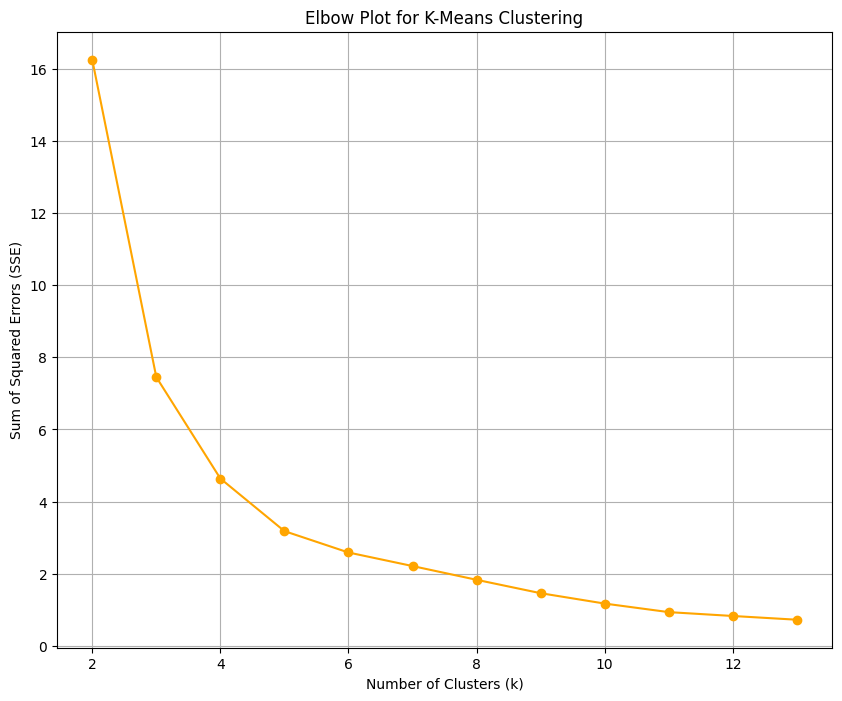

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
income_data_scaled = scaler.fit_transform(income_gdf[['income']])

coordinates = income_gdf[['longitude', 'latitude']].values
data_prepared = np.hstack((coordinates, income_data_scaled))

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13]
sse_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    income_gdf['income_cluster'] = kmeans.fit_predict(data_prepared)

    sse = np.sum((data_prepared - kmeans.cluster_centers_[income_gdf['income_cluster']]) ** 2)
    sse_values.append(sse)
    print(f"SSE for k={k}: {sse}")

    fig, ax = plt.subplots(figsize=(16, 14))

    income_gdf.plot(column='income_cluster', cmap='viridis', ax=ax, legend=True, markersize=25, label='Income Clusters')
    bus_stops_gdf.plot(ax=ax, color='red', markersize=5, label='Bus Stops')

    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

    ax.set_title(f"K-Means Clustering with k={k}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()


plt.figure(figsize=(10, 8))
plt.plot(k_values, sse_values, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Plot for K-Means Clustering')
plt.grid(True)
plt.show()


<ipython-input-16-999c12543f34>:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bus_stop_distances = bus_stops_gdf.distance(income_point.geometry)


SSE for k=2: 45.202340080401356


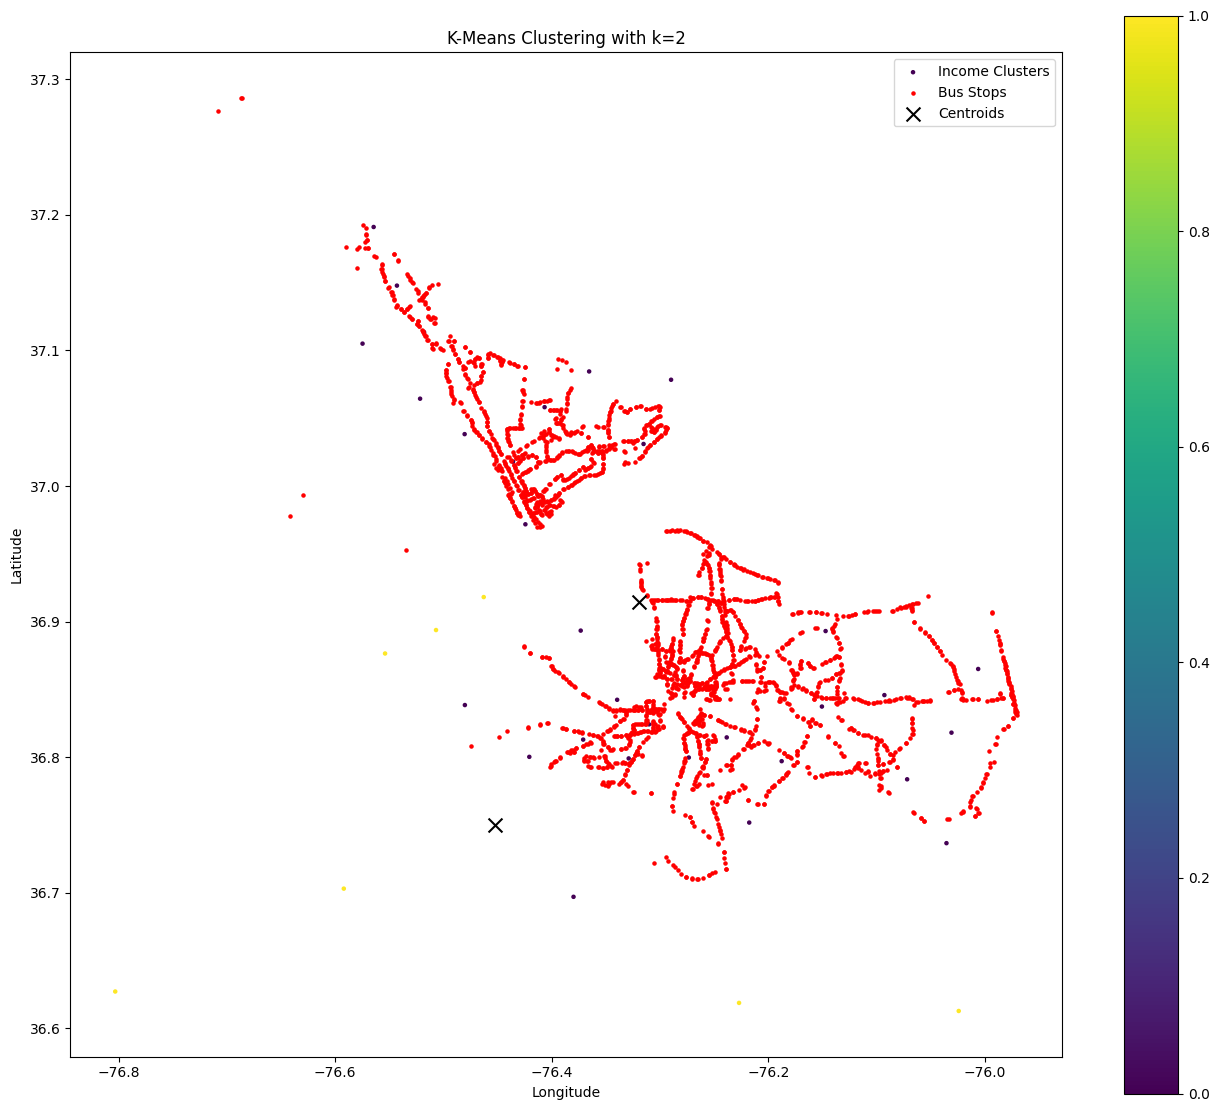

SSE for k=3: 25.34725045831994


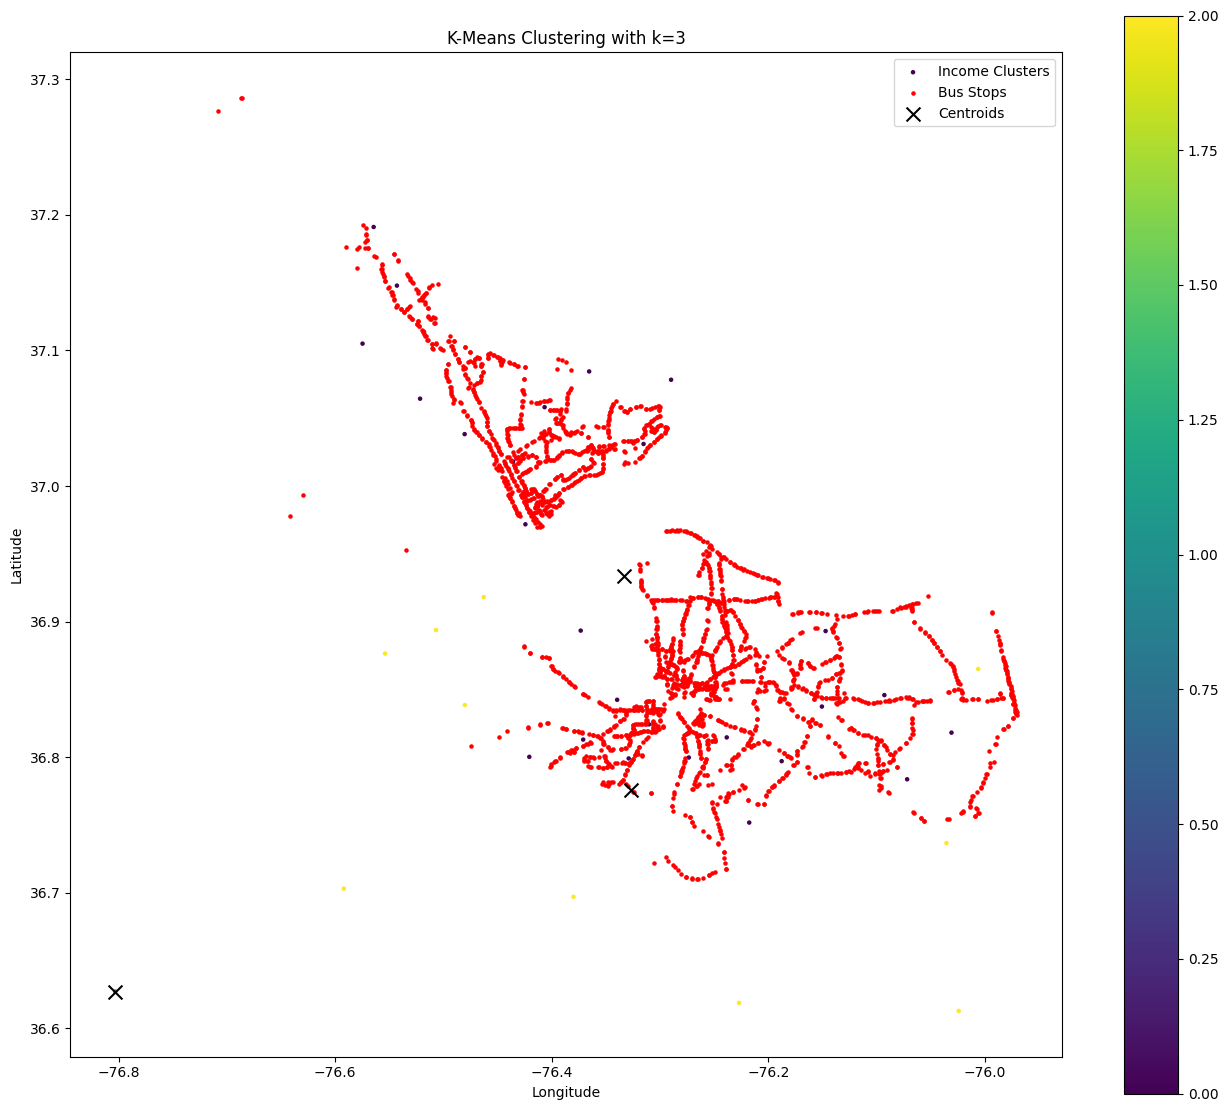

SSE for k=4: 14.747585525317092


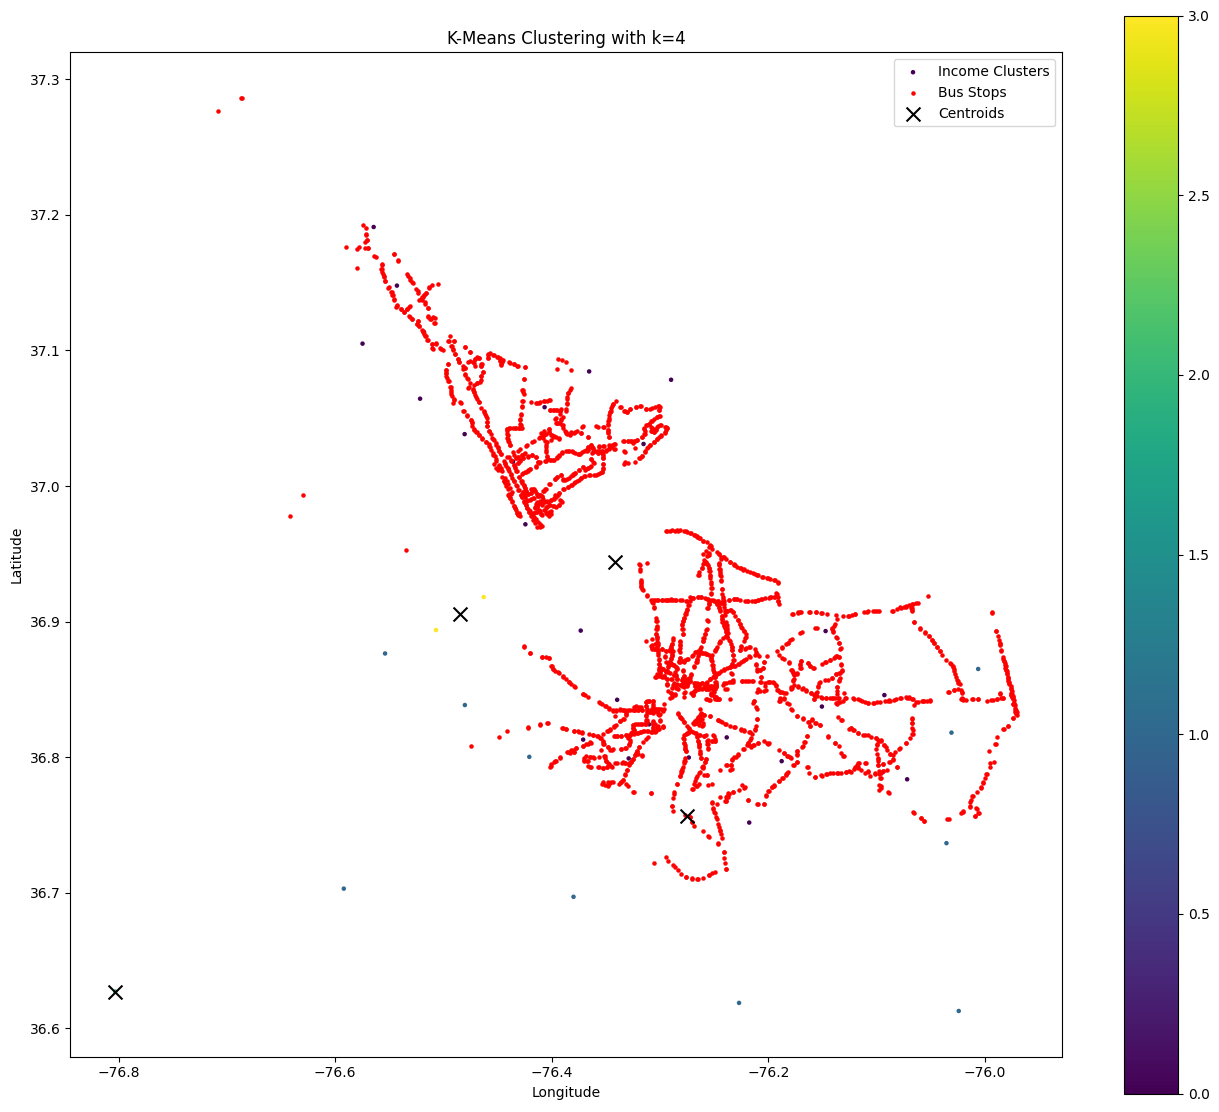

SSE for k=5: 9.208345524349696


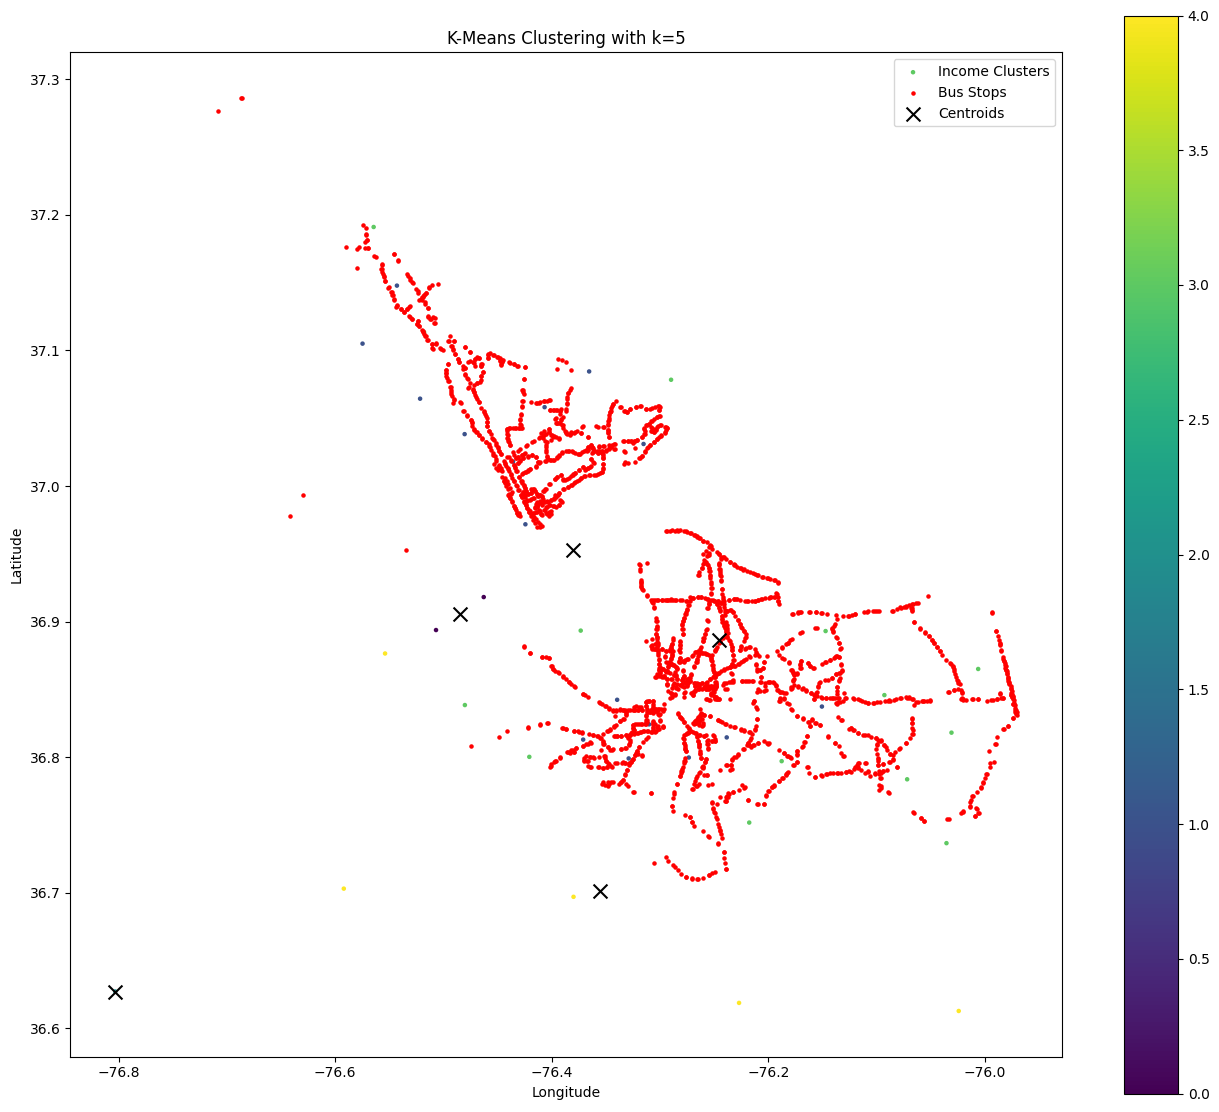

SSE for k=6: 6.5597105030603995


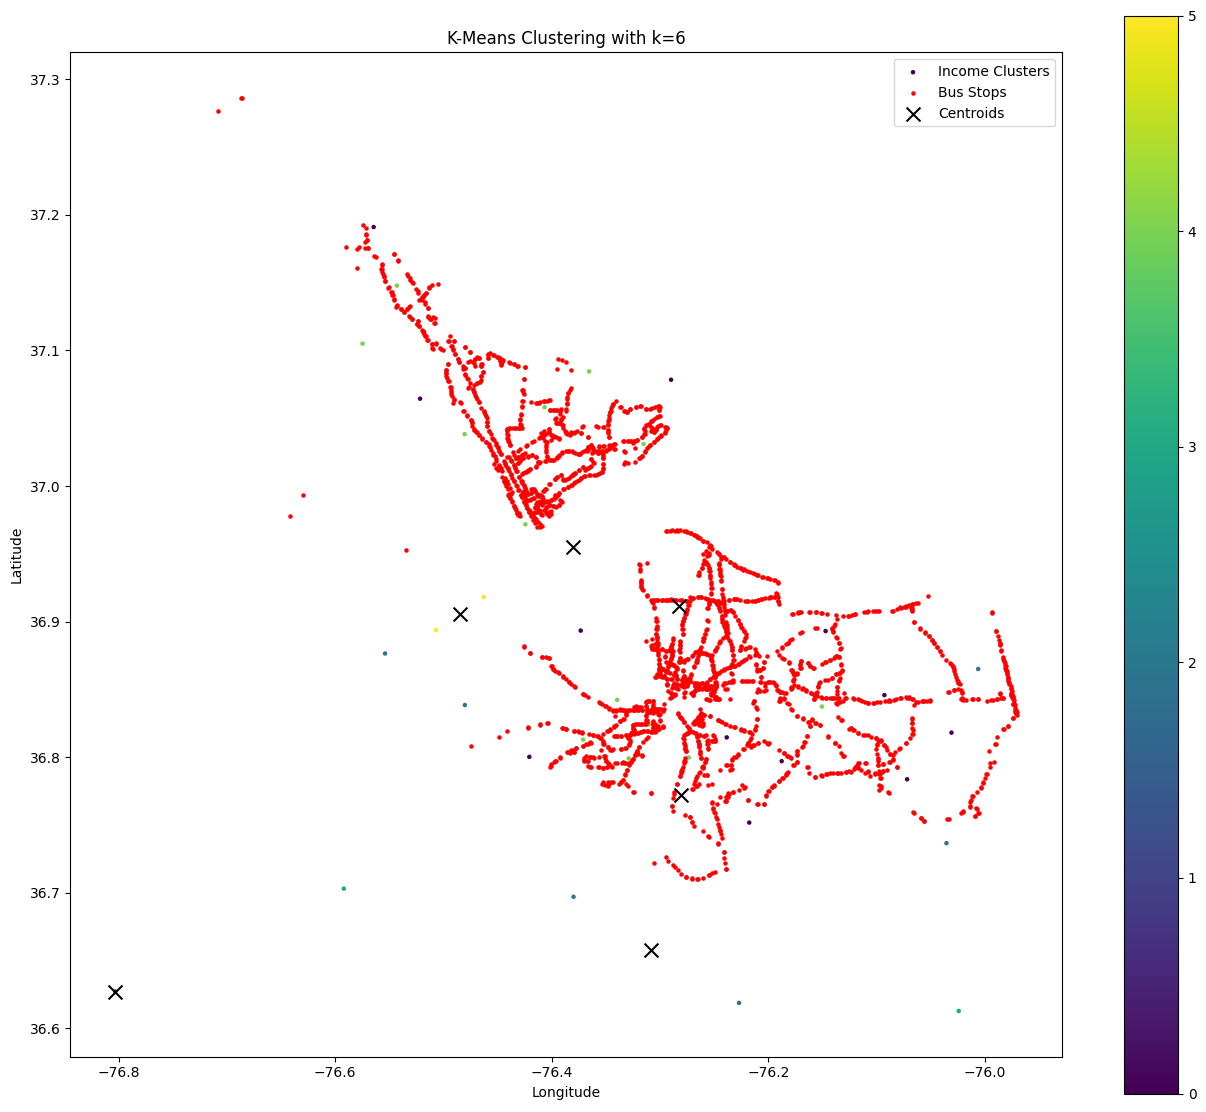

SSE for k=7: 4.946780714508298


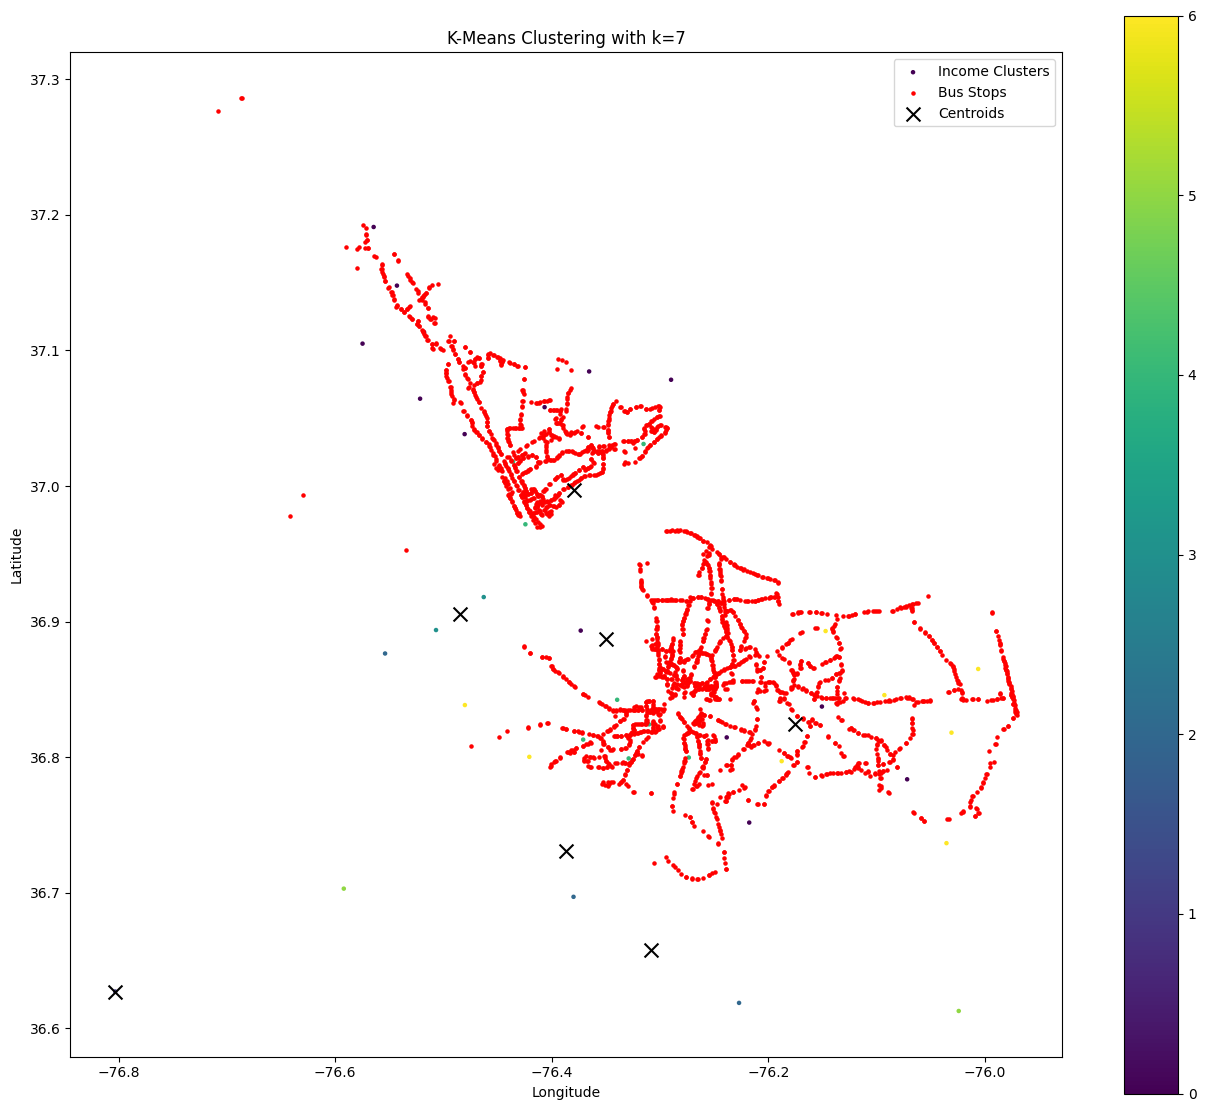

SSE for k=8: 3.9364179116164593


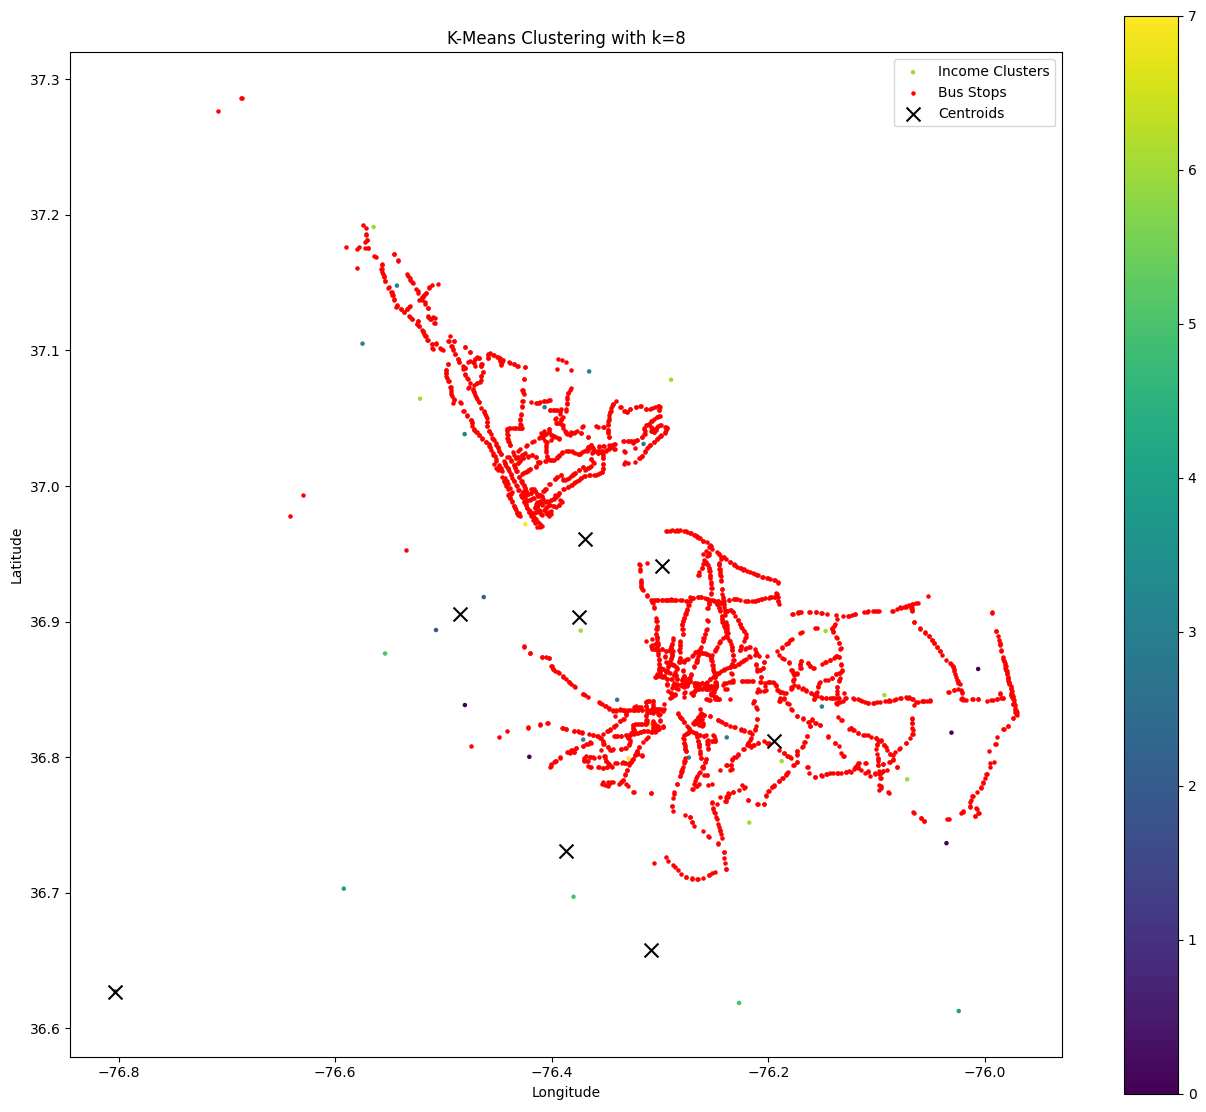

SSE for k=9: 3.207273072769809


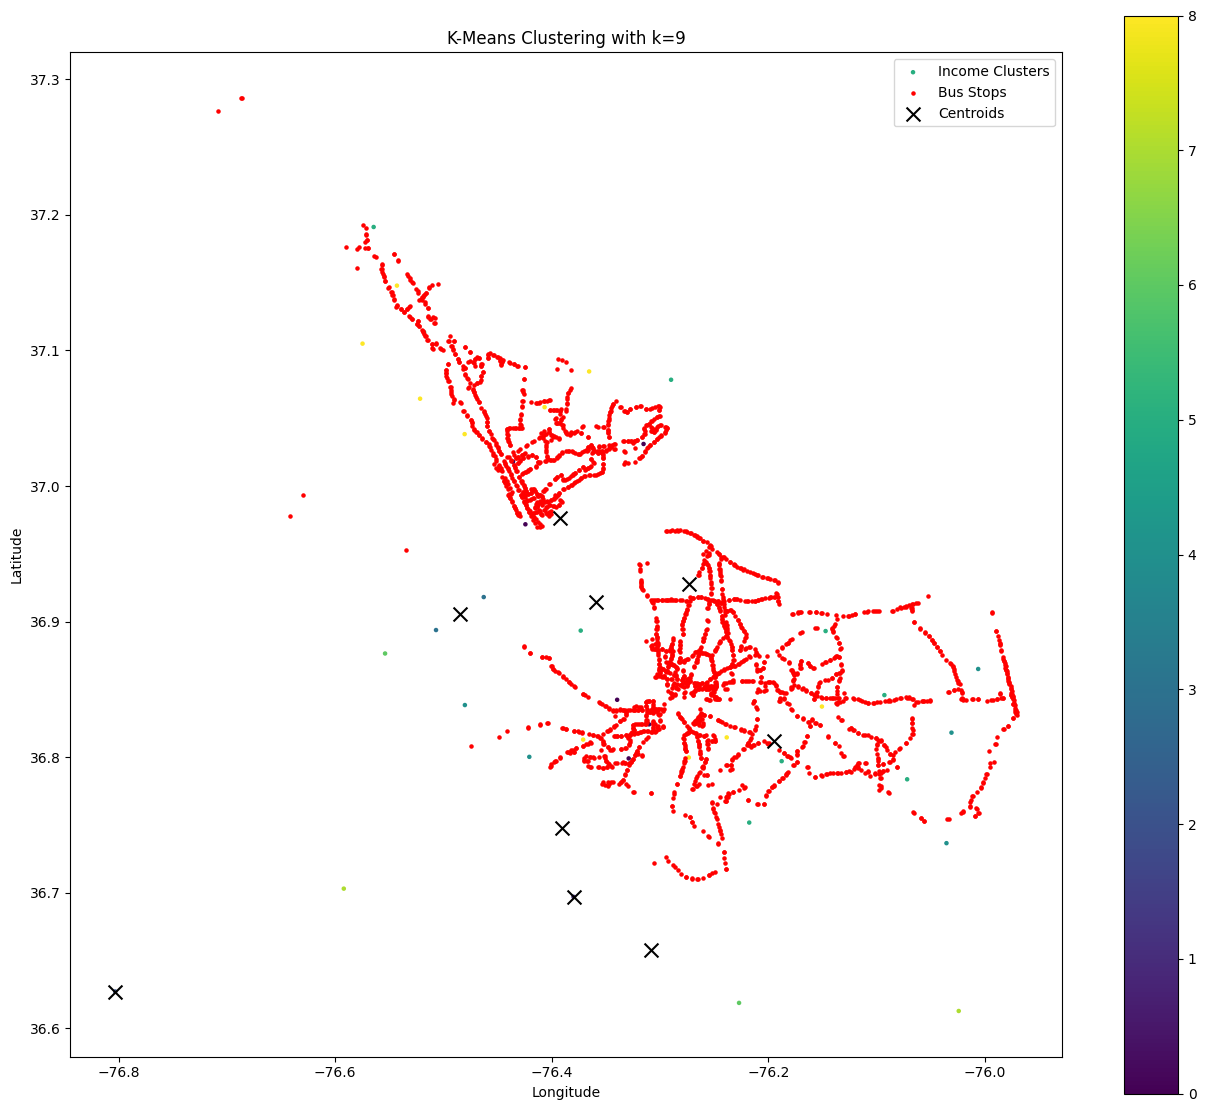

SSE for k=10: 2.7209253661683643


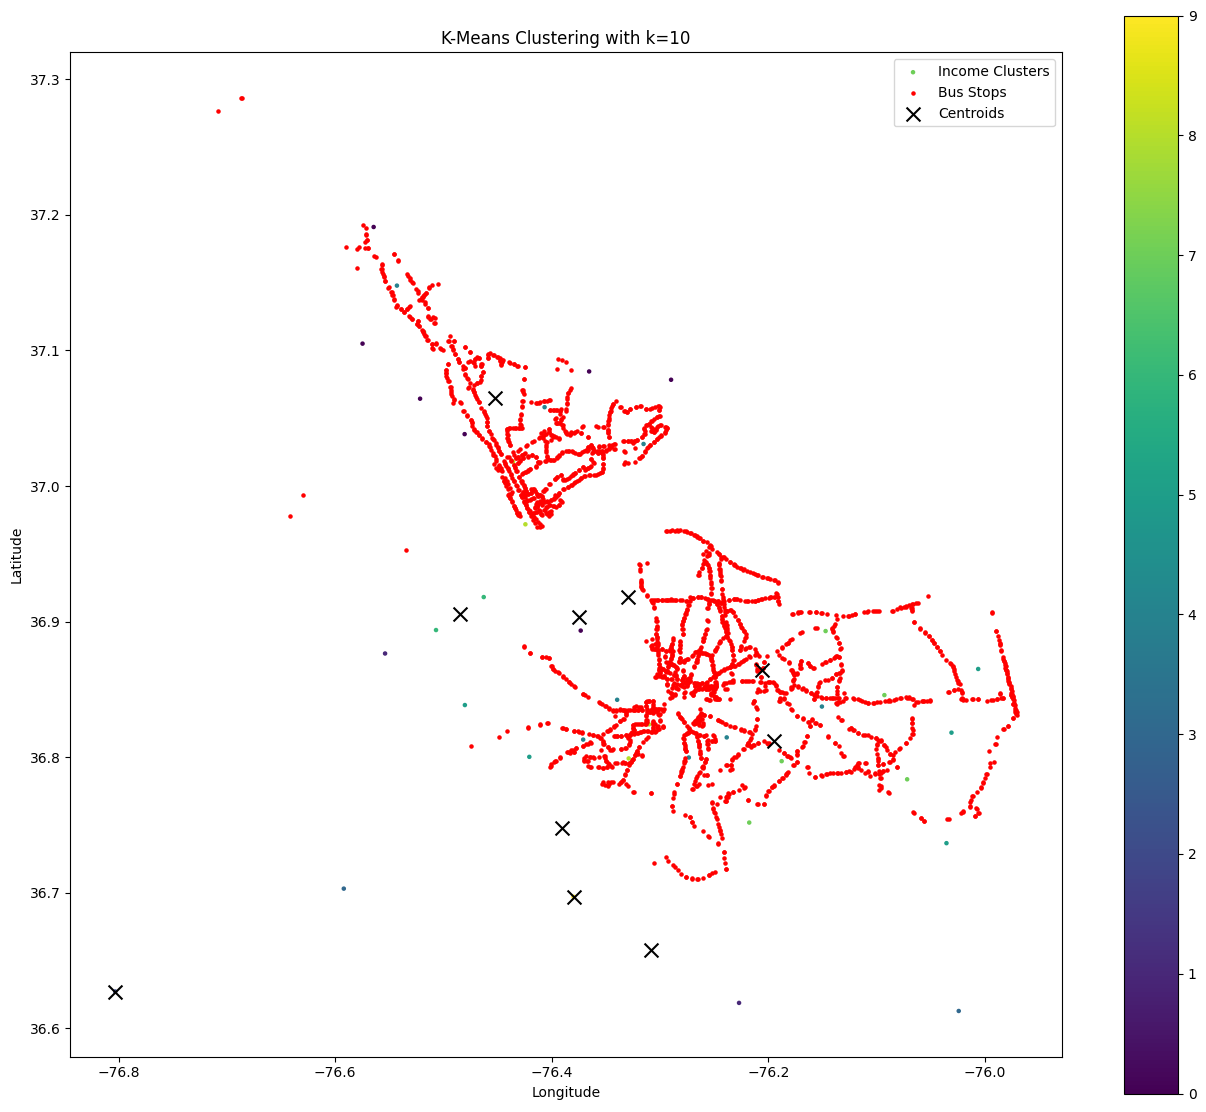

SSE for k=11: 2.355197094708795


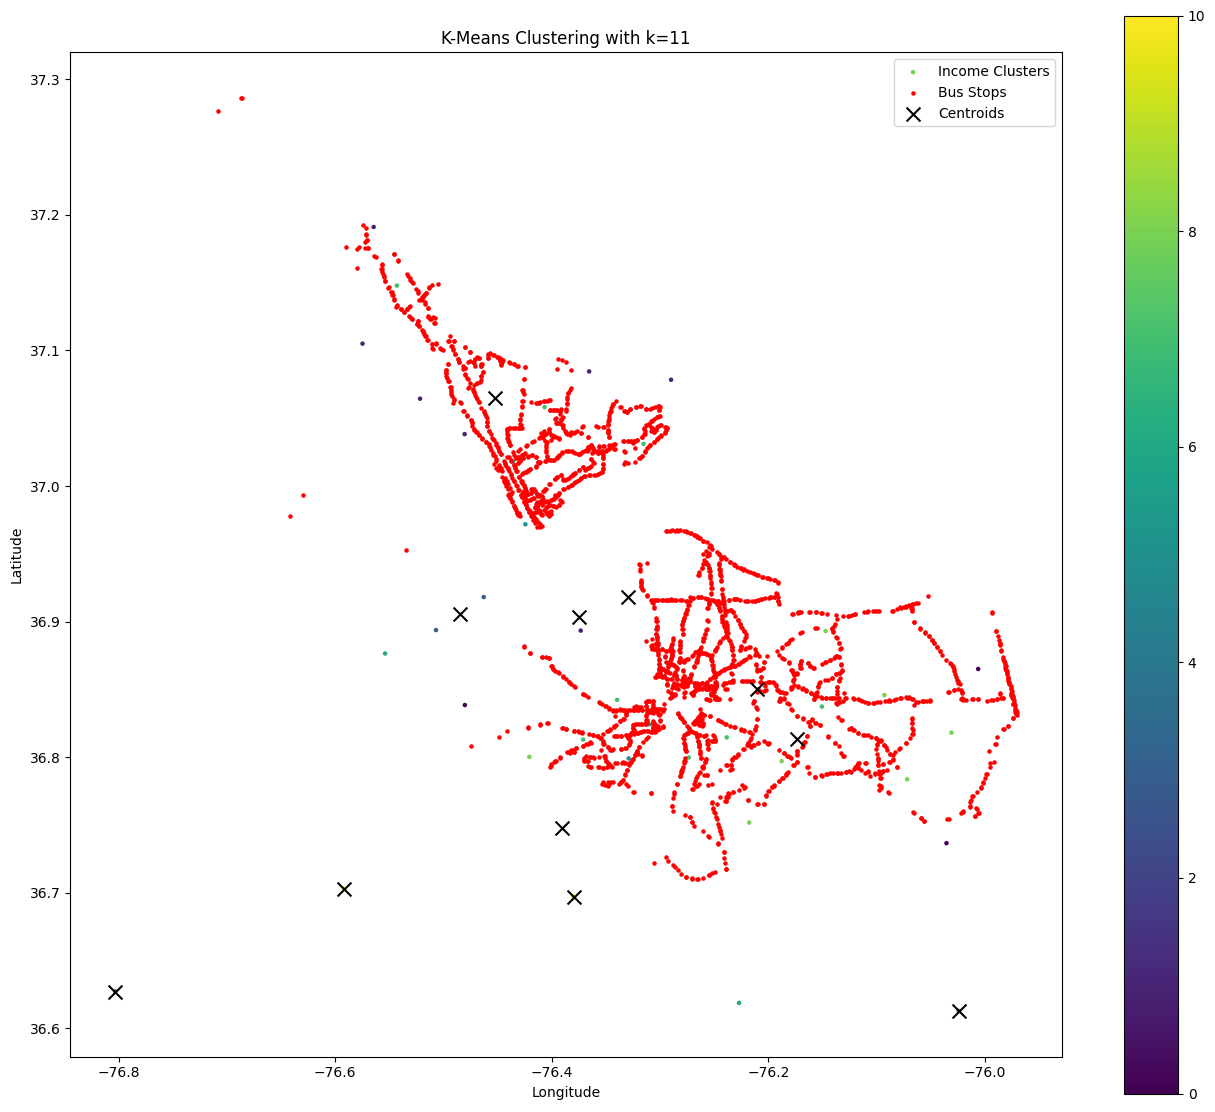

SSE for k=12: 2.0072666108304587


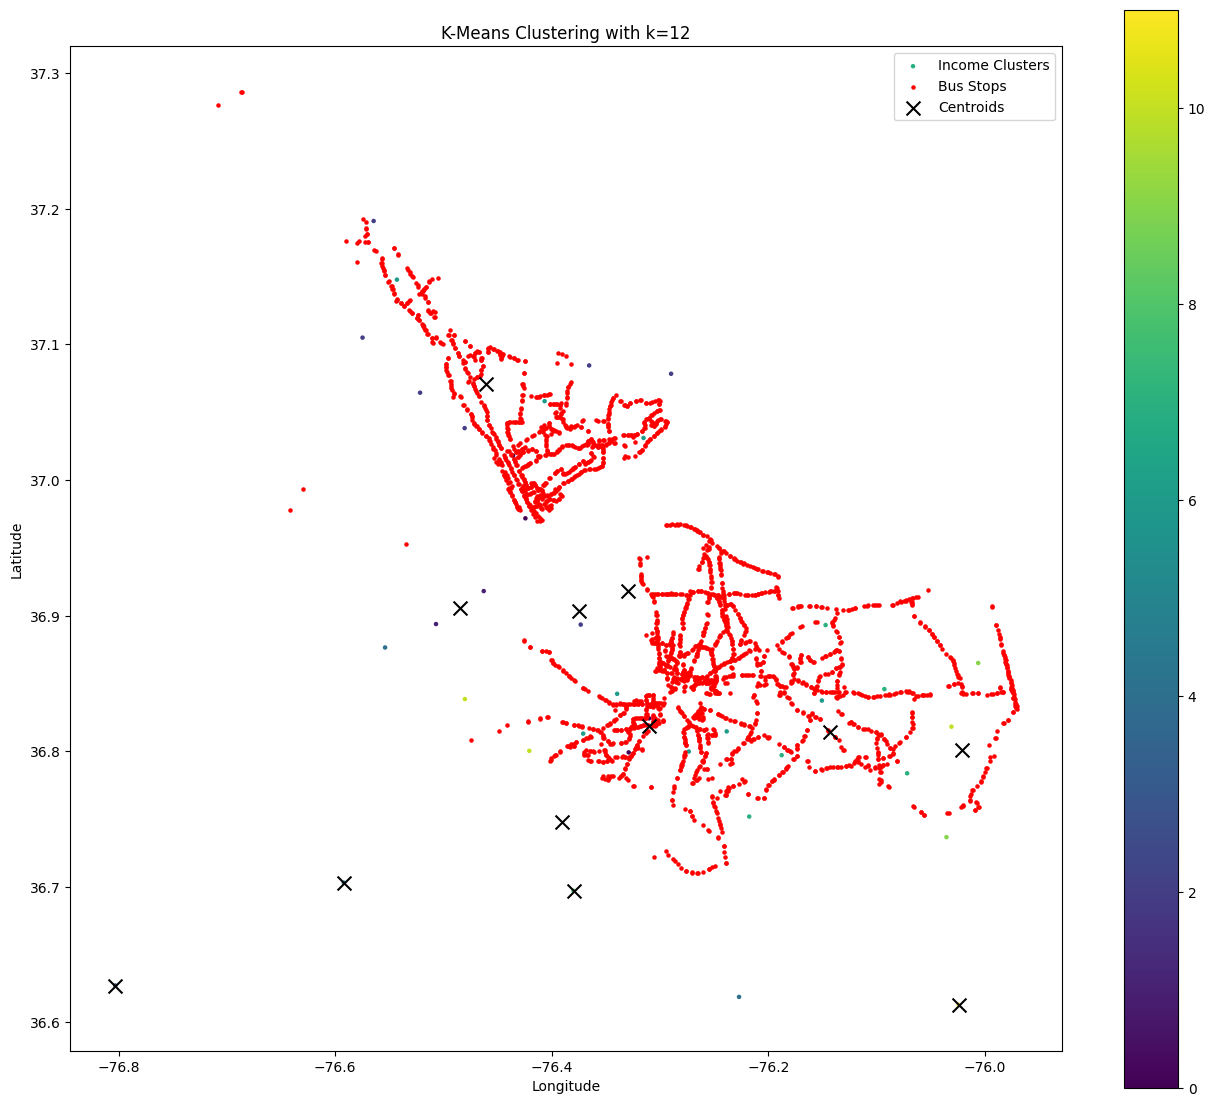

SSE for k=13: 1.7613172342152463


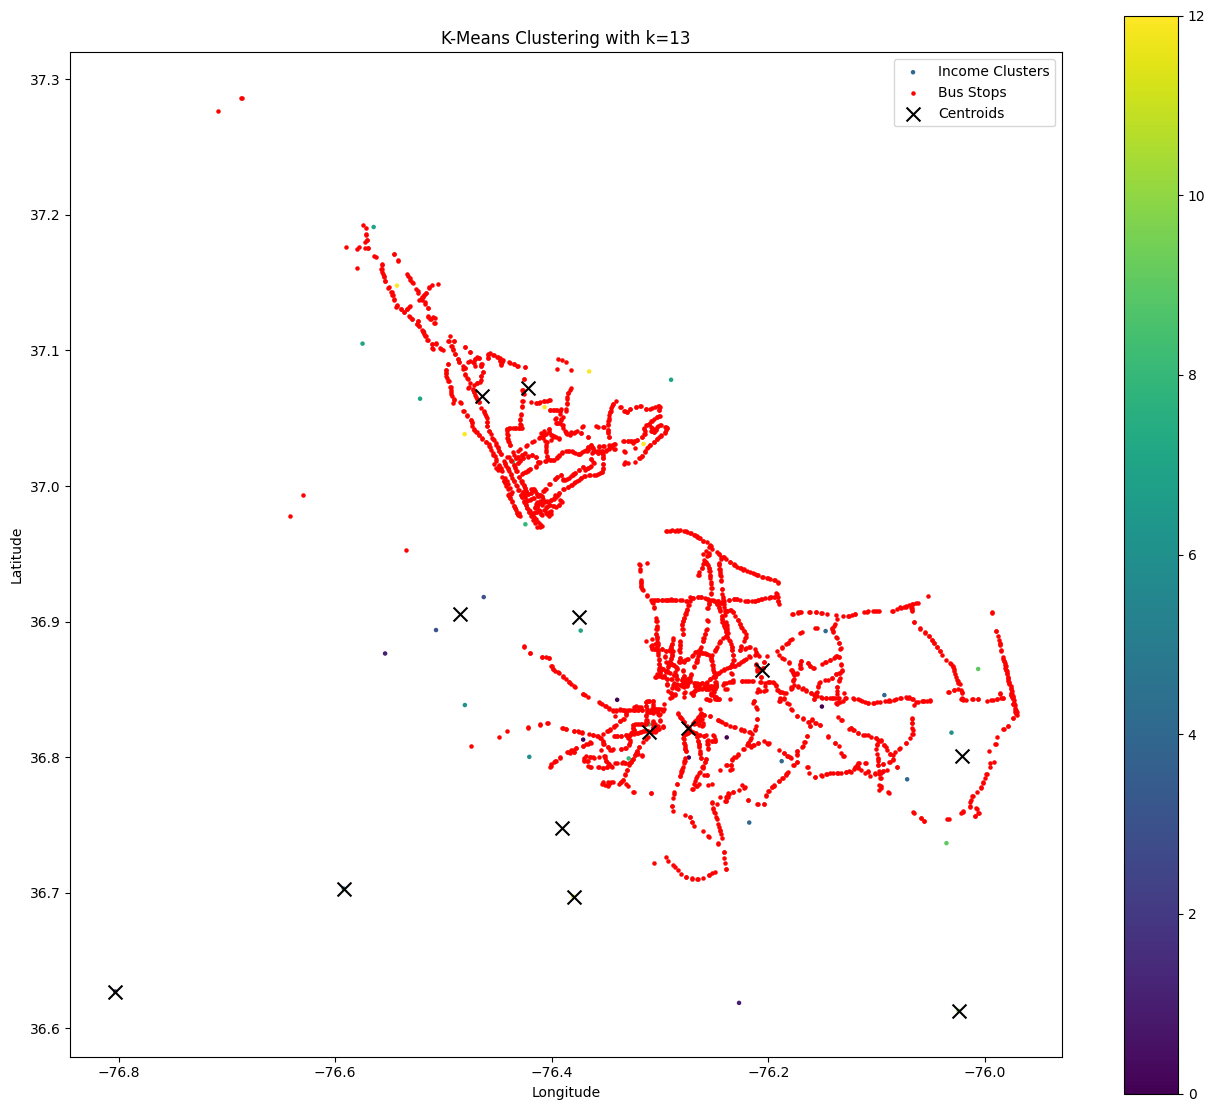

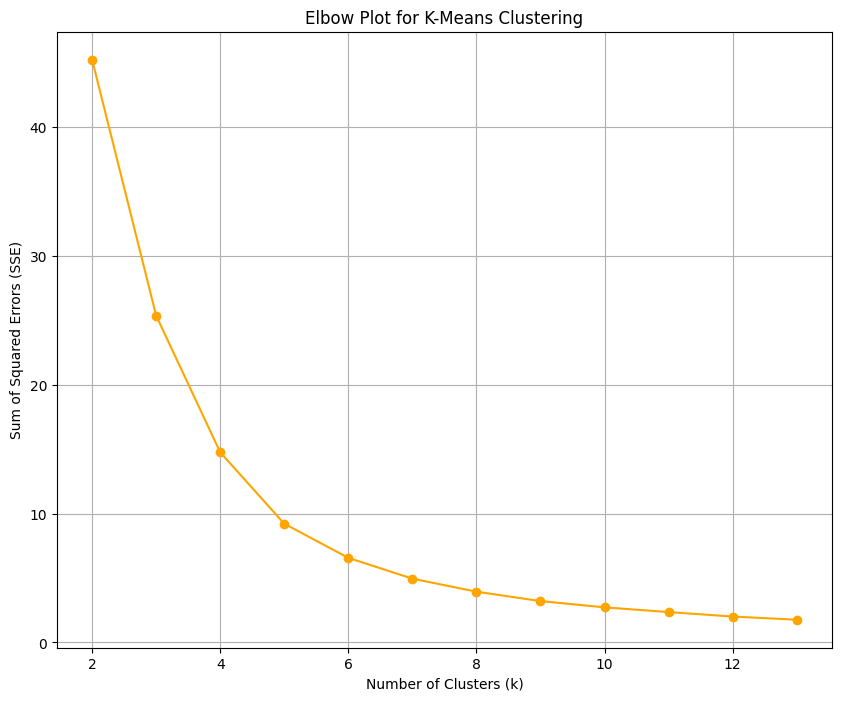

In [ ]:
def calculate_nearest_distances(income_gdf, bus_stops_gdf):
    distances = []
    for _, income_point in income_gdf.iterrows():
        bus_stop_distances = bus_stops_gdf.distance(income_point.geometry)
        min_distance = bus_stop_distances.min()
        distances.append(min_distance)
    return distances

income_gdf['nearest_bus_stop_dist'] = calculate_nearest_distances(income_gdf, bus_stops_gdf)

scaler = StandardScaler()
income_data_scaled = scaler.fit_transform(income_gdf[['income', 'nearest_bus_stop_dist']])

coordinates = income_gdf[['longitude', 'latitude']].values
data_prepared = np.hstack((coordinates, income_data_scaled))

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
sse_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    income_gdf['income_cluster'] = kmeans.fit_predict(data_prepared)

    sse = np.sum((data_prepared - kmeans.cluster_centers_[income_gdf['income_cluster']]) ** 2)
    sse_values.append(sse)
    print(f"SSE for k={k}: {sse}")

    fig, ax = plt.subplots(figsize=(16, 14))

    income_gdf.plot(column='income_cluster', ax=ax, legend=True, markersize=5, label='Income Clusters')
    bus_stops_gdf.plot(ax=ax, color='red', markersize=5, label='Bus Stops')

    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

    ax.set_title(f"K-Means Clustering with k={k}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    ax.legend(loc='best')
    plt.show()

plt.figure(figsize=(10, 8))
plt.plot(k_values, sse_values, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Plot for K-Means Clustering')
plt.grid(True)
plt.show()


In [ ]:
income_gdf

zipcode  income   latitude  longitude                    geometry  \
0     23320  100660  36.751734 -76.217637  POINT (-76.21764 36.75173)   
1     23321  121351  36.800209 -76.420759  POINT (-76.42076 36.80021)   
2     23322  148349  36.618712 -76.227046  POINT (-76.22705 36.61871)   
3     23323  117709  36.696963 -76.379928  POINT (-76.37993 36.69696)   
4     23324   76508  36.799721 -76.273447  POINT (-76.27345 36.79972)   
5     23325   87323  36.814548 -76.238429  POINT (-76.23843 36.81455)   
6     23432  167850  36.876452 -76.553978  POINT (-76.55398 36.87645)   
7     23433  238974  36.918069 -76.462863  POINT (-76.46286 36.91807)   
8     23434   93623  36.703003 -76.592105     POINT (-76.5921 36.703)   
9     23435  134338  36.838420 -76.480264  POINT (-76.48026 36.83842)   
10    23436  231820  36.893751 -76.506926  POINT (-76.50693 36.89375)   
11    23437   87265  36.627115 -76.803197   POINT (-76.8032 36.62712)   
12    23451  136673  36.865027 -76.006188  POINT (-76.00619 36.86503)   
13    23452  110980  36.845756 -76.092807  POINT (-76.09281 36.84576)   
14    23453   95447  36.783649 -76.071784  POINT (-76.07178 36.78365)   
15    23454  119364  36.818062 -76.030835  POINT (-76.03084 36.81806)   
16    23455  108310  36.892997 -76.147108    POINT (-76.14711 36.893)   
17    23456  150363  36.736543 -76.035469  POINT (-76.03547 36.73654)   
18    23457  117598  36.612747 -76.024139  POINT (-76.02414 36.61275)   
19    23462   82642  36.837313 -76.150514  POINT (-76.15051 36.83731)   
20    23464  108999  36.797023 -76.187680  POINT (-76.18768 36.79702)   
21    23601   86512  37.038265 -76.480498   POINT (-76.4805 37.03826)   
22    23602  105834  37.113416 -76.517947  POINT (-76.51795 37.11342)   
23    23603  100070  37.191057 -76.564535  POINT (-76.56454 37.19106)   
24    23604   79712  37.105026 -76.574793  POINT (-76.57479 37.10503)   
25    23605   55739  37.017949 -76.435781  POINT (-76.43578 37.01795)   
26    23606   91138  37.064408 -76.521638  POINT (-76.52164 37.06441)   
27    23607   49308  36.971747 -76.424372  POINT (-76.42437 36.97175)   
28    23608   79210  37.147813 -76.543036  POINT (-76.54304 37.14781)   
29    23663   70287  37.031007 -76.315244  POINT (-76.31524 37.03101)   
30    23664   98958  37.078374 -76.289825  POINT (-76.28982 37.07837)   
31    23665   83567  37.084498 -76.365498    POINT (-76.3655 37.0845)   
32    23666   82851  37.058141 -76.406646  POINT (-76.40665 37.05814)   
33    23701   77065  36.812940 -76.371005    POINT (-76.371 36.81294)   
34    23702   54555  36.799047 -76.328977  POINT (-76.32898 36.79905)   
35    23703   96012  36.893339 -76.373292  POINT (-76.37329 36.89334)   
36    23704   61325  36.824187 -76.310161  POINT (-76.31016 36.82419)   
37    23707   68842  36.842301 -76.339628   POINT (-76.33963 36.8423)   

    nearest_bus_stop_dist  income_cluster  
0                0.015434               4  
1                0.020112               6  
2                0.098110               1  
3                0.078020              11  
4                0.003255               0  
5                0.008798               0  
6                0.078856               1  
7                0.051671               3  
8                0.157816               5  
9                0.030489               6  
10               0.065559               3  
11               0.375236               2  
12               0.020229               9  
13               0.004387               4  
14               0.012904               4  
15               0.026063               6  
16               0.005966               4  
17               0.017624               9  
18               0.141599              10  
19               0.006277               0  
20               0.005992               4  
21               0.009169              12  
22               0.000971               4  
23               0.007045               7  
24               0.041413               7  
25          

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

def prepare_features(income_gdf, coord_weight=0.5, income_weight=0.5):
    coord_scaler = MinMaxScaler()
    coords_scaled = coord_scaler.fit_transform(
        income_gdf[['longitude', 'latitude']]
    )

    income_scaler = StandardScaler()
    income_scaled = income_scaler.fit_transform(
        income_gdf[['income']].values
    )

    return np.hstack([
        coords_scaled * coord_weight,
        income_scaled * income_weight
    ])

def analyze_clusters(data, k_range=range(2, 14)):
    results = []

    for k in k_range:
        kmeans_random = KMeans(
            n_clusters=k,
            n_init=20,
            init='random',
            random_state=42
        )

        kmeans_kmeans = KMeans(
            n_clusters=k,
            n_init=20,
            init='k-means++',
            random_state=42
        )

        score_random = silhouette_score(data, kmeans_random.fit_predict(data))
        score_kmeans = silhouette_score(data, kmeans_kmeans.fit_predict(data))

        results.append({
            'k': k,
            'random_init_score': score_random,
            'kmeans_plus_score': score_kmeans
        })

    return results, 'k-means++' if score_kmeans > score_random else 'random'

def density_clustering(data, eps=0.3):
    return DBSCAN(
        eps=eps,
        min_samples=5,
        metric='euclidean'
    ).fit(data)


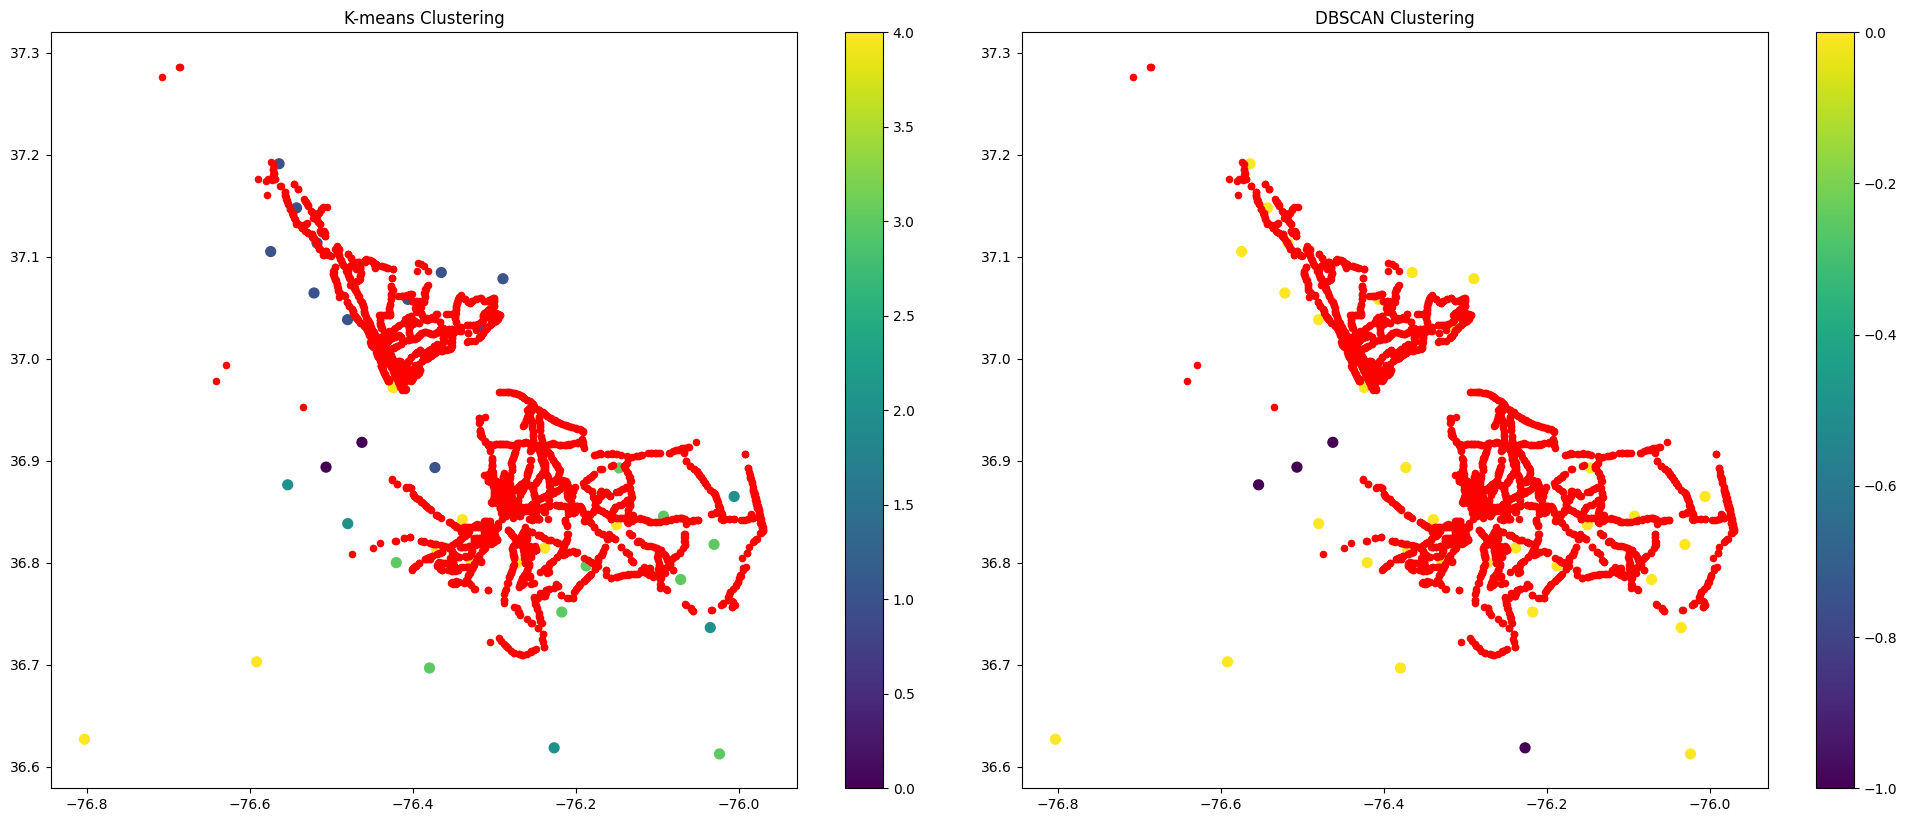

In [ ]:
data_prepared = prepare_features(income_gdf, coord_weight=0.6, income_weight=0.4)
results, best_init = analyze_clusters(data_prepared)

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, init=best_init, n_init=20, random_state=42)
income_gdf['improved_clusters'] = kmeans.fit_predict(data_prepared)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# K-means plot
income_gdf.plot(column='improved_clusters', cmap='viridis', ax=ax1, legend=True, markersize=50)
bus_stops_gdf.plot(ax=ax1, color='red', markersize=20)
ax1.set_title("K-means Clustering")

# DBSCAN plot
dbscan = density_clustering(data_prepared)
income_gdf['dbscan_clusters'] = dbscan.labels_
income_gdf.plot(column='dbscan_clusters', cmap='viridis', ax=ax2, legend=True, markersize=50)
bus_stops_gdf.plot(ax=ax2, color='red', markersize=20)
ax2.set_title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

The DBScan shows outliers in income level (in the darker dots), which are usually the richer zipcodes. From the map we can see that there are several yellow dot areas that are further out, which may indicate that the map is not all encompassing or bus stops may benefit the zipcodes that are farther out

In [ ]:
# Since the elbow plot curves around 5 clusters, 5 clusters were chosen to represent the trends of the Hampton Area

income_gdf['cluster'] = kmeans.labels_

for cluster in range(5):
    cluster_data = income_gdf[income_gdf['cluster'] == cluster]
    mean_income = cluster_data['income'].mean()
    center = centroids[cluster]
    print(f"\nCluster {cluster}")
    print(f"Center coordinates: {center[0]:.4f}, {center[1]:.4f}")
    print(f"Average income: ${mean_income:,.2f}")
    print("Zipcodes in this cluster:", sorted(cluster_data['zipcode'].tolist()))

print("\nCluster Details:")
for cluster in range(5):
    cluster_data = income_gdf[income_gdf['cluster'] == cluster]
    print(f"\nCluster {cluster} zipcodes:")
    print(cluster_data['zipcode'].value_counts().head(3))


Cluster 0
Center coordinates: -76.2746, 36.8214
Average income: $235,397.00
Zipcodes in this cluster: [23433, 23436]

Cluster 1
Center coordinates: -76.3905, 36.7476
Average income: $88,559.18
Zipcodes in this cluster: [23601, 23602, 23603, 23604, 23606, 23608, 23663, 23664, 23665, 23666, 23703]

Cluster 2
Center coordinates: -76.8032, 36.6271
Average income: $147,514.60
Zipcodes in this cluster: [23322, 23432, 23435, 23451, 23456]

Cluster 3
Center coordinates: -76.4849, 36.9059
Average income: $111,157.56
Zipcodes in this cluster: [23320, 23321, 23323, 23452, 23453, 23454, 23455, 23457, 23464]

Cluster 4
Center coordinates: -76.2058, 36.8641
Average income: $72,199.55
Zipcodes in this cluster: [23324, 23325, 23434, 23437, 23462, 23605, 23607, 23701, 23702, 23704, 23707]

Cluster Details:

Cluster 0 zipcodes:
zipcode
23433    1
23436    1
Name: count, dtype: int64

Cluster 1 zipcodes:
zipcode
23601    1
23602    1
23603    1
Name: count, dtype: int64

Cluster 2 zipcodes:
zipcode
2332

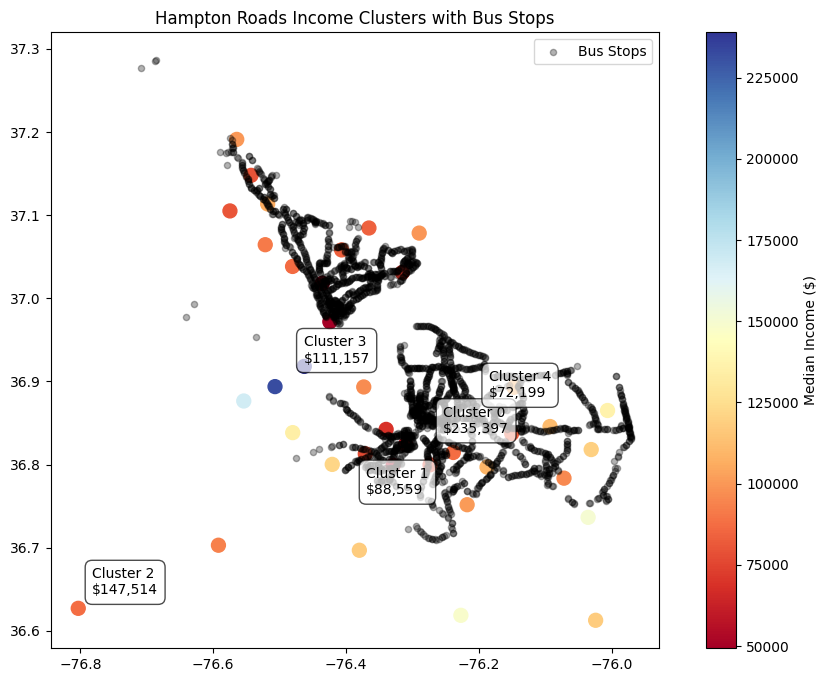

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = income_gdf.plot(
    column='income',
    ax=ax,
    cmap='RdYlBu',
    legend=True,
    markersize=100,
    legend_kwds={'label': 'Median Income ($)'}
)

bus_stops_gdf.plot(ax=ax, color='black', markersize=20, alpha=0.3, label='Bus Stops')

for cluster in range(5):
    mask = income_gdf['cluster'] == cluster
    cluster_points = income_gdf[mask]
    center = centroids[cluster]
    plt.annotate(f'Cluster {cluster}\n${int(cluster_points.income.mean()):,}',
                xy=(center[0], center[1]),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

plt.title('Hampton Roads Income Clusters with Bus Stops')
plt.legend()
plt.show()

The plot reveals several transit equity issues:

Income disparity in bus access:


Dense bus coverage in lower-income Cluster 4 (Portsmouth/Norfolk, ~$72k)
Limited service in high-income Cluster 0 (Suffolk, ~$235k)
Moderate coverage in middle-income areas


Geographic gaps:


Outer suburban areas have minimal transit access, particularly in higher-income Virginia Beach/Chesapeake zones
Some lower-income pockets in Newport News (Cluster 1) show limited bus coverage


Outliers:


Several isolated high-income points (blue) with no nearby bus service
Some low-income areas (red) on periphery with minimal transit access

This suggests a transit system primarily serving urban core and lower-income areas, with potential accessibility gaps in both wealthy and poor suburban regions.